#Objectives of this project :

Predict total energetic consumption and CO2-emission of Non Residentials Buildings based building specs with Seattle 2016 Dataset.

1.   We will perform an Exploratory Data Analysis and some data cleaning.
2.   We will do some feature engineering
3.   We will try different models to find the best one to predict energetic comsumption and CO2-emission.




#Importing Librairies

In [1]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.0 MB/s 


In [2]:
### Mandatory
import pandas as pd 
import numpy as np
import datetime 
import re

### Plotting 
import missingno as mn
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

### Collab and options 
from google.colab import drive
import sys
drive.mount('/content/gdrive')
pd. set_option('display.max_rows', 500)
pd. set_option('display.max_columns', 500)
np.set_printoptions(threshold=sys.maxsize)
import warnings
warnings.filterwarnings('ignore')
### Sklearn

##Imputing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

##Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

##Model Validation
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_validate, RandomizedSearchCV

##Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor 
import xgboost

##Metrics
from sklearn.metrics import r2_score, mean_squared_error

##Feature selection
import shap

Mounted at /content/gdrive


#Reading Data

In [3]:
data=pd.read_csv("/content/gdrive/MyDrive/2016_Building_Energy_Benchmarking.csv", sep=",")
print("This dataset has ",data.shape[0]," rows and ", data.shape[1]," columns")
data.head(5)

This dataset has  3376  rows and  46  columns


OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  \
0                    0659000030                    7     DOWNTOWN  47.61220   
1                    0659000220                    7     DOWNTOWN  47.61317   
2                    0659000475                    7     DOWNTOWN  47.61393   
3                    0659000640                    7     DOWNTOWN  47.61412   
4                    0659000970                    7     DOWNTOWN  47.61375   

   Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0 -122.33799       1927                1.0              12             88434   
1 -122.33393       1996                1.0              11            103566   
2 -122.33810       1969                1.0              41            956110   
3 -122.33664       1926                1.0              10             61320   
4 -122.34047       1980                1.0              18            175580   

   PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes  \
0                   0                   88434                          Hotel   
1               15064                   88502     Hotel, Parking, Restaurant   
2              196718                  759392                          Hotel   
3                   0                   61320                          Hotel   
4               62000                  113580  Hotel, Parking, Swimming Pool   

  LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                  Hotel                    88434.0   
1                  Hotel                    83880.0   
2                  Hotel                   756493.0   
3                  Hotel                    61320.0   
4                  Hotel                   123445.0   

  SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                          NaN                              NaN   
1                      Parking                          15064.0   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                      Parking                          68009.0   

  ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  \
0                         NaN                             NaN   
1                  Restaurant                          4622.0   
2                         NaN                             NaN   
3                         NaN                             NaN   
4               Swimming Pool                             0.0   

  YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
0                      NaN             60.0         81.699997   
1                      NaN             61.0         94.800003   
2                      NaN             43.0         96.000000   
3                      NaN             56.0        110.800003   
4                      NaN             75.0        114.800003   

   SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
0           84.300003          182.500000            189.000000   
1           97.900002          176.100006            179.399994   
2

#Exploratory Data Analysis

In [4]:
print("This dataset has ", data.duplicated().sum()," duplicated rows")
data.describe().applymap(lambda x: f"{x:0.3f}")

This dataset has  0  duplicated rows


OSEBuildingID  DataYear    ZipCode CouncilDistrictCode  Latitude  \
count      3376.000  3376.000   3360.000            3376.000  3376.000   
mean      21208.991  2016.000  98116.949               4.439    47.624   
std       12223.757     0.000     18.615               2.121     0.048   
min           1.000  2016.000  98006.000               1.000    47.499   
25%       19990.750  2016.000  98105.000               3.000    47.600   
50%       23112.000  2016.000  98115.000               4.000    47.619   
75%       25994.250  2016.000  98122.000               7.000    47.657   
max       50226.000  2016.000  98272.000               7.000    47.734   

      Longitude YearBuilt NumberofBuildings NumberofFloors PropertyGFATotal  \
count  3376.000  3376.000          3368.000       3376.000         3376.000   
mean   -122.335  1968.573             1.107          4.709        94833.537   
std       0.027    33.088             2.108          5.494       218837.607   
min    -122.414  1900.000             0.000          0.000        11285.000   
25%    -122.351  1948.000             1.000          2.000        28487.000   
50%    -122.332  1975.000             1.000          4.000        44175.000   
75%    -122.319  1997.000             1.000          5.000        90992.000   
max    -122.221  2015.000           111.000         99.000      9320156.000   

      PropertyGFAParking PropertyGFABuilding(s) LargestPropertyUseTypeGFA  \
count           3376.000               3376.000                  3356.000   
mean            8001.526              86832.011                 79177.639   
std            32326.724             207939.812                201703.407   
min                0.000               3636.000                  5656.000   
25%                0.000              27756.000                 25094.750   
50%                0.000              43216.000                 39894.000   
75%                0.000              84276.250                 76200.250   
max           512608.000            9320156.000               9320156.000   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseTypeGFA  \
count                        1679.000                        596.000   
mean                        28444.076                      11738.675   
std                         54392.918                      29331.199   
min                             0.000                          0.000   
25%                          5000.000                       2239.000   
50%                         10664.000                       5043.000   
75%                         26640.000                      10138.750   
max                        686750.000                     459748.000   

      ENERGYSTARScore SiteEUI(kBtu/sf) SiteEUIWN(kBtu/sf) SourceEUI(kBtu/sf)  \
count        2533.000         3369.000           3370.000           3367.000   
mean           67.919           54.732             57.034            134.233   
std            26.873           56.273             57.163            139.288   
min             1.000            0.000              0.000              0.000   
25%            53.000           27.900             29.400             74.700   
50%            75.000           38.600             40.900             96.200   
75%            90.000           60.400             64.275            143.900   
max           100.000          834.400            834.400           2620.000   

      SourceEUIWN(kBtu/sf) SiteEnergyUse(kBtu) SiteEnergyUseWN(kBtu)  \
count             3367.000            3371.000              3370.000   
mean               137.784         5403667.295           5276725.714   
std                139.110        21610628.628          15938786.484   
min                 -2.100               0.000                 0.000   
25%                 78.400          925128.594            970182.234   
50%                101.100         1803753.250           1904452.000   
75%                148.350         4222455.250           43

We've negatives values, we will see if its a single row or if there are more of it

In [5]:
data.loc[data['Electricity(kBtu)'] < 0]

OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
3206          49784      2016  NonResidential  Small- and Mid-Sized Office   

        PropertyName              Address     City State  ZipCode  \
3206  Bullitt Center  1501 E. Madison St.  Seattle    WA  98122.0   

     TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  \
3206                    7234600195                    3      CENTRAL   

      Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  \
3206  47.61432 -122.31257       2013                1.0               6   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
3206             52000                   0                   52000   

     ListOfAllPropertyUseTypes LargestPropertyUseType  \
3206                    Office                 Office   

      LargestPropertyUseTypeGFA SecondLargestPropertyUseType  \
3206                    48159.0                          NaN   

      SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  \
3206                              NaN                         NaN   

      ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  \
3206                             NaN                      NaN   

      ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
3206            100.0               7.1                 5.0   

      SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
3206                 2.0                  -2.1          342726.0938   

      SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  \
3206            240132.0938             0.0      -33826.80078   

      Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  \
3206          -115417.0                 0.0               0.0        False   

      Comments ComplianceStatus Outlier  TotalGHGEmissions  \
3206       NaN        Compliant     NaN               -0.8   

      GHGEmissionsIntensity  
3206                  -0.02

As we dont know if its a mistake or no, maybe the building has solar panel and that's why electricity is negative, we will delete this entry

In [6]:
print(data.shape[0])
data=data.drop(index=3206)
print(data.shape[0])

3376
3375


Let's have a quick overview on how our dataset is composed

In [7]:
EDA = pd.DataFrame(columns = ['Columns','Types','Values', 'Uniques', 'Uniques(no nulls)', 'Missing(n)', 'Missing(%)'])
eda = pd.DataFrame()

for c in data.columns:
    eda['Columns'] = [c]
    eda['Types'] = data[c].dtypes
    eda['Values'] = [data[c].unique()]
    eda['Uniques'] = len(list(data[c].unique()))
    eda['Uniques(no nulls)'] = int(data[c].nunique())
    eda['Missing(n)'] = data[c].isnull().sum()
    eda['Missing(%)'] = (data[c].isnull().sum()/ len(data)).round(3)*100
    EDA = EDA.append(eda)
EDA.sort_values('Missing(%)', ascending = False)

Columns    Types  \
0                         Comments  float64   
0                          Outlier   object   
0         YearsENERGYSTARCertified   object   
0      ThirdLargestPropertyUseType   object   
0   ThirdLargestPropertyUseTypeGFA  float64   
0     SecondLargestPropertyUseType   object   
0  SecondLargestPropertyUseTypeGFA  float64   
0                  ENERGYSTARScore  float64   
0        LargestPropertyUseTypeGFA  float64   
0           LargestPropertyUseType   object   
0                          ZipCode  float64   
0        ListOfAllPropertyUseTypes   object   
0             SourceEUIWN(kBtu/sf)  float64   
0               SourceEUI(kBtu/sf)  float64   
0                 Electricity(kWh)  float64   
0                Electricity(kBtu)  float64   
0               NaturalGas(therms)  float64   
0                 NaturalGas(kBtu)  float64   
0                TotalGHGEmissions  float64   
0                   SteamUse(kBtu)  float64   
0            GHGEmissionsIntensity  float64   
0                NumberofBuildings  float64   
0                 SiteEUI(kBtu/sf)  float64   
0               SiteEUIWN(kBtu/sf)  float64   
0            SiteEnergyUseWN(kBtu)  float64   
0              SiteEnergyUse(kBtu)  float64   
0    TaxParcelIdentificationNumber   object   
0                     BuildingType   object   
0              PrimaryPropertyType   object   
0                 ComplianceStatus   object   
0                     PropertyName   object   
0                      DefaultData     bool   
0                          Address   object   
0                             City   object   
0                            State   object   
0           PropertyGFABuilding(s)    int64   
0              CouncilDistrictCode    int64   
0               PropertyGFAParking    int64   
0                     Neighborhood   object   
0                         Latitude  float64   
0                        Longitude  float64   
0                        YearBuilt    int64   
0                   NumberofFloors    int64   
0                 PropertyGFATotal    int64   
0                         DataYear    int64   
0                    OSEBuildingID    int64   

                                              Values Uniques  \
0                                              [nan]       1   
0                   [nan, High outlier, Low outlier]       3   
0  [nan, 2016, 2014, 2012, 20172015, 201720162015...      66   
0  [nan, Restaurant, Swimming Pool, Data Center, ...      45   
0  [nan, 4622.0, 0.0, 1074.0, 9741.0, 4500.0, 430...     502   
0  [nan, Parking, Office, Restaurant, K-12 School...      51   
0  [nan, 15064.0, 68009.0, 57600.0, 25200.0, 4900...    1353   
0  [60.0, 61.0, 43.0, 56.0, 75.0, nan, 27.0, 1.0,...     101   
0  [88434.0, 83880.0, 756493.0, 61320.0, 123445.0...    3122   
0  [Hotel, Police Station, Other - Entertainment/...      57   
0  [98101.0, 98121.0, 98104.0, 98154.0, 98118.0, ...      56   
0  [Hotel, Hotel, Parking, Restaurant, Hotel, Par...     467   
0  [189.0, 179.3999939, 244.1000061, 224.0, 215.6...    1694   
0  [182.5, 176.1000061, 241.8999939, 216.1999969,...    1648   
0  [1156514.25, 950425.1875, 14515435.0, 811525.3...    3352   
0  [3946027.0, 3242851.0, 49526664.0, 2768924.0, ...    3351   
0  [12764.5293, 51450.81641, 14938.0, 18112.13086...    2110   
0  [1276453.0, 5145082.0, 1493800.0, 1811213.0, 8...    2110   
0  [249.98, 295.86, 2089.28, 286.43, 505.01, 301....    2818   
0  [2003882.0, 0.0, 21566554.0, 2214446.25, 22762...     132   
0  [2.83, 2.86, 2.19, 4.67, 2.88, 3.1, 2.12, 2.16...     511   
0  [1.0, 3.0, 0.0, 2.0, 4.0, 27.0, 6.0, 11.0, 14....      18   
0  [81.69999695, 94.80000305, 96.0, 110.8000031, ...    1086   
0  [84.30000305, 97.90000153, 97.69999695, 113.30...    1105   
0  [7456910.0, 8664479.0, 73937112.0, 6946800.5, ...    3341   
0  [7226362.5, 8387933.0, 72587024.0, 6794584.0, ...    3354   
0  [0659000030, 0659000220, 0659000475, 065900064...    3267   
0  [NonResidential, Nonre

Vizualising the dataset in a matrix to see if there is lot of missing values

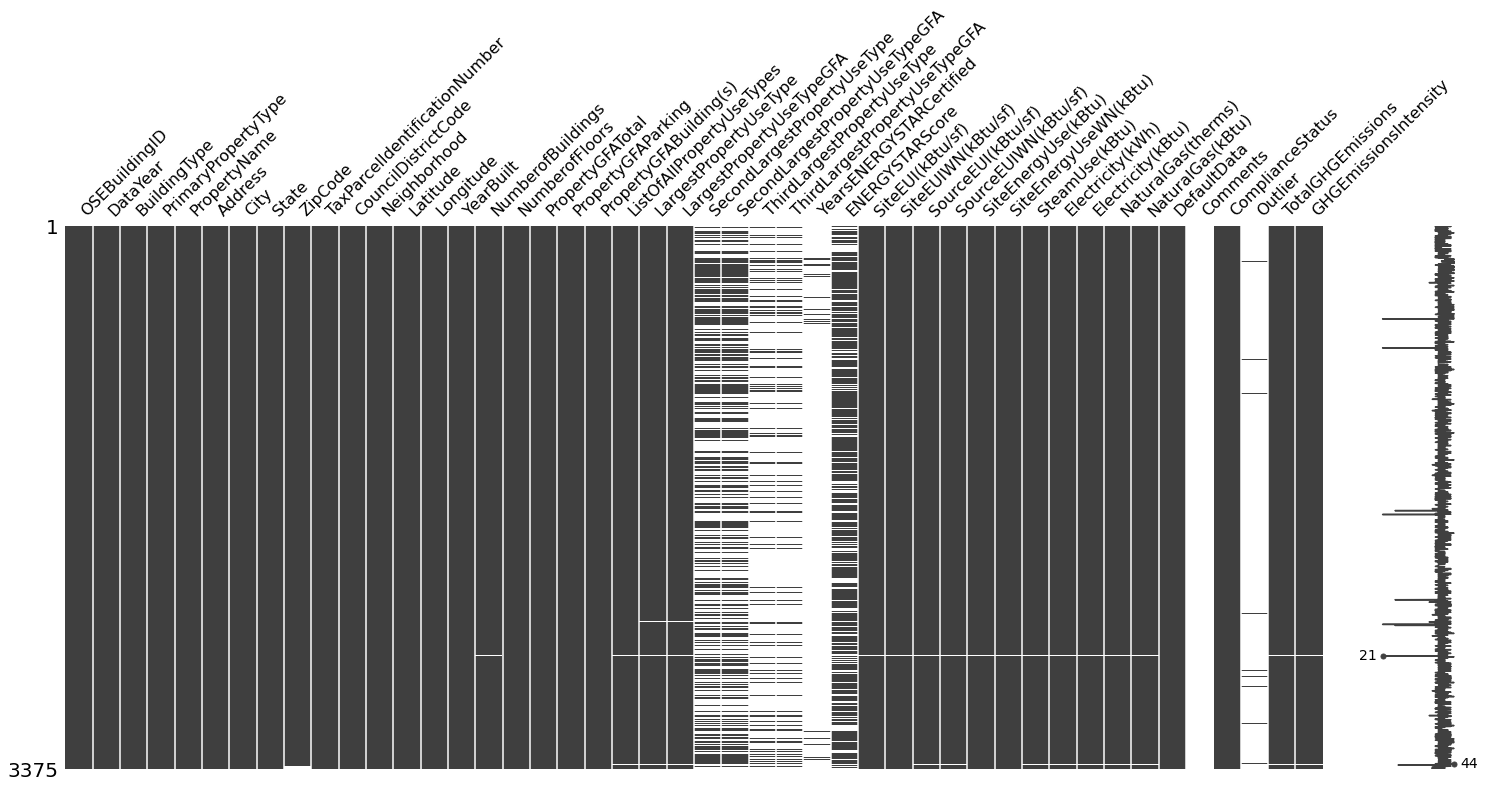

In [8]:
mn.matrix(data)

As we can see on both table and matrix, only few columns have missing data

Text(2, 60, 'Threshold for deletion')

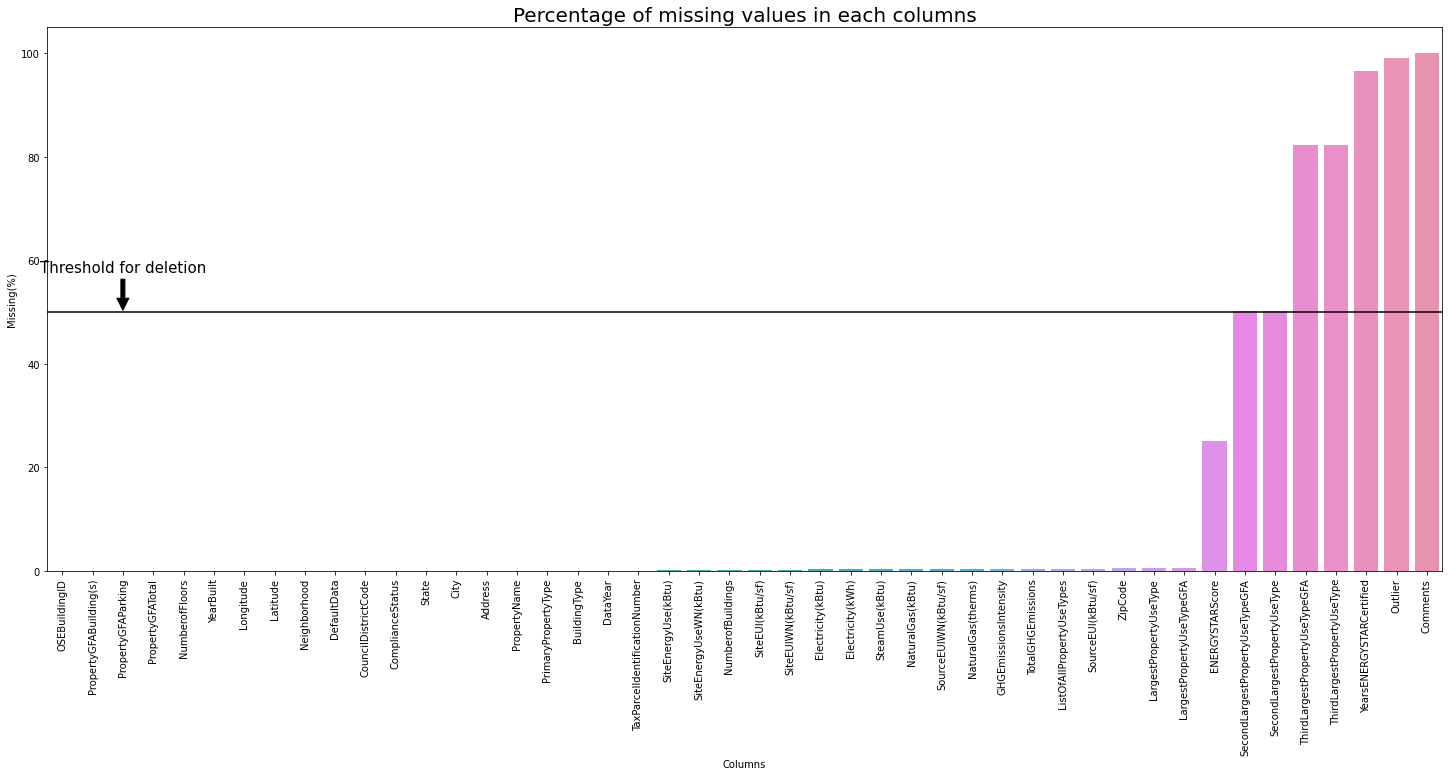

In [9]:
fig, ax = plt.subplots(figsize=(25,10))
sns.barplot(x=EDA['Columns'],y=EDA['Missing(%)'], data=EDA, order=EDA.sort_values('Missing(%)').Columns)
plt.axhline(y=50, xmin=0, xmax=len(EDA),c="black")
plt.title("Percentage of missing values in each columns", fontsize=20)
plt.xticks(rotation=90)
ax.annotate('Threshold for deletion',
            xy=(2, 50),xytext=(2, 60), size=15, arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')

Dropping columns with more than 50% missing data

In [12]:
x=EDA.loc[EDA['Missing(%)']<= 50]
x=x['Columns'].tolist()

data_selected=data.copy()
for col in data_selected.columns :
  if col not in x : data_selected=data_selected.drop(col, axis=1)

In [13]:
cols_to_plot=[]
for i in data_selected.columns[data_selected.dtypes == 'float64']:
    cols_to_plot.append(i)
cols_to_plot = [e for e in cols_to_plot if e in ('ENERGYSTARScore', 'SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','SiteEnergyUse(kBtu)','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity')]

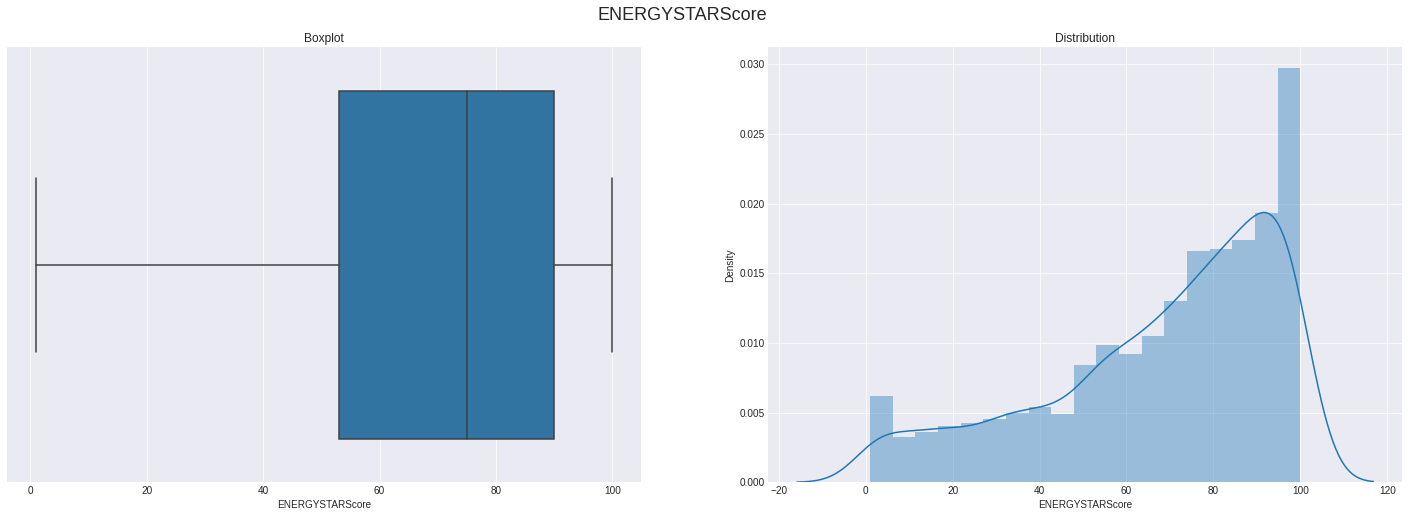

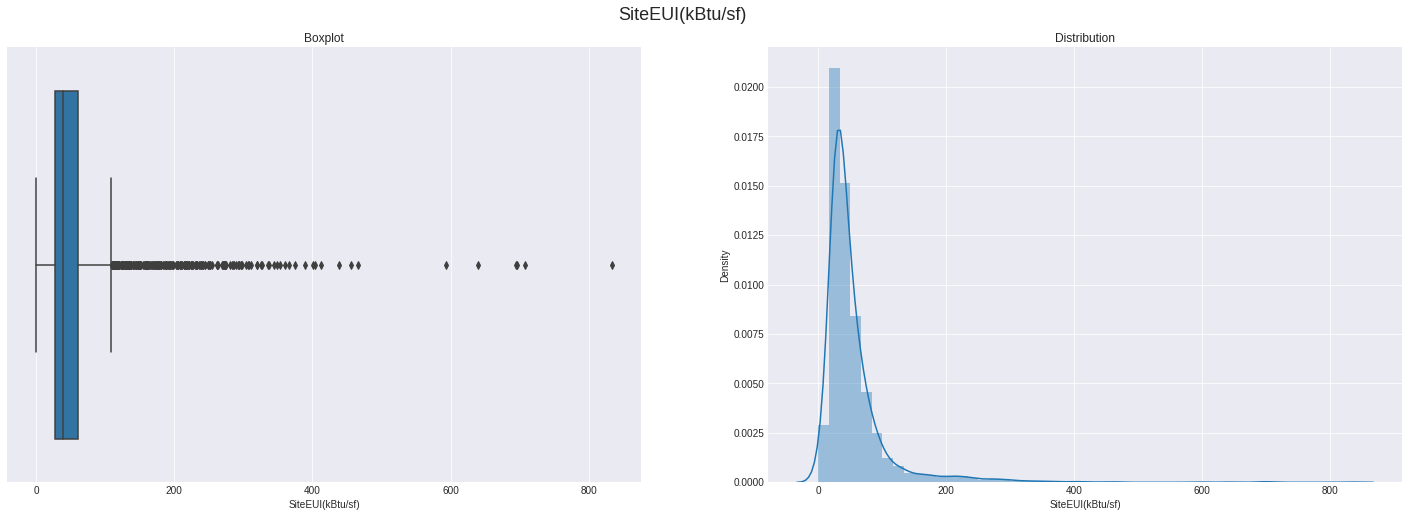

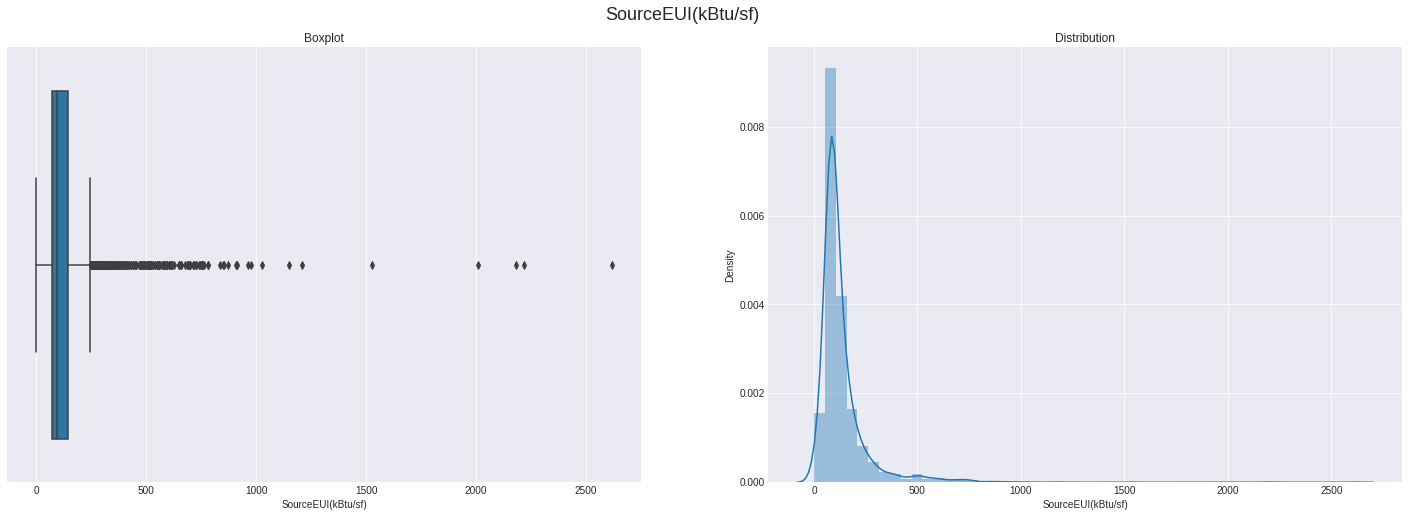

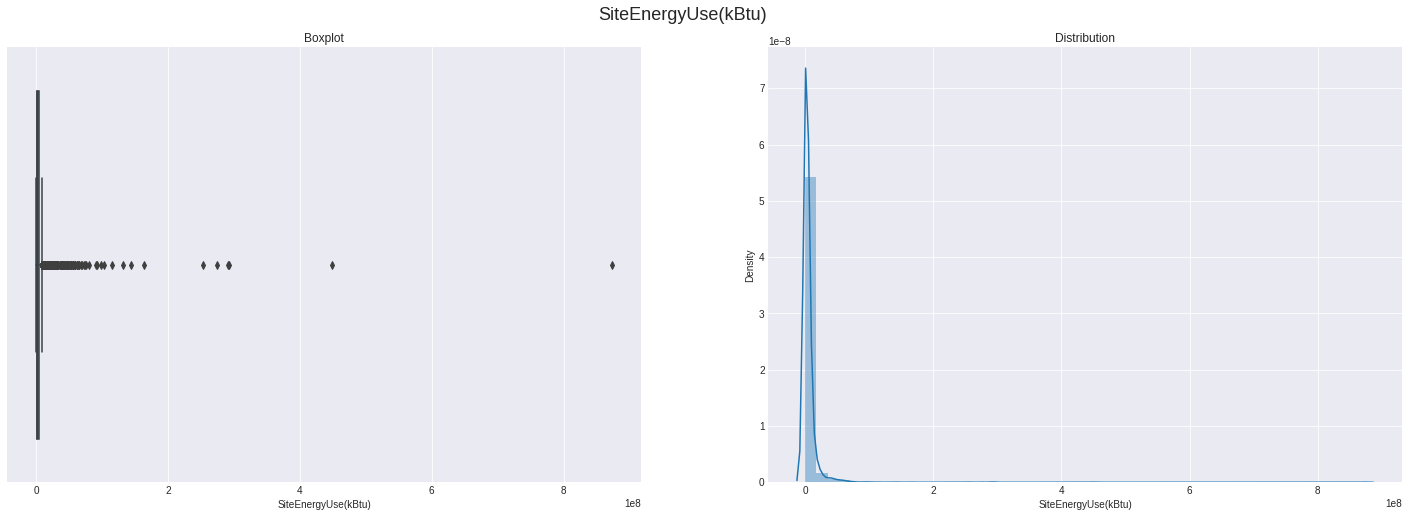

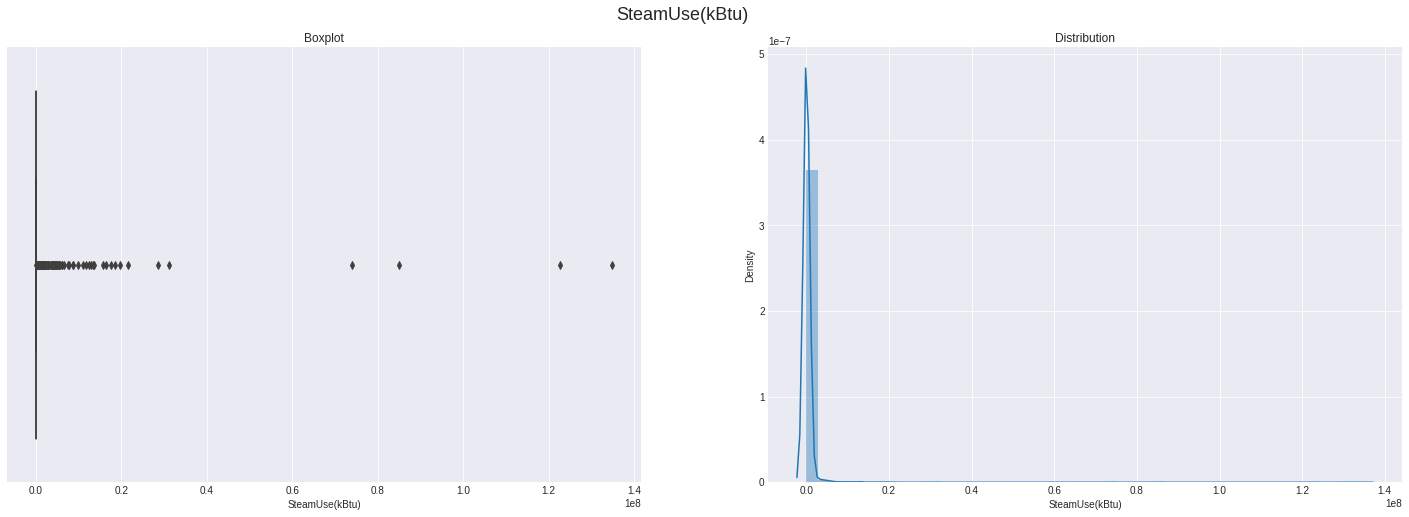

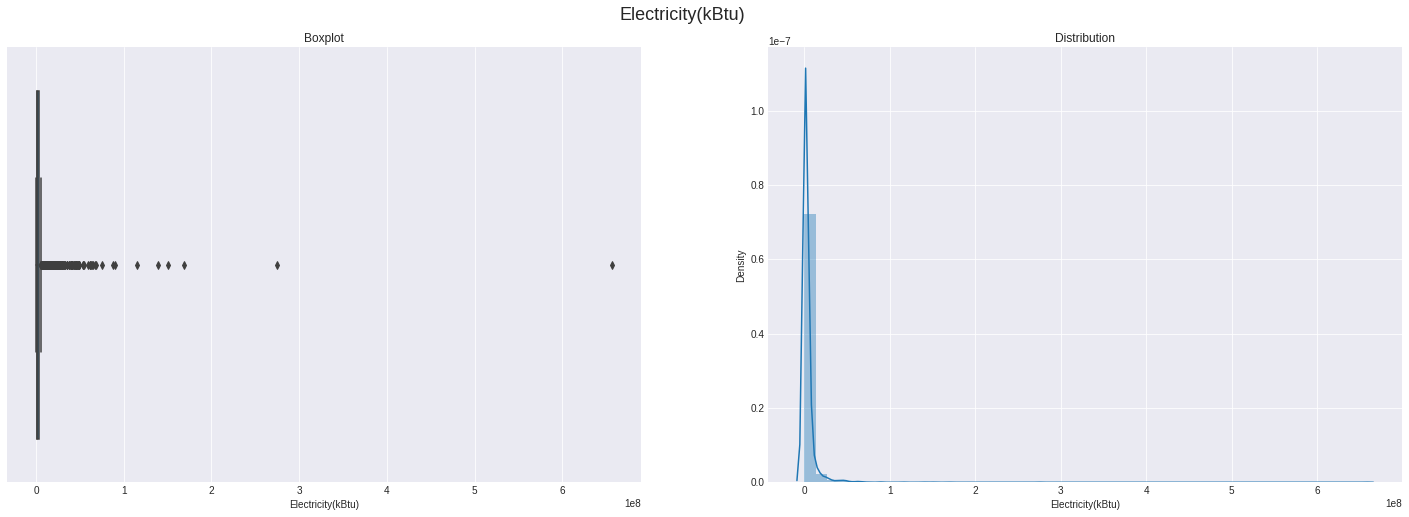

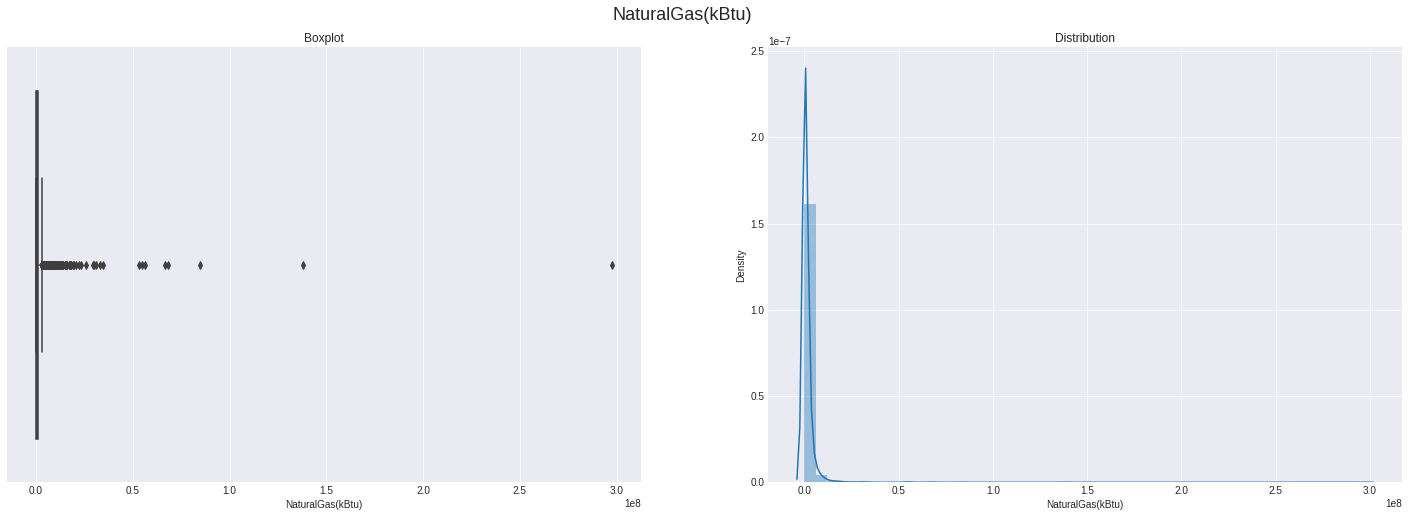

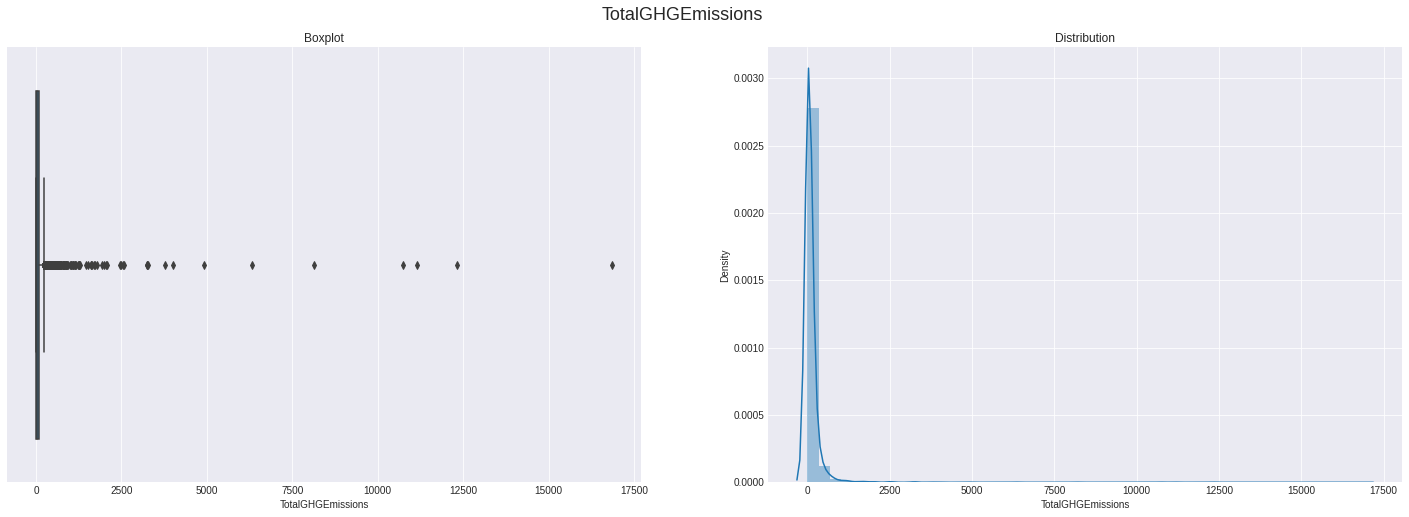

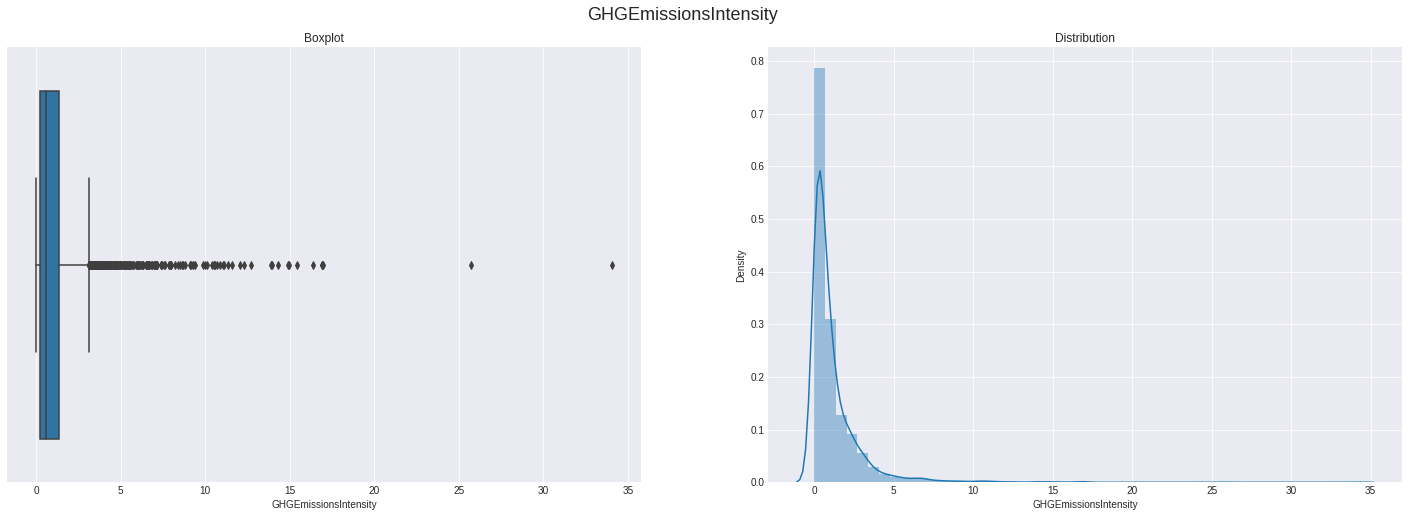

In [14]:
for col in data_selected.columns:
  if col in cols_to_plot :
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(1, 2, figsize=(25, 8))
    ax = np.reshape(ax, (1, 2))
    plt.suptitle(col, fontsize=18, y=0.95)
    sns.boxplot(data[col], ax=ax[0, 0])
    sns.distplot(data[col], ax=ax[0, 1])
    ax[0, 0].set_title("Boxplot")
    ax[0, 1].set_title("Distribution")
    plt.show()

Data seems to be distributed in an asymetric way, we have to keep it in mind for later use, and apply a log transformation.

Deleting WeatherNormalized Columns as we will not use them

In [15]:
data_selected=data_selected.drop(columns=['SiteEnergyUseWN(kBtu)','SourceEUIWN(kBtu/sf)','SiteEUIWN(kBtu/sf)'])

Text(0.5, 1.0, 'Distribution of all Building Types')

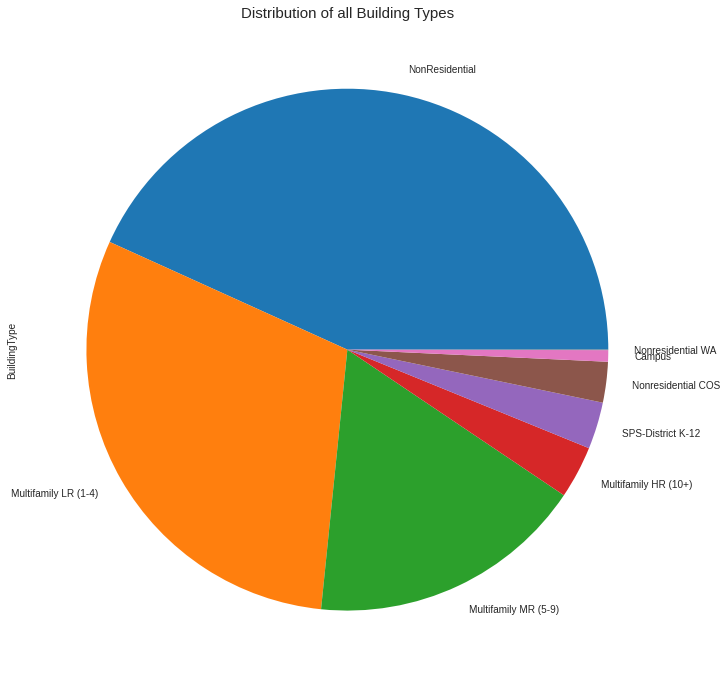

In [16]:
plt.figure(figsize=(12,12))
data_selected["BuildingType"].value_counts().plot.pie()
plt.title("Distribution of all Building Types", fontsize=15)

Almost half of building are non residentials, that's those we will keep.
Also changing Nonresidential WA and COS to NonResidential

In [17]:
data_selected["BuildingType"]=data_selected["BuildingType"].replace(['Nonresidential COS', 'Nonresidential WA'], 'NonResidential')
data_selected['BuildingType'].unique()

array(['NonResidential', 'Multifamily MR (5-9)', 'SPS-District K-12',
       'Campus', 'Multifamily LR (1-4)', 'Multifamily HR (10+)'],
      dtype=object)

#Data Cleaning

Dropping useless columns (Unique ID and non homogeneous energy units)

In [18]:
df_ml=data_selected.drop(columns=['OSEBuildingID', 'DataYear', 'PropertyName', 'Address', 'City', 'State', 'TaxParcelIdentificationNumber', 'NaturalGas(therms)', 'Electricity(kWh)'], axis=1).reset_index()
values=['NonResidential', 'SPS-District K-12', 'Campus']
df_ml=df_ml[df_ml['BuildingType'].isin(values)]
print(df_ml['BuildingType'].unique(), df_ml.shape[0])

['NonResidential' 'SPS-District K-12' 'Campus'] 1667


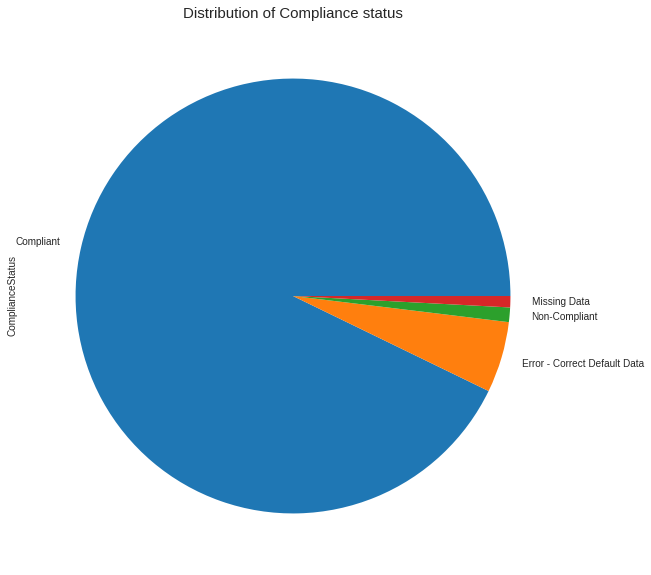

In [19]:
plt.figure(figsize=(10,10))
df_ml['ComplianceStatus'].value_counts().plot.pie()
plt.title("Distribution of Compliance status", fontsize=15)
plt.show()

We will keep only compliant data

In [20]:
print("All Compliance status :", df_ml.shape[0])
df_ml=df_ml[df_ml['ComplianceStatus']=='Compliant']
print("Only Compliant status :", df_ml.shape[0])

All Compliance status : 1667
Only Compliant status : 1547


Filling LargestPropertyUseTypeGFA with PropertyGFABuilding(s) when LargestPropertyUseTypeGFA is NaN

In [21]:
df_ml['LargestPropertyUseType']=df_ml['LargestPropertyUseType'].fillna('Other')
df_ml[df_ml['LargestPropertyUseTypeGFA'].isna()==True]
df_ml['LargestPropertyUseTypeGFA']=np.where(df_ml['LargestPropertyUseTypeGFA'].isna() == True, df_ml['PropertyGFABuilding(s)'], df_ml['LargestPropertyUseTypeGFA'])

Quick Overview of NaN

In [22]:
for col in df_ml.columns :
  print(col," // ", df_ml[col].isna().sum()," // ", df_ml[col].dtypes)
df_ml=df_ml.drop(columns=('index'), axis=1)
print(df_ml.shape[0])

index  //  0  //  int64
BuildingType  //  0  //  object
PrimaryPropertyType  //  0  //  object
ZipCode  //  13  //  float64
CouncilDistrictCode  //  0  //  int64
Neighborhood  //  0  //  object
Latitude  //  0  //  float64
Longitude  //  0  //  float64
YearBuilt  //  0  //  int64
NumberofBuildings  //  0  //  float64
NumberofFloors  //  0  //  int64
PropertyGFATotal  //  0  //  int64
PropertyGFAParking  //  0  //  int64
PropertyGFABuilding(s)  //  0  //  int64
ListOfAllPropertyUseTypes  //  0  //  object
LargestPropertyUseType  //  0  //  object
LargestPropertyUseTypeGFA  //  0  //  float64
ENERGYSTARScore  //  551  //  float64
SiteEUI(kBtu/sf)  //  0  //  float64
SourceEUI(kBtu/sf)  //  0  //  float64
SiteEnergyUse(kBtu)  //  0  //  float64
SteamUse(kBtu)  //  0  //  float64
Electricity(kBtu)  //  0  //  float64
NaturalGas(kBtu)  //  0  //  float64
DefaultData  //  0  //  bool
ComplianceStatus  //  0  //  object
TotalGHGEmissions  //  0  //  float64
GHGEmissionsIntensity  //  0  //  f

We will use only Neighborhood as location so we deleting all other feature related

In [23]:
df_ml=df_ml.drop(columns=['ZipCode','CouncilDistrictCode'])

Adding a column to indicate where we imputed ENERGYSTARScore Value

In [24]:
df_ml['ESS_miss']=np.where((df_ml['ENERGYSTARScore'].isna() == True), "y","n")
df_ml[df_ml['ESS_miss'] == "y"]['ENERGYSTARScore'].unique()

array([nan])

In [25]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1547 entries, 0 to 3374
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   BuildingType               1547 non-null   object 
 1   PrimaryPropertyType        1547 non-null   object 
 2   Neighborhood               1547 non-null   object 
 3   Latitude                   1547 non-null   float64
 4   Longitude                  1547 non-null   float64
 5   YearBuilt                  1547 non-null   int64  
 6   NumberofBuildings          1547 non-null   float64
 7   NumberofFloors             1547 non-null   int64  
 8   PropertyGFATotal           1547 non-null   int64  
 9   PropertyGFAParking         1547 non-null   int64  
 10  PropertyGFABuilding(s)     1547 non-null   int64  
 11  ListOfAllPropertyUseTypes  1547 non-null   object 
 12  LargestPropertyUseType     1547 non-null   object 
 13  LargestPropertyUseTypeGFA  1547 non-null   float

Deleting useless columns

In [26]:
df_ml=df_ml.drop(columns=['DefaultData', 'ComplianceStatus'])
df_ml.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'Latitude',
       'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'ESS_miss'],
      dtype='object')

Reindexing columns and imputing numericals missing values

In [27]:
df_ml=df_ml.reindex(columns=['ESS_miss', 'BuildingType', 'PrimaryPropertyType', 'Neighborhood','ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
                             'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors','PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
                             'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)','Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions','GHGEmissionsIntensity']).reset_index(drop=True)

In [28]:
df_ml.isna().sum()

ESS_miss                       0
BuildingType                   0
PrimaryPropertyType            0
Neighborhood                   0
ListOfAllPropertyUseTypes      0
LargestPropertyUseType         0
Latitude                       0
Longitude                      0
YearBuilt                      0
NumberofBuildings              0
NumberofFloors                 0
PropertyGFATotal               0
PropertyGFAParking             0
PropertyGFABuilding(s)         0
LargestPropertyUseTypeGFA      0
ENERGYSTARScore              551
SiteEUI(kBtu/sf)               0
SourceEUI(kBtu/sf)             0
SiteEnergyUse(kBtu)            0
SteamUse(kBtu)                 0
Electricity(kBtu)              0
NaturalGas(kBtu)               0
TotalGHGEmissions              0
GHGEmissionsIntensity          0
dtype: int64

2 ways to proceed here : 

- Imputing EnergyStarScore Values with iterative Imputer 
- Dropping rows where ENERGYSTARScore is missing

goal here is to see if imputing values has a influence or not

In [29]:
df_wo=df_ml.loc[df_ml['ESS_miss'] == "n"].reset_index(drop=True)

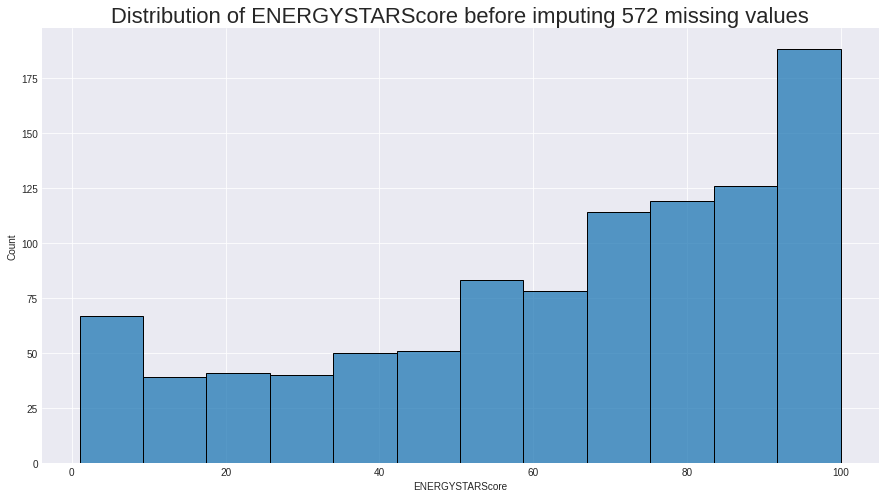

In [30]:
plt.figure(figsize=(15,8))
sns.histplot(df_ml['ENERGYSTARScore'])
plt.title("Distribution of ENERGYSTARScore before imputing 572 missing values", fontsize = 22)
plt.show()

In [31]:
imputer = IterativeImputer(
    estimator=xgboost.XGBRegressor(objective ='reg:squarederror',
        n_estimators=500,
        random_state=0,
        max_depth=8,
        eta=0.001
    ),
    missing_values=np.nan,
    max_iter=100,
    min_value=0,
    initial_strategy='median',
    imputation_order='ascending',
    random_state=0)
numericals=df_ml.iloc[:, 8:29]
transformed_num = imputer.fit_transform(numericals)
df_ml.iloc[:, 8:29]=transformed_num


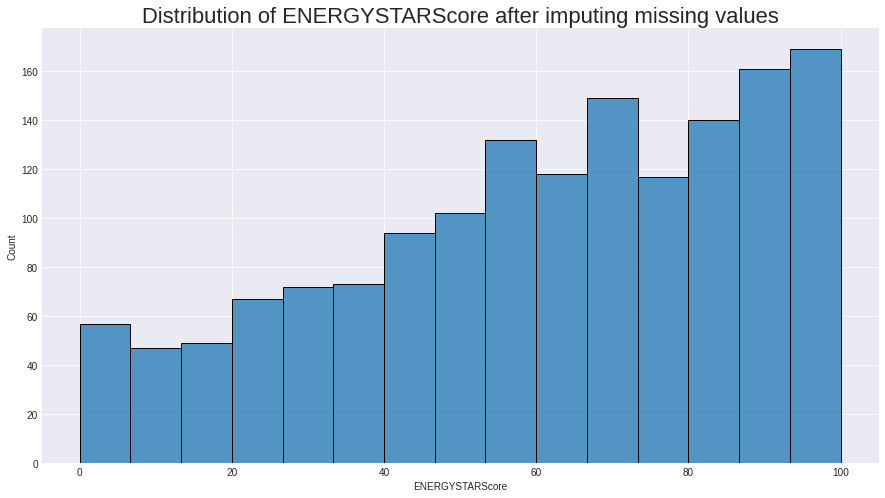

In [32]:
plt.figure(figsize=(15,8))
sns.histplot(df_ml['ENERGYSTARScore'])
plt.title("Distribution of ENERGYSTARScore after imputing missing values", fontsize = 22)
plt.show()

We kept the distribution

Correlation with imputed values

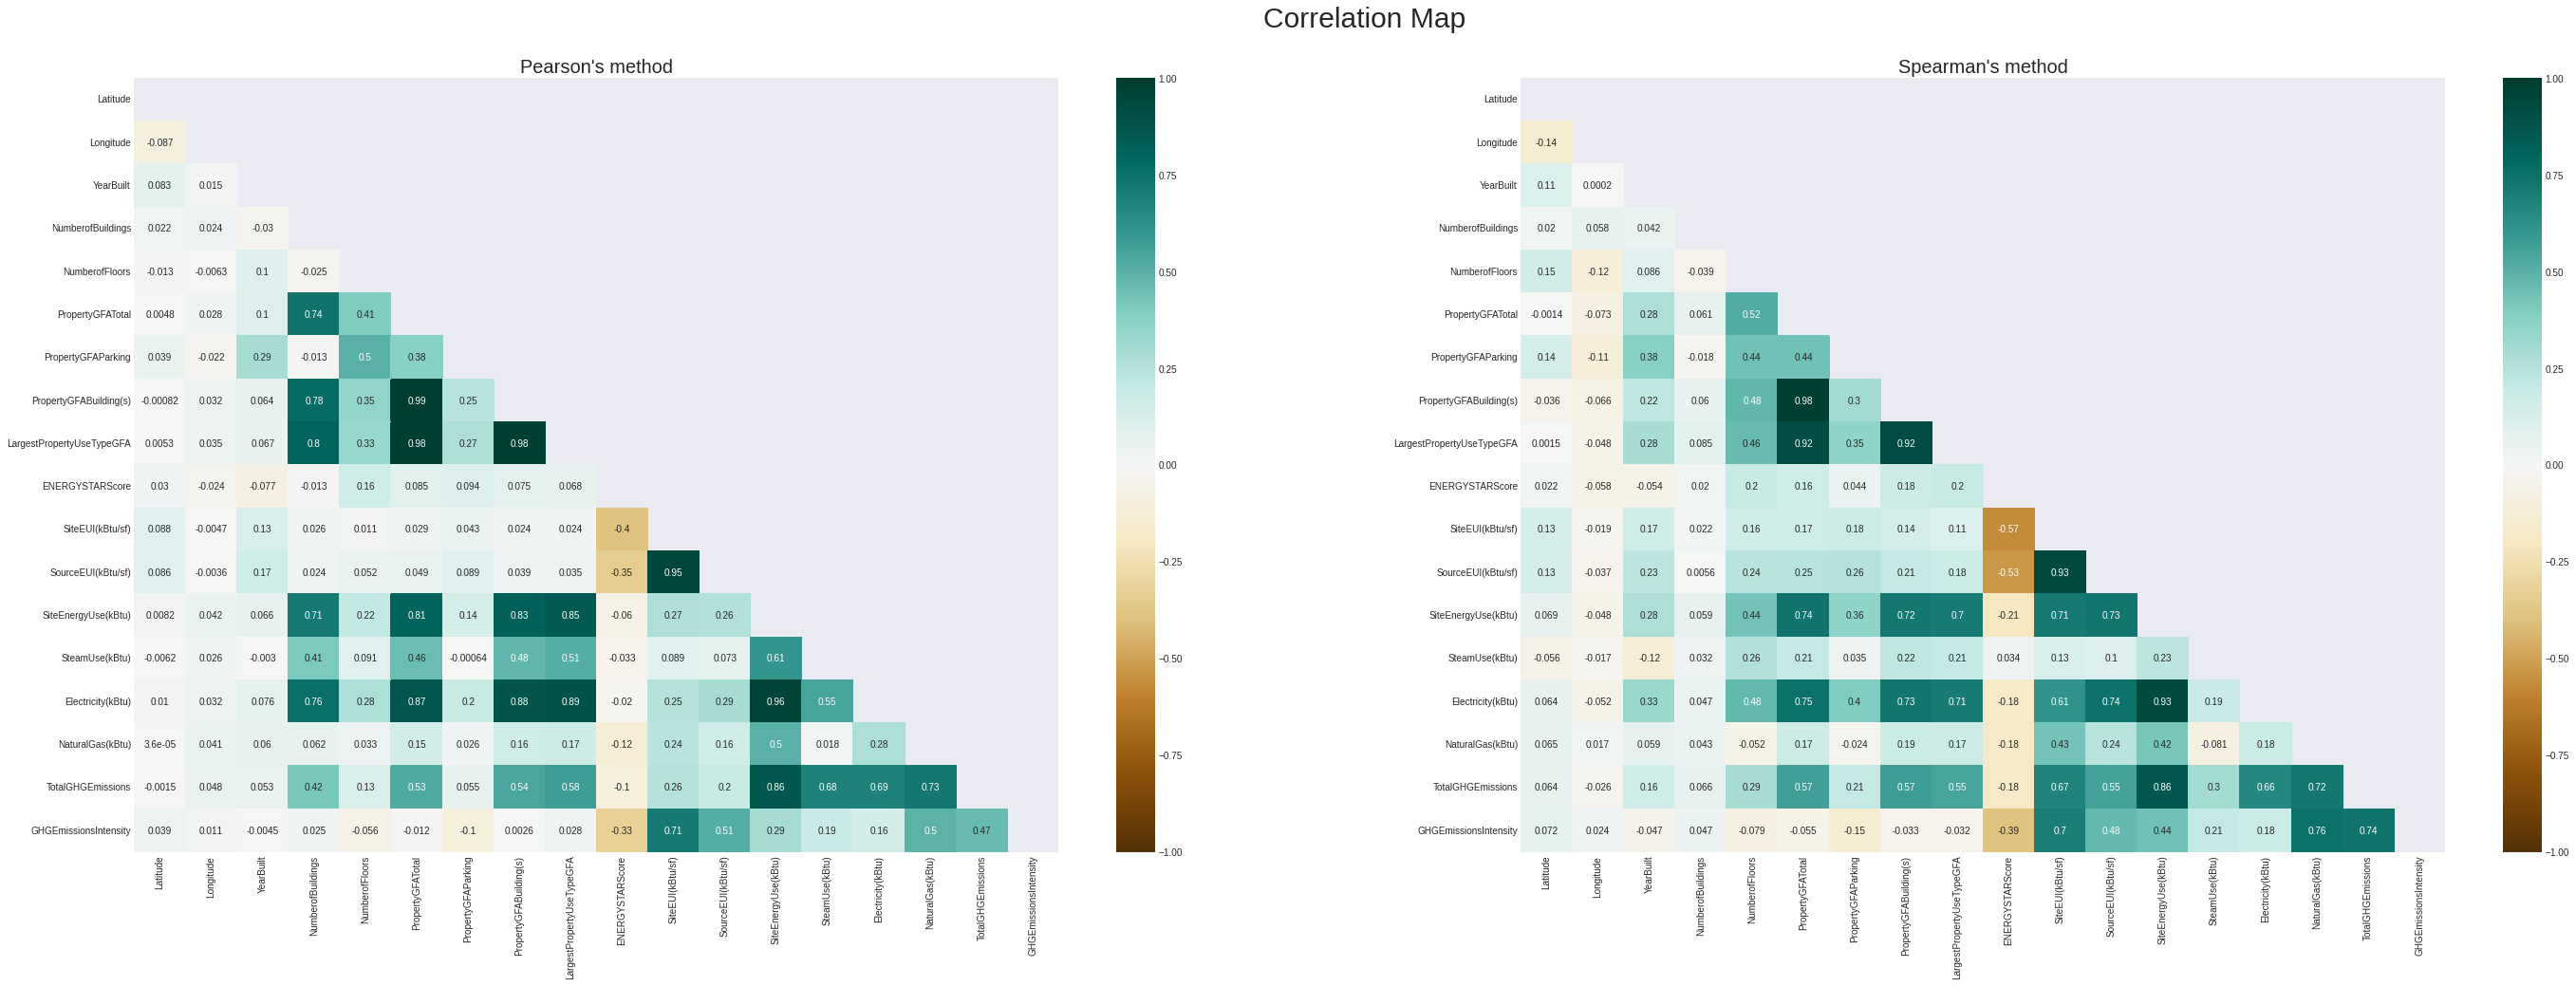

In [33]:
mask = np.triu(np.ones_like(df_ml.corr(), dtype=np.bool))

fig, ax = plt.subplots(1, 2, figsize=(48, 15))
ax = np.reshape(ax, (1, 2))
plt.suptitle("Correlation Map", fontsize=30, y=0.95)
sns.heatmap(df_ml.corr(method="pearson"), annot=True, vmin=-1, vmax=1, mask=mask, cmap='BrBG', ax=ax[0, 0])
sns.heatmap(df_ml.corr(method="spearman"), annot=True, vmin=-1, vmax=1, mask=mask, cmap='BrBG', ax=ax[0, 1])
ax[0, 0].set_title("Pearson's method", fontsize=20)
ax[0, 1].set_title("Spearman's method", fontsize=20)
plt.show()

TotalGHGEmissions is highly correlated to Energy features, while SiteEnergyUse is correlated to buildings property

Correlation without imputed values

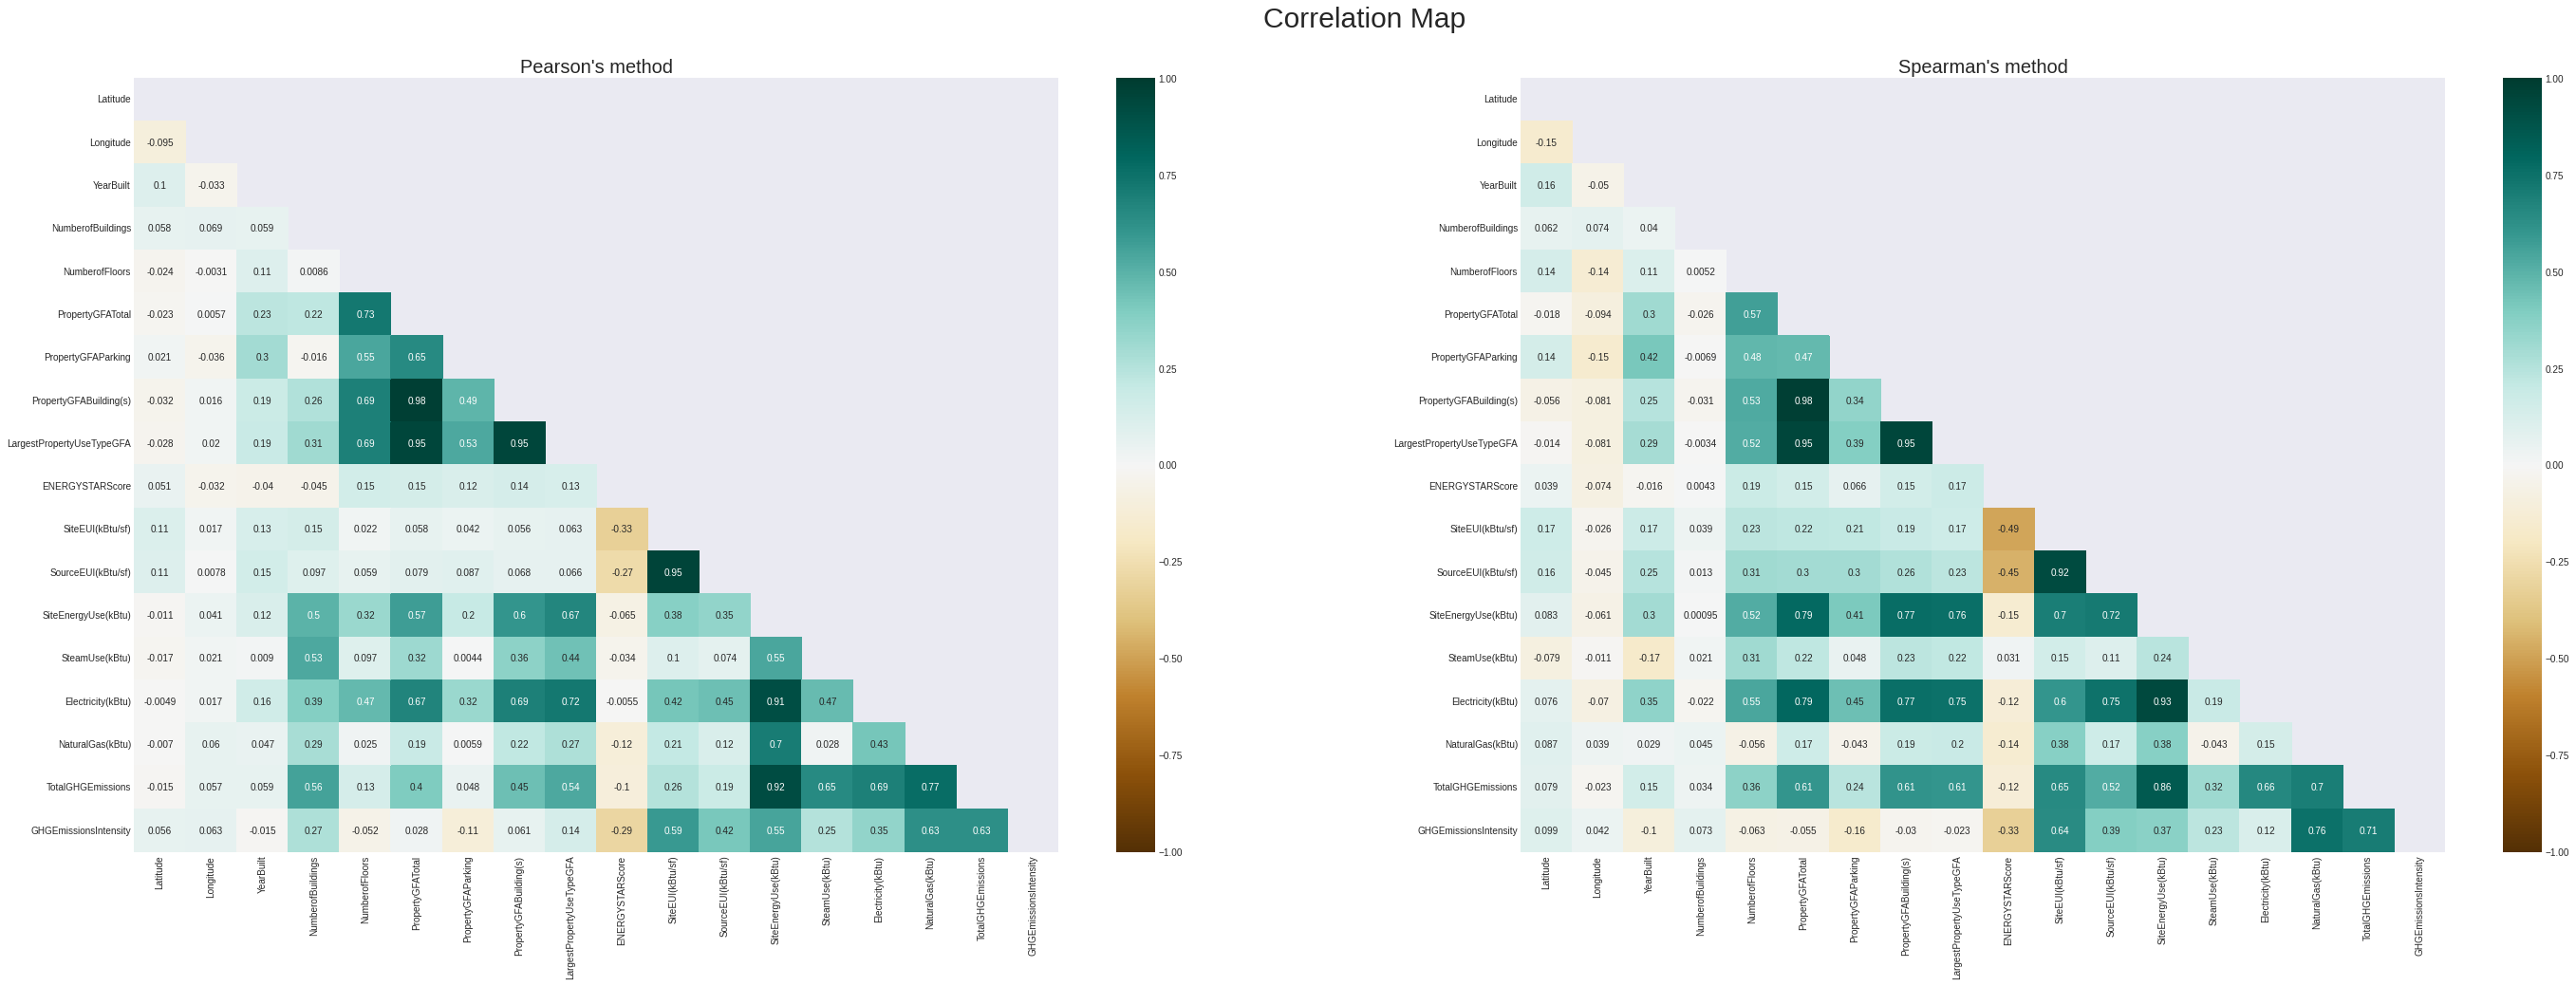

In [34]:
mask = np.triu(np.ones_like(df_wo.corr(), dtype=np.bool))

fig, ax = plt.subplots(1, 2, figsize=(48, 15))
ax = np.reshape(ax, (1, 2))
plt.suptitle("Correlation Map", fontsize=30, y=0.95)
sns.heatmap(df_wo.corr(method="pearson"), annot=True, vmin=-1, vmax=1, mask=mask, cmap='BrBG', ax=ax[0, 0])
sns.heatmap(df_wo.corr(method="spearman"), annot=True, vmin=-1, vmax=1, mask=mask, cmap='BrBG', ax=ax[0, 1])
ax[0, 0].set_title("Pearson's method", fontsize=20)
ax[0, 1].set_title("Spearman's method", fontsize=20)
plt.show()

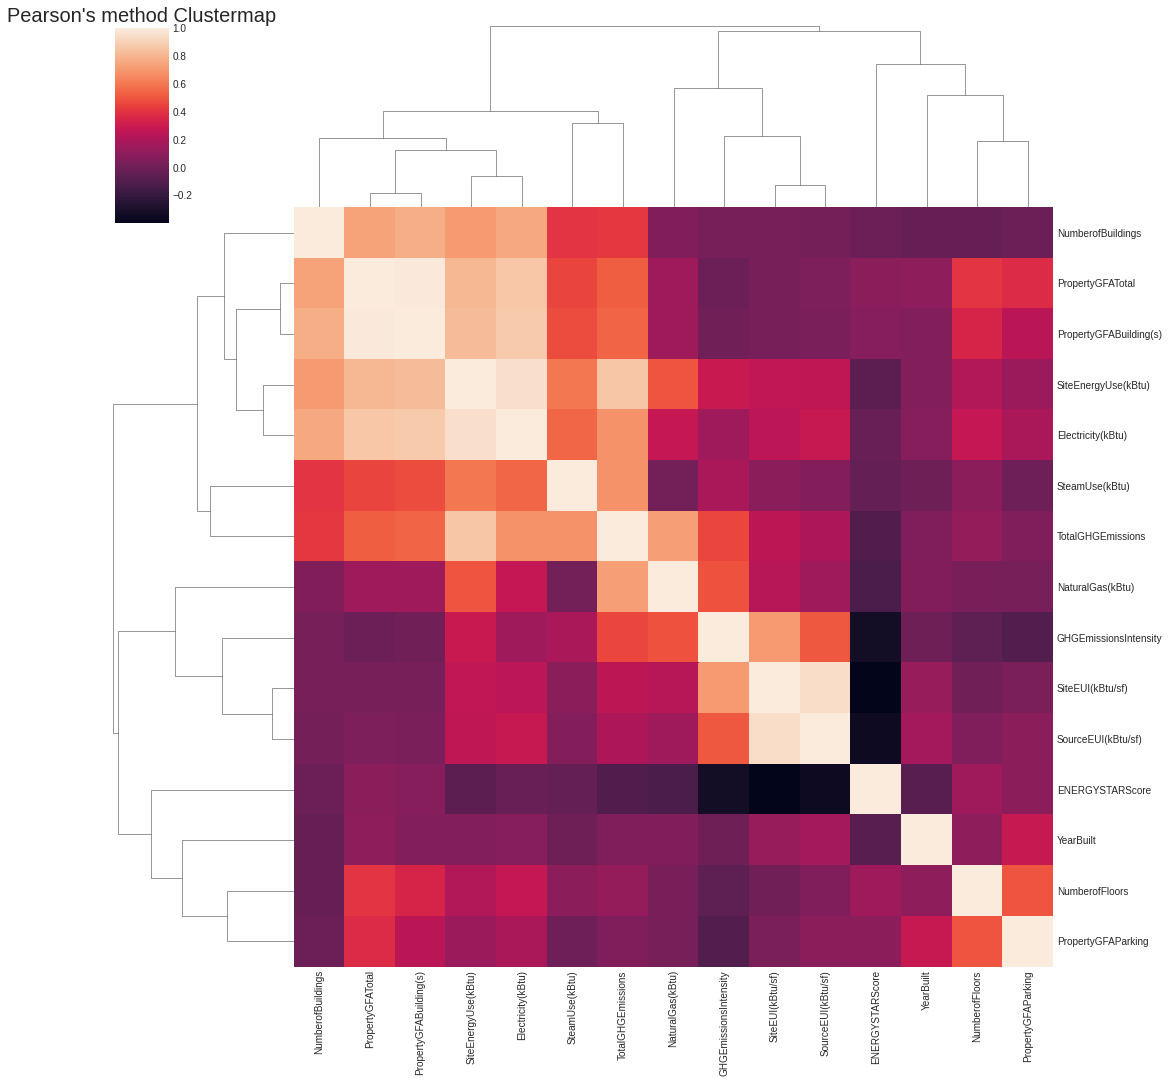

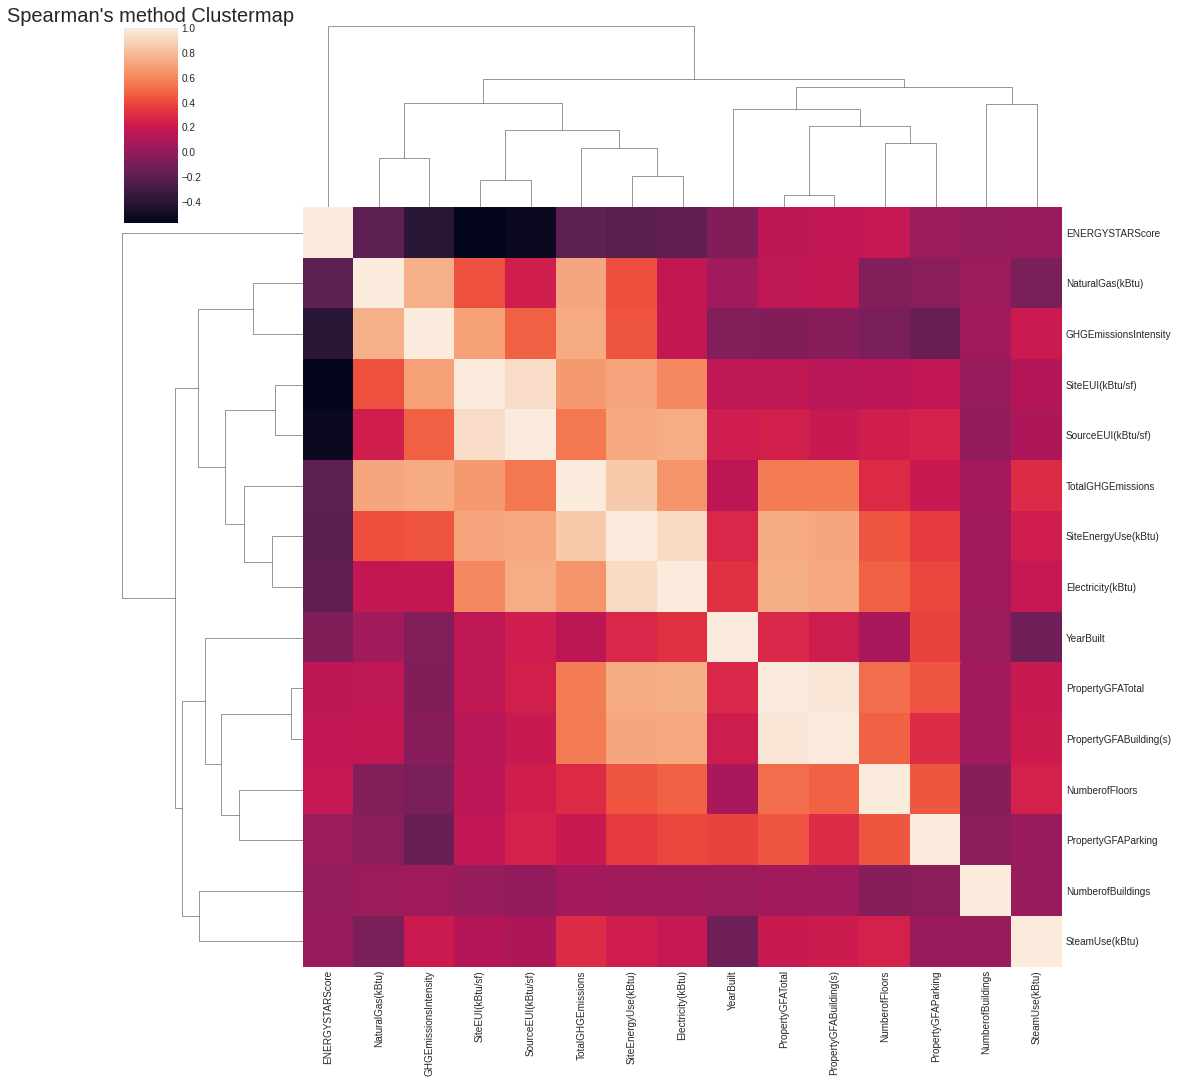

In [35]:
### Imputed values
cols_interest=['YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ENERGYSTARScore','SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity']

sns.clustermap(df_ml[cols_interest].corr(method="pearson"), figsize=(15,15))
plt.title("Pearson's method Clustermap", fontsize=20)
plt.show()
sns.clustermap(df_ml[cols_interest].corr(method="spearman"), figsize=(15,15))
plt.title("Spearman's method Clustermap", fontsize=20)
plt.show()


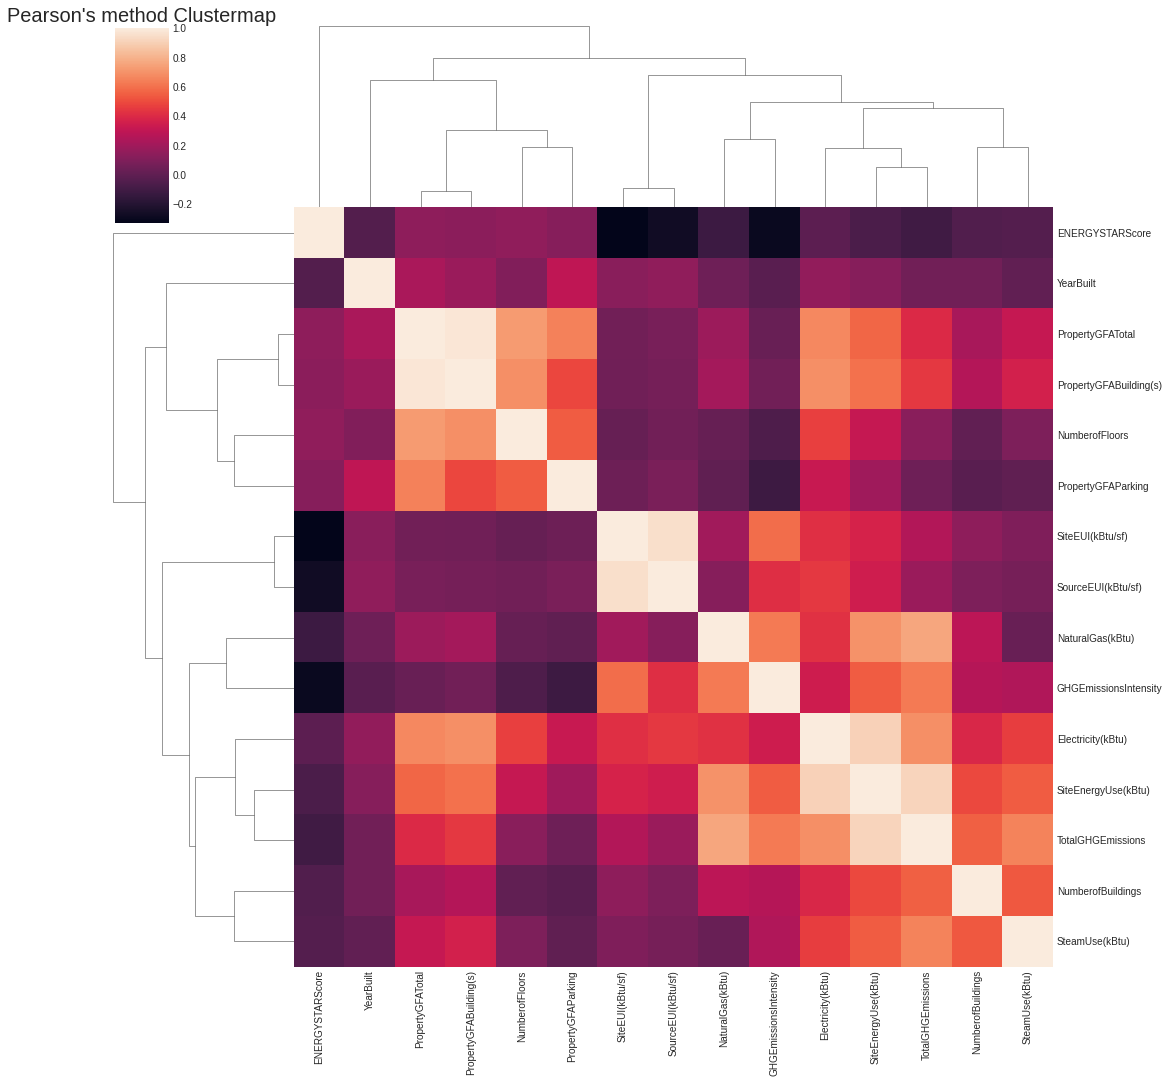

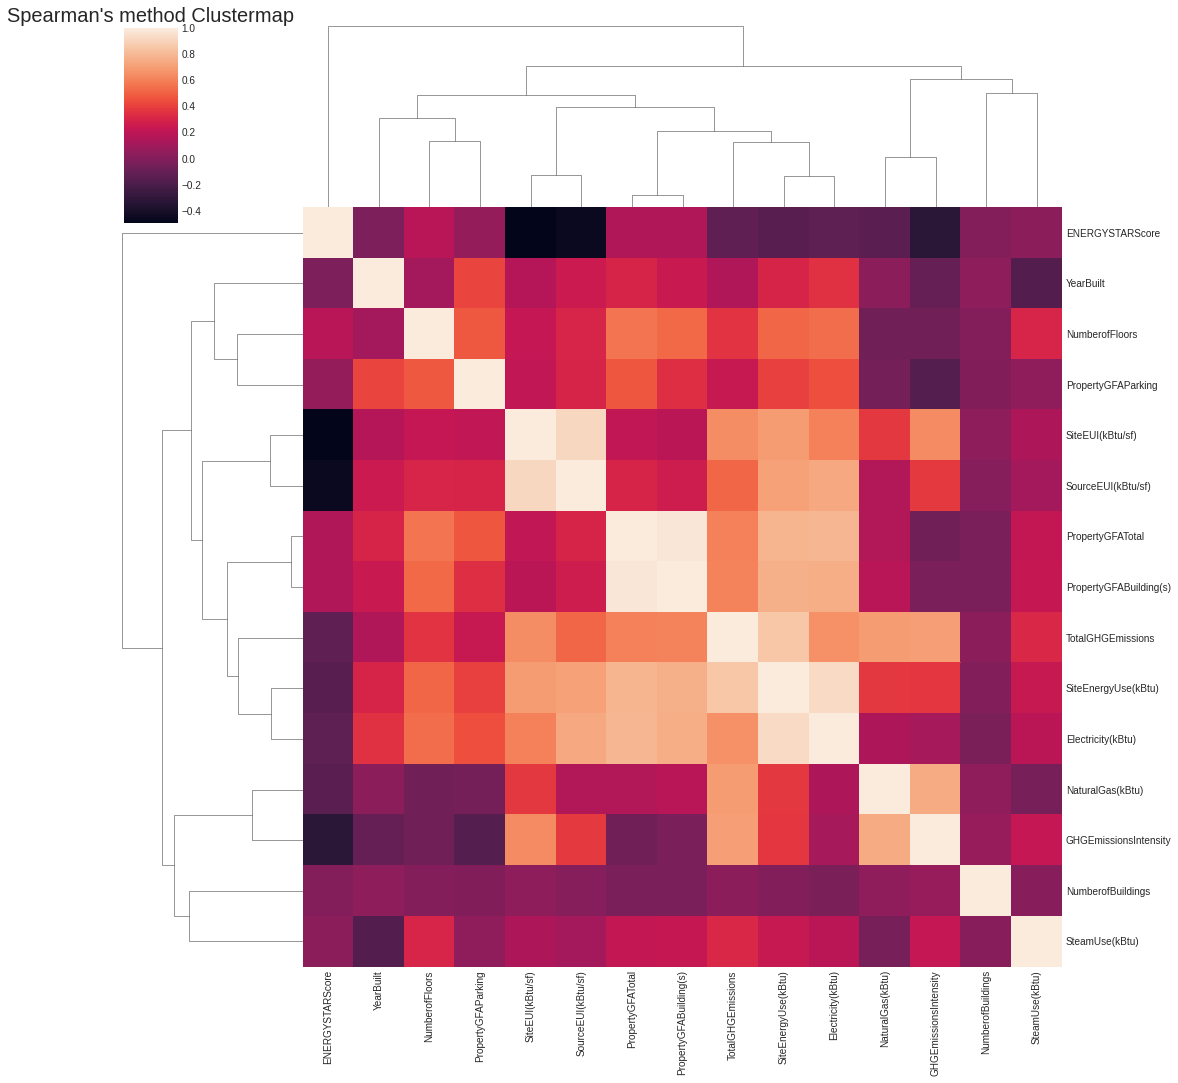

In [36]:
### Without imputed values

cols_interest=['YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ENERGYSTARScore','SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity']

sns.clustermap(df_wo[cols_interest].corr(method="pearson"), figsize=(15,15))
plt.title("Pearson's method Clustermap", fontsize=20)
plt.show()
sns.clustermap(df_wo[cols_interest].corr(method="spearman"), figsize=(15,15))
plt.title("Spearman's method Clustermap", fontsize=20)
plt.show()

Cluster maps are an other view to spot correlated features 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]), <a list of 55 Text major ticklabel objects>)

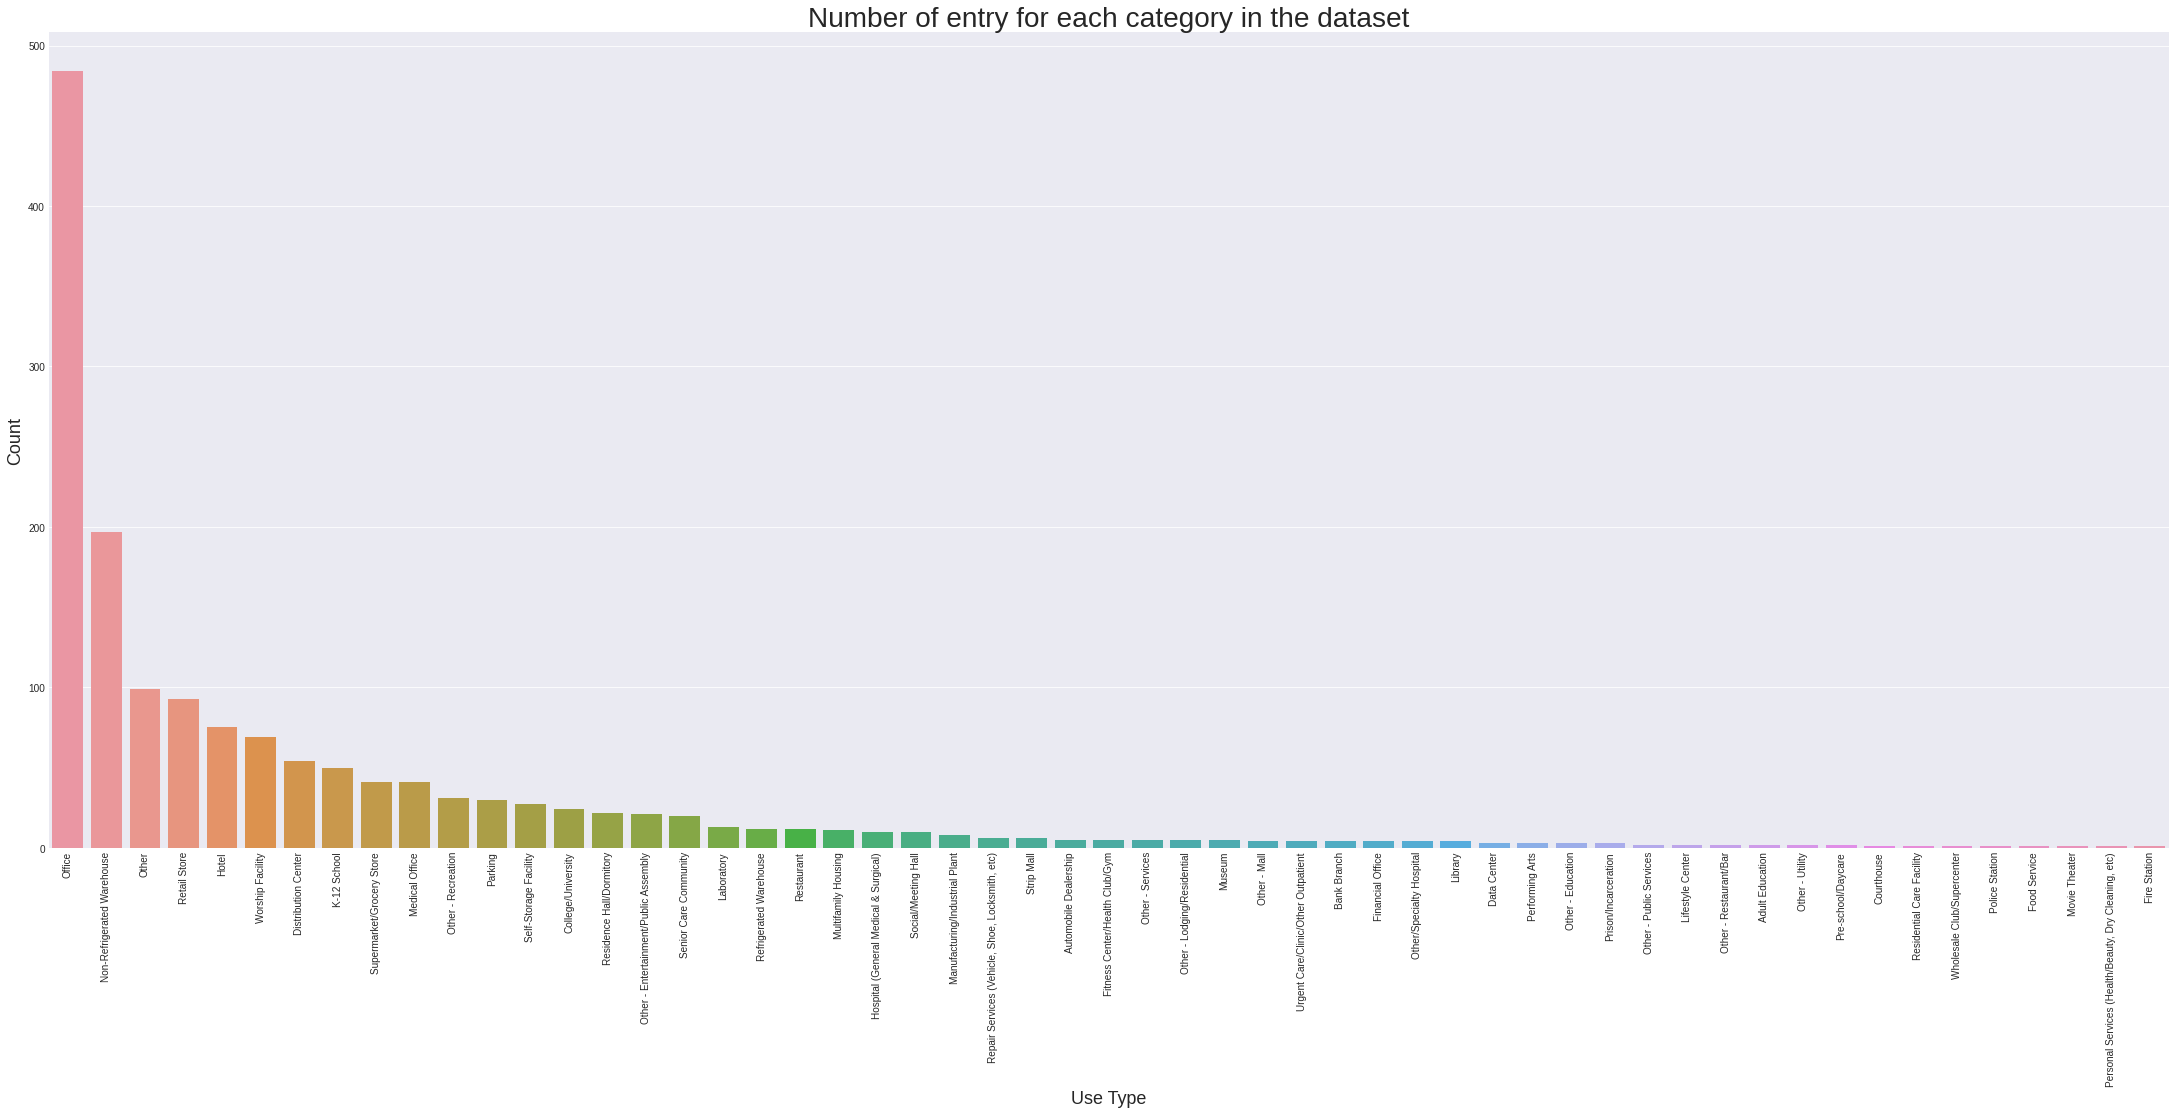

In [37]:
Uses = df_ml["LargestPropertyUseType"].value_counts()
Uses=Uses.to_frame().reset_index()

fig=plt.figure(figsize=(38,15))
sns.barplot(x="index", y="LargestPropertyUseType", data=Uses)
plt.title("Number of entry for each category in the dataset", fontsize=28)
plt.ylabel("Count", fontsize=18)
plt.xlabel("Use Type", fontsize=18)
plt.xticks(rotation=90)

As we can see there is a lot of variant of "Other", for later use we will uniform that. Moreover we see some "Residential" we will dig this

In [38]:
fig = px.scatter_mapbox(df_ml, lat="Latitude", lon="Longitude",color="SiteEUI(kBtu/sf)", hover_data=["LargestPropertyUseType"], size='TotalGHGEmissions')
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Most amount of GHGEmissions are in the center of Seattle, and next to industrial sites (ex: Boeing)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]), <a list of 55 Text major ticklabel objects>)

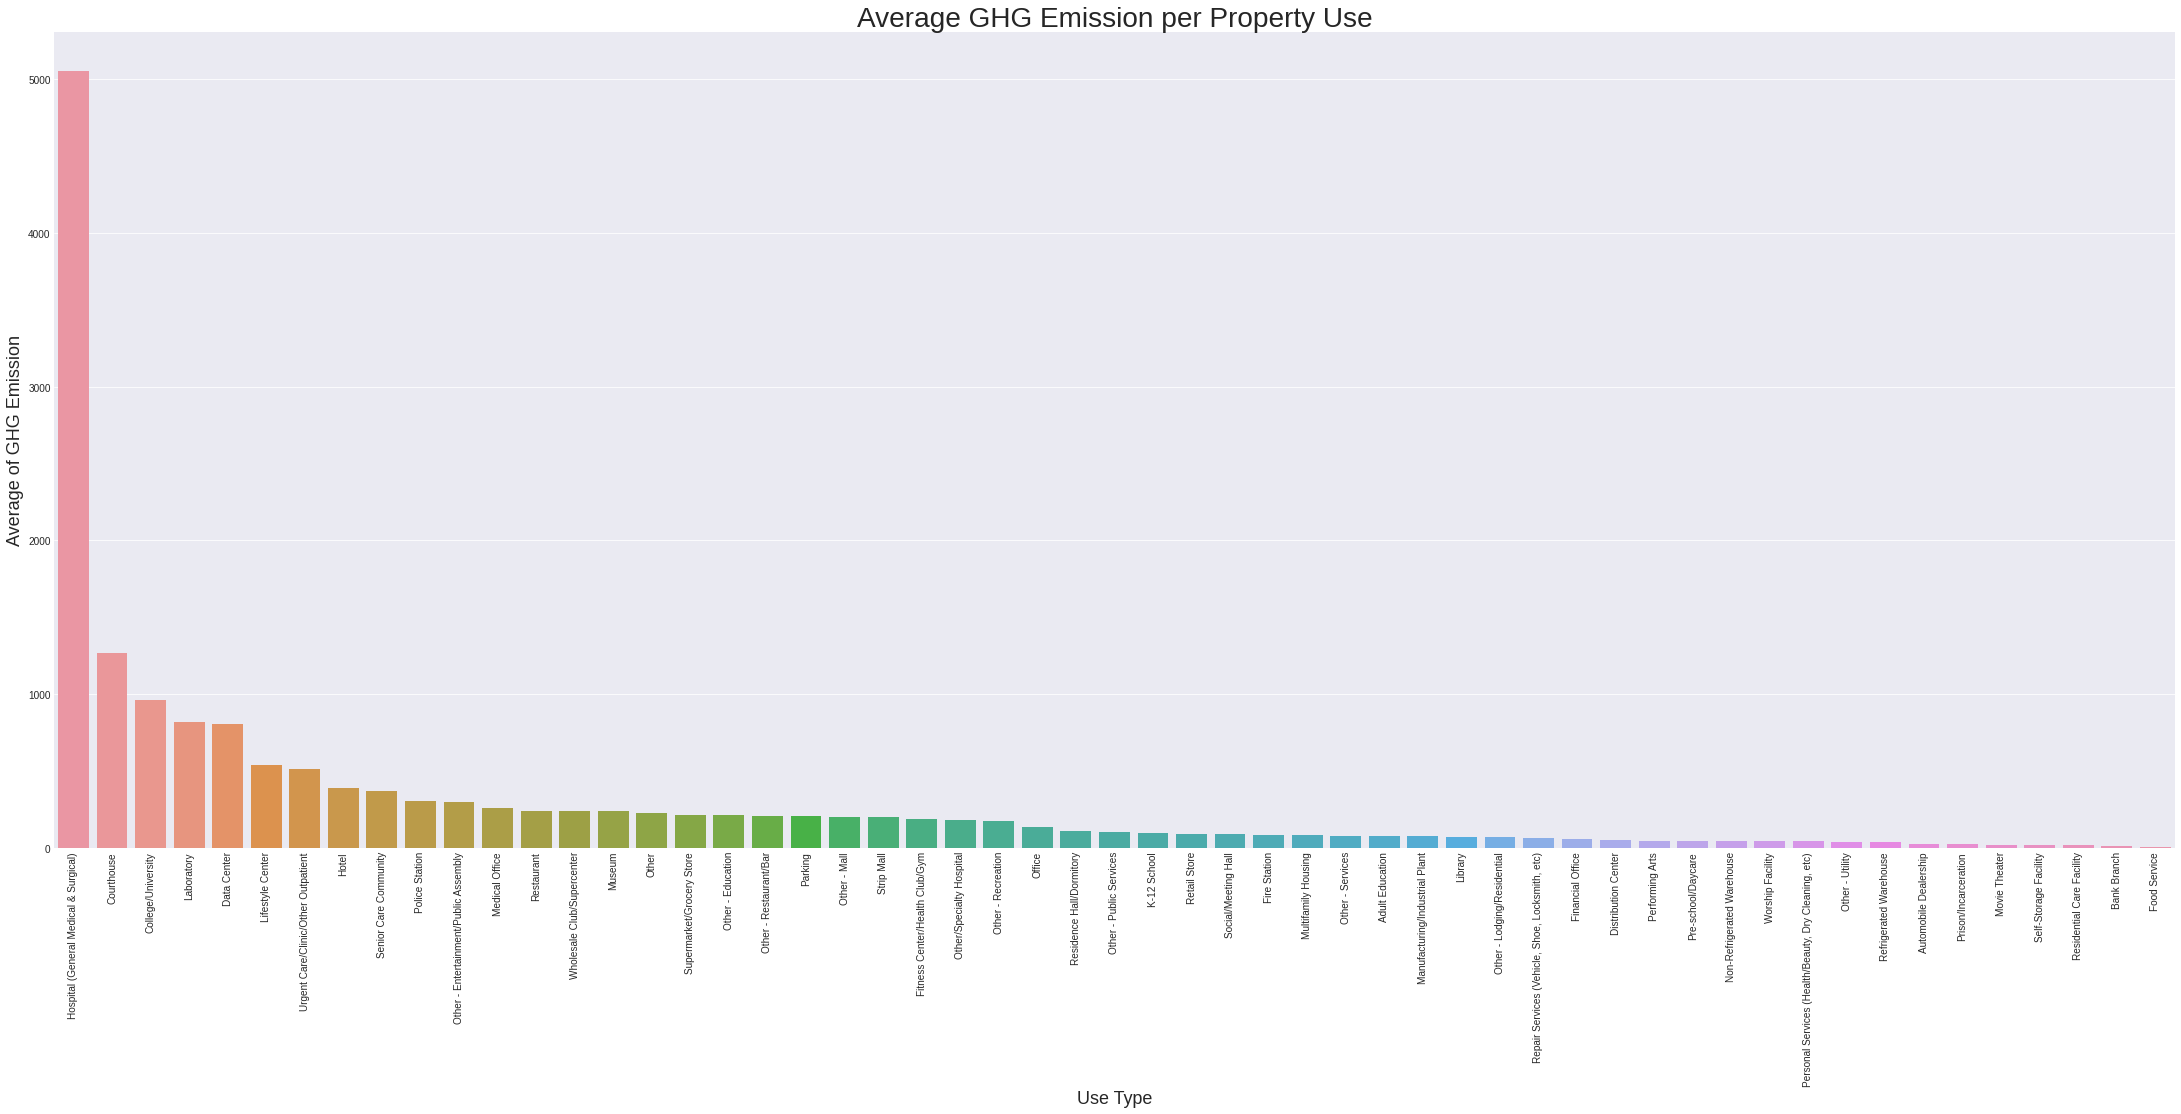

In [39]:
conso=df_ml.groupby(by="LargestPropertyUseType").agg({'TotalGHGEmissions' : 'mean'}).sort_values("TotalGHGEmissions", ascending=False).reset_index()
fig=plt.figure(figsize=(38,15))
sns.barplot(x="LargestPropertyUseType", y="TotalGHGEmissions", data=conso)
plt.title("Average GHG Emission per Property Use", fontsize=28)
plt.ylabel("Average of GHG Emission", fontsize=18)
plt.xlabel("Use Type", fontsize=18)
plt.xticks(rotation=90)

Now we would like to see if GHG Emission scales on GFA 

In [40]:
fig = px.scatter(df_ml, x="PropertyGFATotal", y="TotalGHGEmissions", color="SiteEUI(kBtu/sf)")
fig.show()

As we can see, lower SiteEUI result to less GHG Emission, but it seems there is no real correlation between GHG Emission and Property GFA

In [41]:
fig = px.scatter(df_ml, x="PropertyGFATotal", y="TotalGHGEmissions", color="ENERGYSTARScore")
fig.show()

Higher ENERGYSTAR Score might reduce GHG Emission

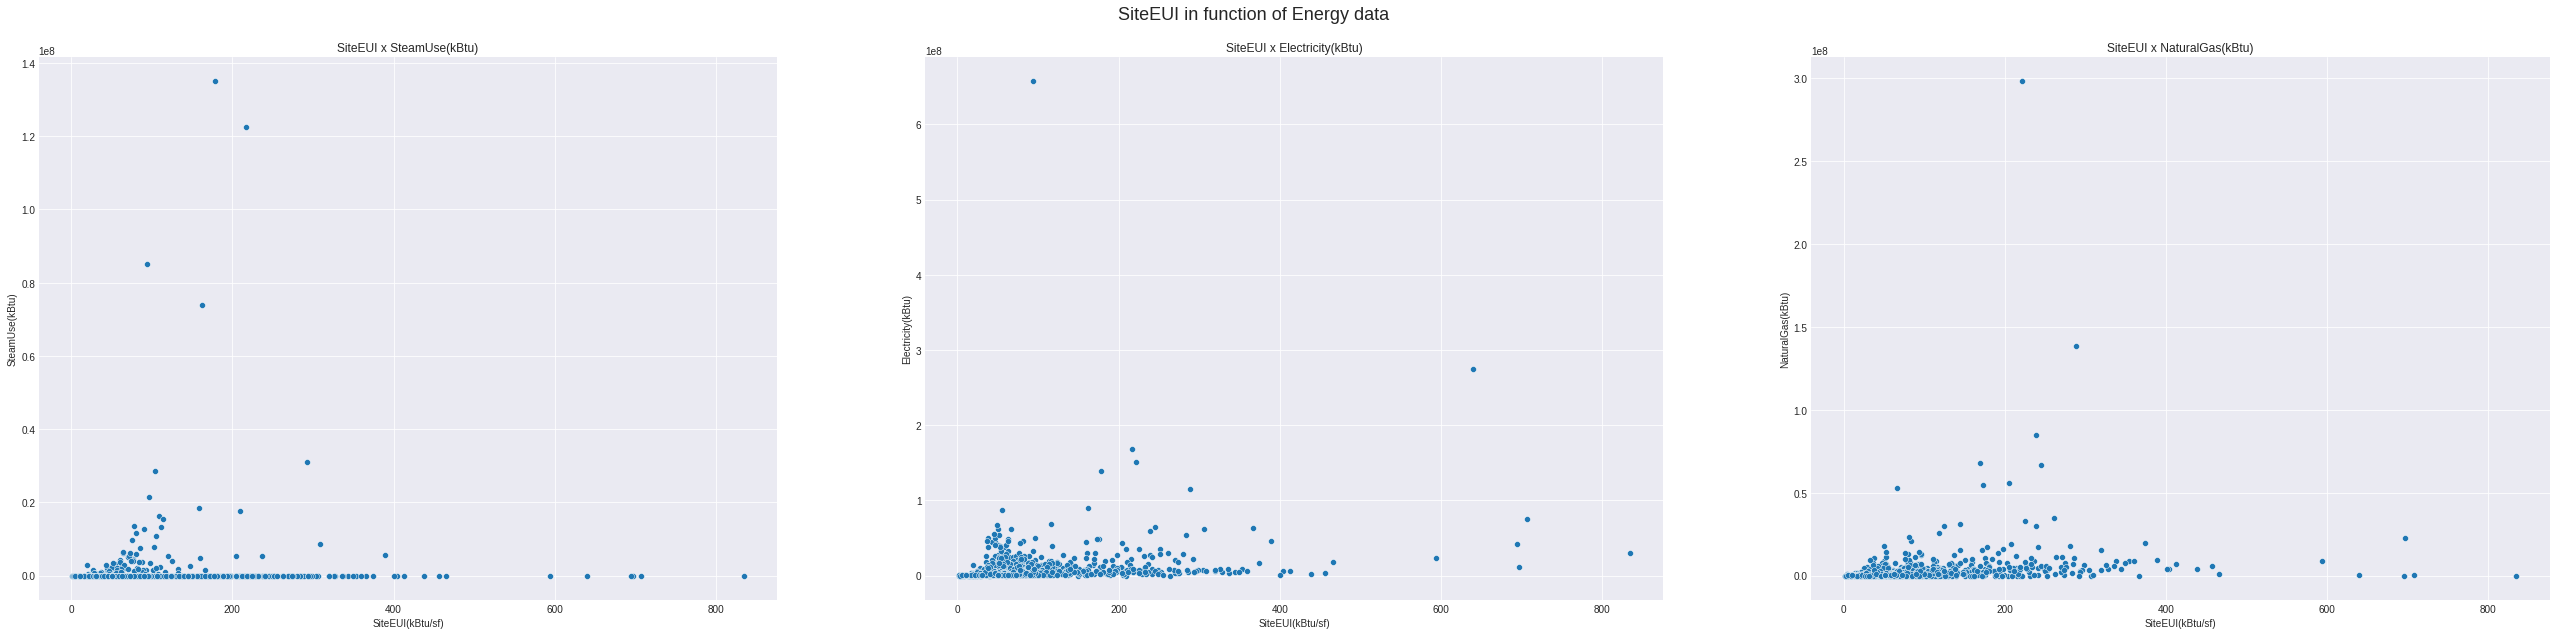

In [42]:
cols_to_pairplot=['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']

fig, ax = plt.subplots(1,3, figsize=(45,10))
ax = ax.ravel()
fig.suptitle("SiteEUI in function of Energy data", fontsize=18, y=0.95)
counter=0
for col in cols_to_pairplot :
    sns.scatterplot(x="SiteEUI(kBtu/sf)", y=col, data=df_ml, ax=ax[counter])
    ax[counter].set_title("SiteEUI"+" x "+ col, fontsize=12)
    counter=counter+1

Steam is not that much used, compared to Electricity and NaturalGas

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]), <a list of 55 Text major ticklabel objects>)

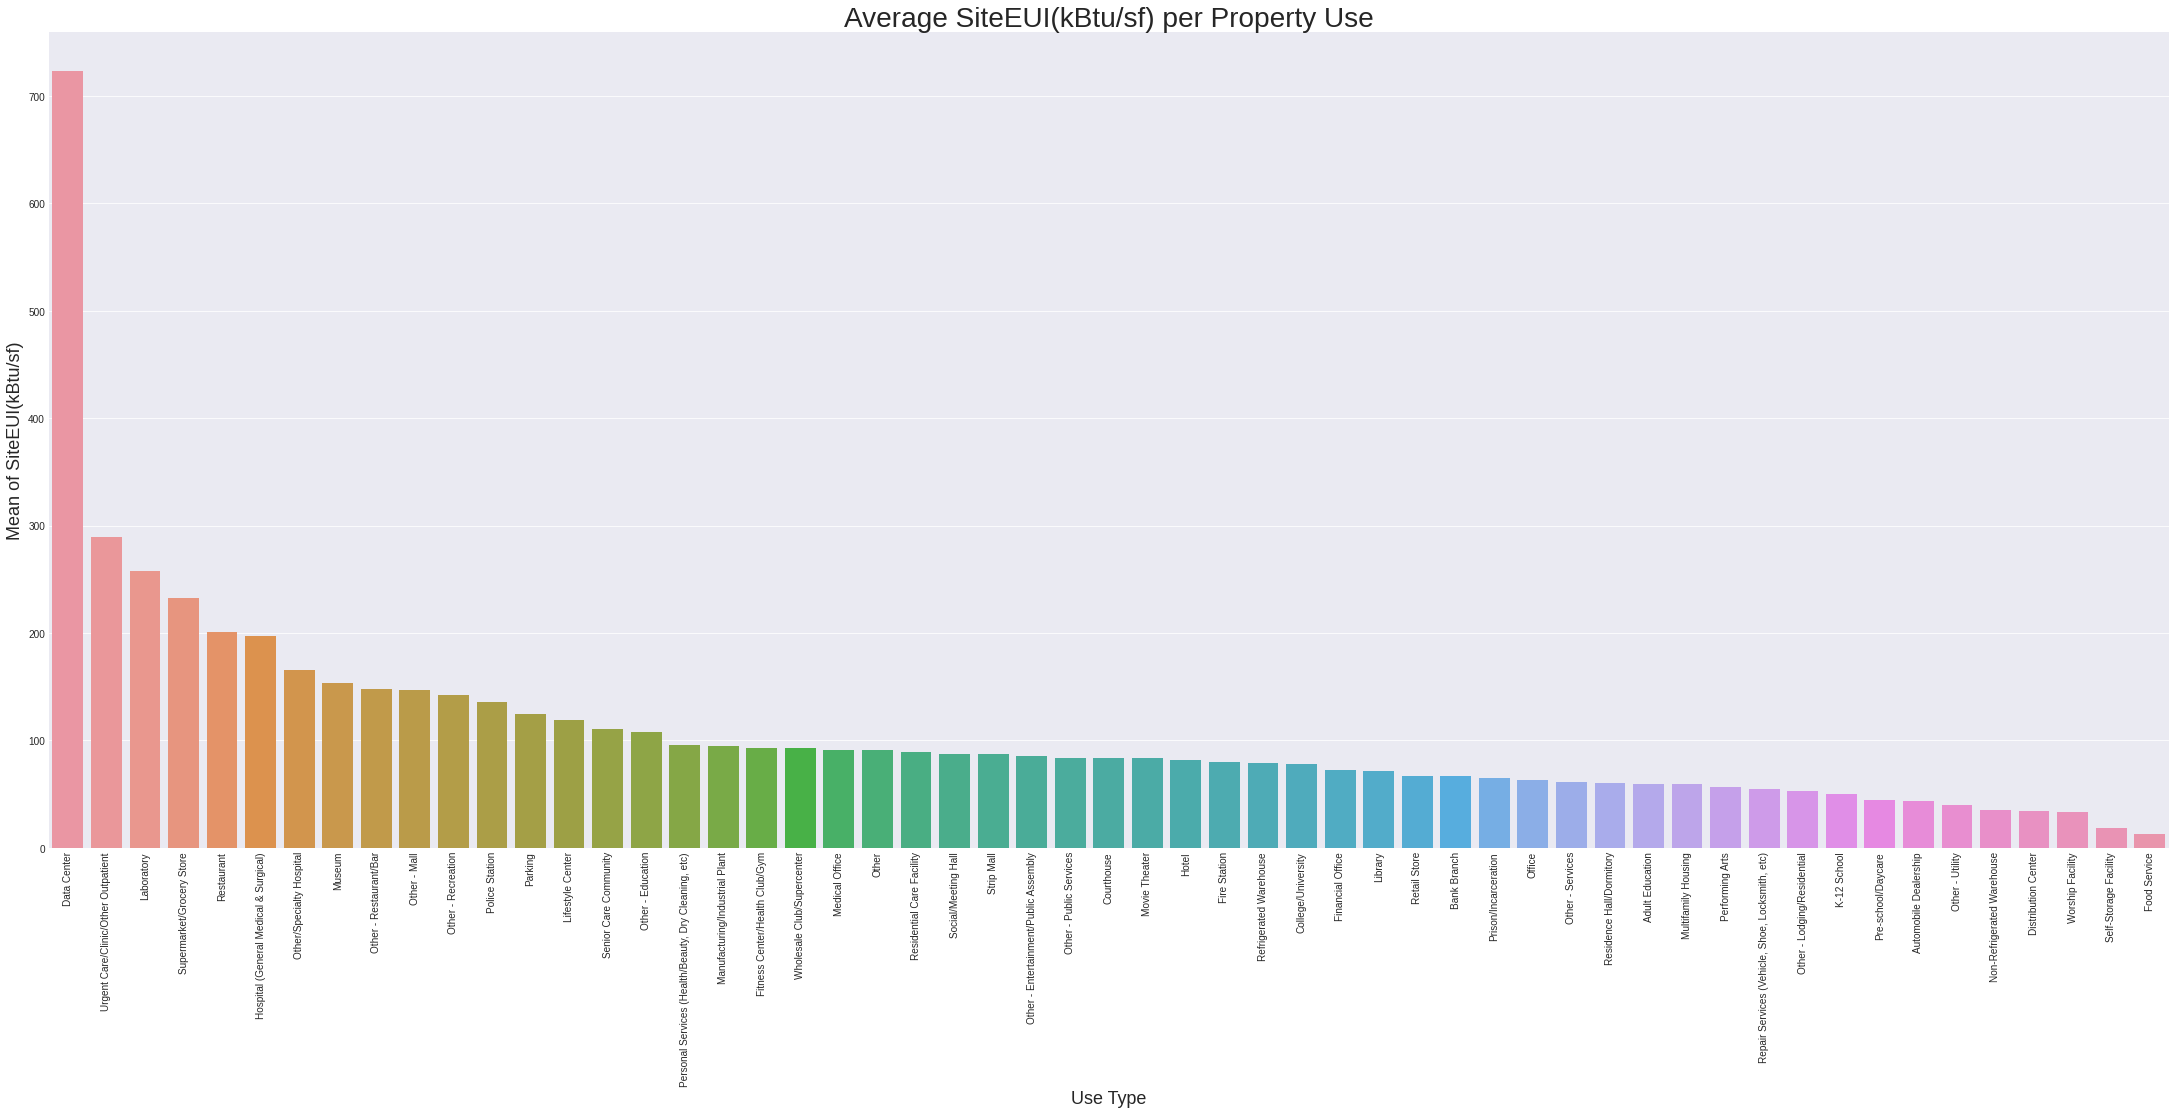

In [43]:
conso_mean=df_ml.groupby(by="LargestPropertyUseType").agg({'SiteEUI(kBtu/sf)' : 'mean'}).sort_values("SiteEUI(kBtu/sf)", ascending=False).reset_index()
fig=plt.figure(figsize=(38,15))
sns.barplot(x="LargestPropertyUseType", y="SiteEUI(kBtu/sf)", data=conso_mean)
plt.title("Average SiteEUI(kBtu/sf) per Property Use", fontsize=28)
plt.ylabel("Mean of SiteEUI(kBtu/sf)", fontsize=18)
plt.xlabel("Use Type", fontsize=18)
plt.xticks(rotation=90)

In [44]:
fig = px.scatter(df_ml, x="PropertyGFATotal", y="SiteEnergyUse(kBtu)", color="ENERGYSTARScore")
fig.show()

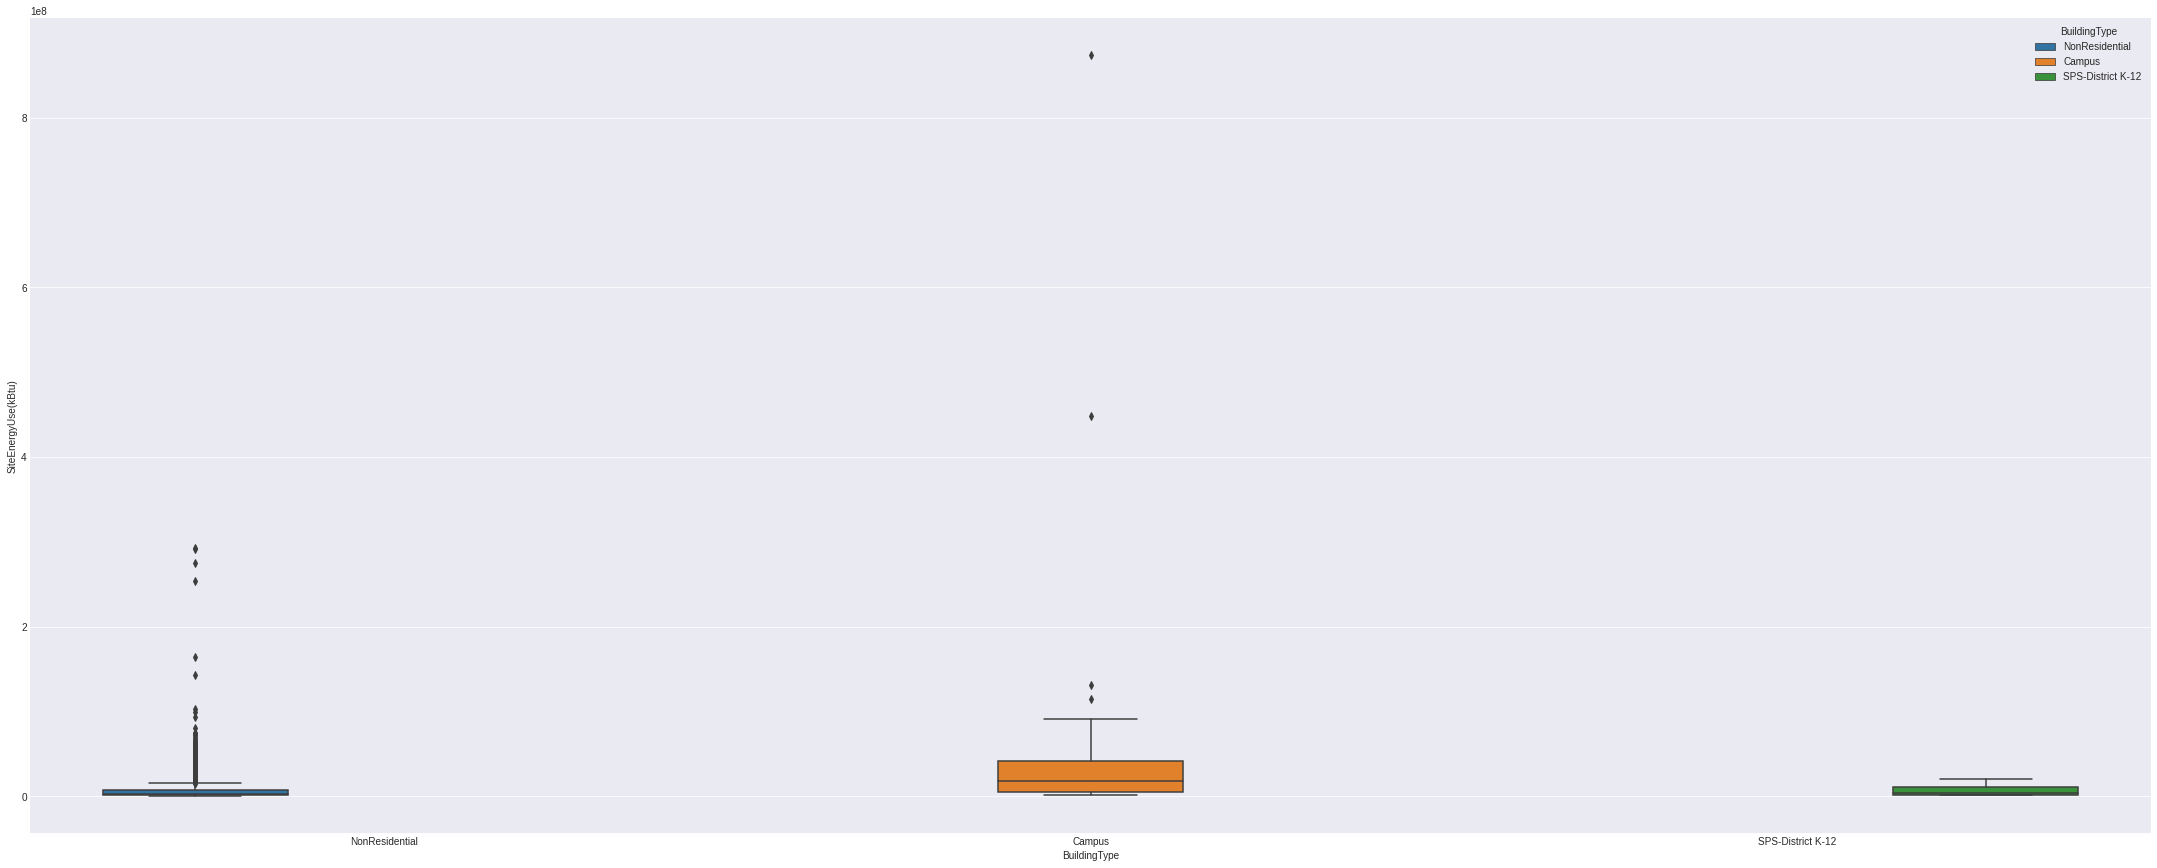

In [45]:
plt.figure(figsize=(38,15))
sns.boxplot(x="BuildingType", y="SiteEnergyUse(kBtu)", hue="BuildingType", data=df_ml, orient='v')

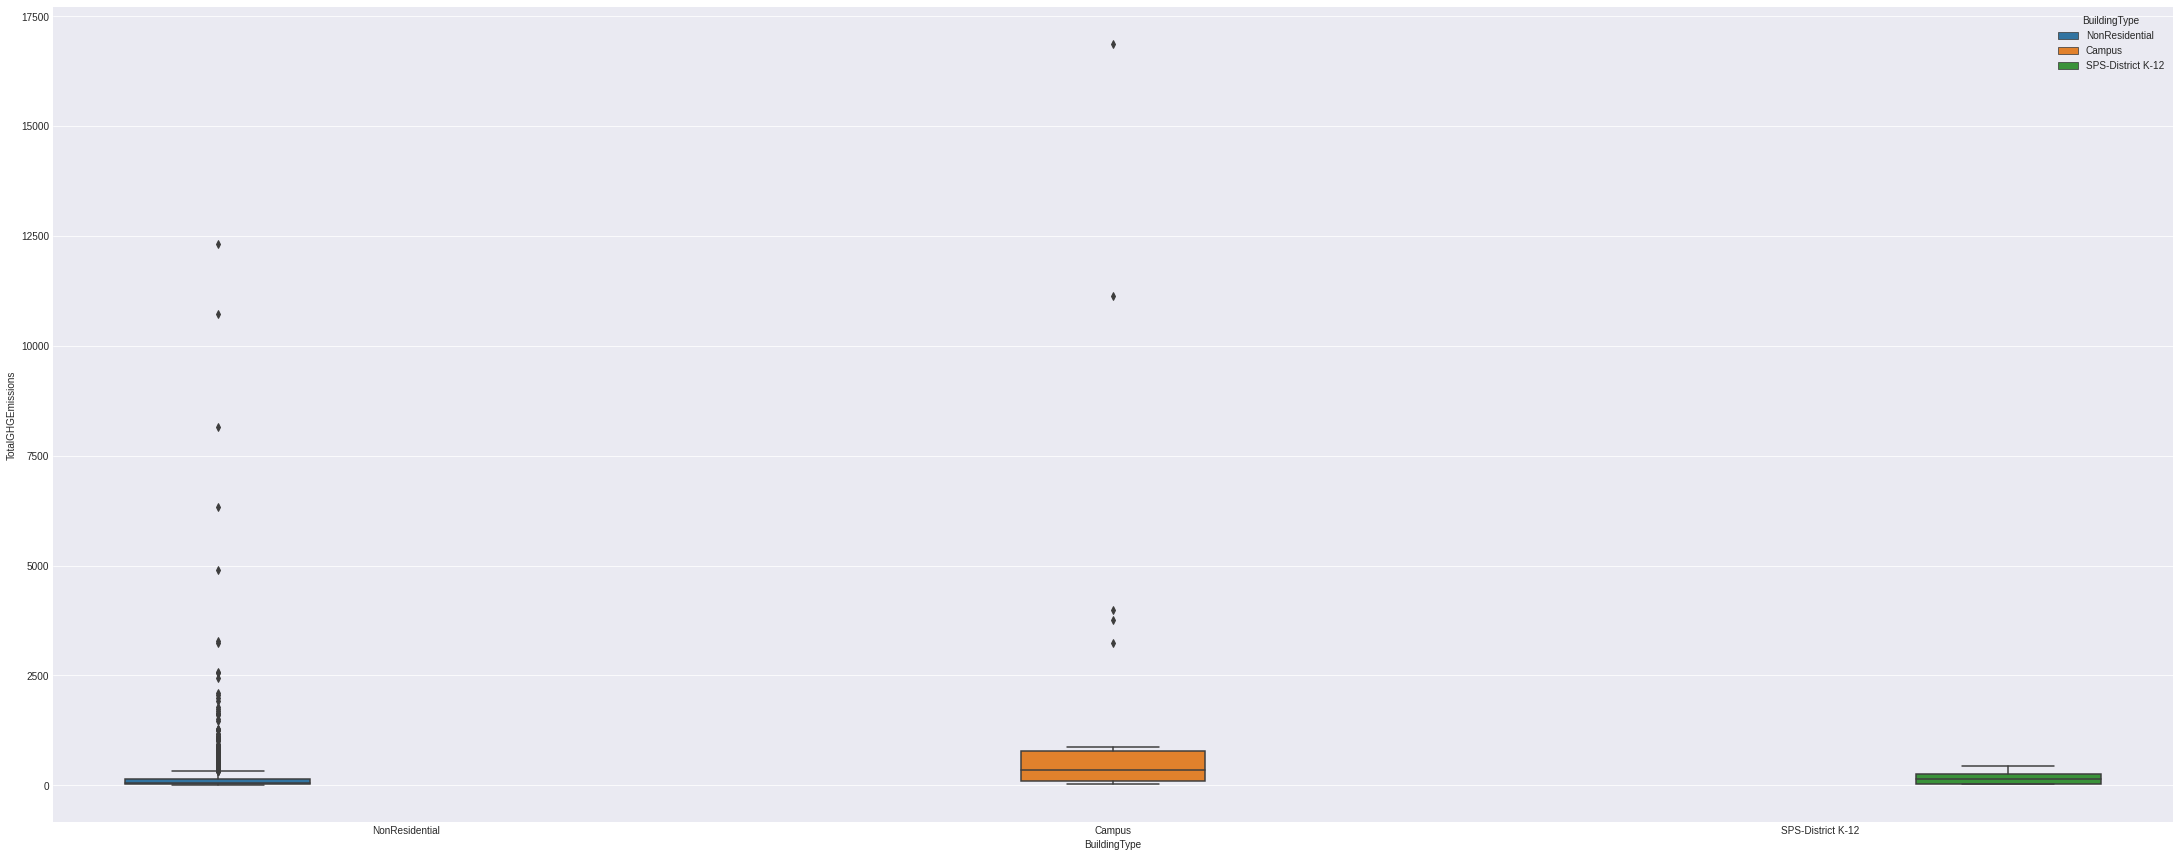

In [46]:
plt.figure(figsize=(38,15))
sns.boxplot(x="BuildingType", y="TotalGHGEmissions", hue="BuildingType", data=df_ml, orient='v')

#Feature Engineering (for both dataframes)


In [47]:
df_ml_pred=df_ml.copy()
df_ml_pred.describe()

Latitude    Longitude    YearBuilt  NumberofBuildings  \
count  1547.000000  1547.000000  1547.000000        1547.000000   
mean     47.616490  -122.333531  1961.610860           1.179056   
std       0.046969     0.023265    32.871597           3.040201   
min      47.509590  -122.411820  1900.000000           0.000000   
25%      47.587840  -122.343045  1930.000000           1.000000   
50%      47.612670  -122.333160  1965.000000           1.000000   
75%      47.649070  -122.322770  1989.000000           1.000000   
max      47.733870  -122.261800  2015.000000         111.000000   

       NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     1547.000000      1.547000e+03         1547.000000   
mean         4.275372      1.213769e+05        13851.285068   
std          6.782744      3.063884e+05        43734.542466   
min          0.000000      1.128500e+04            0.000000   
25%          1.000000      2.884250e+04            0.000000   
50%          2.000000      4.813900e+04            0.000000   
75%          4.000000      1.077510e+05            0.000000   
max         99.000000      9.320156e+06       512608.000000   

       PropertyGFABuilding(s)  LargestPropertyUseTypeGFA  ENERGYSTARScore  \
count            1.547000e+03               1.547000e+03      1547.000000   
mean             1.075256e+05               9.988250e+04        60.641591   
std              2.927185e+05               2.852318e+05        27.091376   
min              3.636000e+03               5.656000e+03         0.000000   
25%              2.793550e+04               2.505850e+04        41.878885   
50%              4.606800e+04               4.212800e+04        64.705681   
75%              9.571050e+04               9.206750e+04        83.000000   
max              9.320156e+06               9.320156e+06       100.000000   

       SiteEUI(kBtu/sf)  SourceEUI(kBtu/sf)  SiteEnergyUse(kBtu)  \
count       1547.000000         1547.000000         1.547000e+03   
mean          75.128054          183.333807         8.865564e+06   
std           75.217277          187.970308         3.131505e+07   
min            1.400000            0.000000         5.713320e+04   
25%           34.900002           81.299999         1.253035e+06   
50%           53.799999          138.699997         2.735166e+06   
75%           85.199997          213.699997         7.298149e+06   
max          834.400024         2620.000000         8.739237e+08   

       SteamUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
count    1.547000e+03       1.547000e+03      1.547000e+03        1547.000000   
mean     5.515393e+05       6.144885e+06      2.039614e+06         193.734577   
std      5.720334e+06       2.151708e+07      9.713668e+06         779.341518   
min      0.000000e+00       0.000000e+00      0.000000e+00           0.000000   
25%      0.000000e+00       7.320410e+05      0.000000e+00          20.710000   
50%      0.000000e+00       1.747974e+06      4.902260e+05          49.900000   
75%      0.000000e+00       5.265402e+06      1.530936e+06         147.315000   
max      1.349435e+08       6.570744e+08      2.979090e+08       16870.980000   

       GHGEmissionsIntensity  
count            1547.000000  
mean                1.668449  
std                 2.407973  
min                 0.000000  
25%                 0.360000  
50%                 0.880000  
75%                 1.960000  
max                34.090000

Get 2 new features, GFA per floors and per buildings

In [48]:
df_ml_pred['NumberofFloors']=df_ml_pred['NumberofFloors'].replace(0,1)
df_ml_pred['NumberofBuildings']=df_ml_pred['NumberofBuildings'].replace(0,1)
df_ml_pred['Sfloor']=df_ml_pred['PropertyGFABuilding(s)']/(df_ml_pred['NumberofFloors'])
df_ml_pred['SBuild']=df_ml_pred['PropertyGFABuilding(s)']/(df_ml_pred['NumberofBuildings'])

df_wo['NumberofFloors']=df_wo['NumberofFloors'].replace(0,1)
df_wo['NumberofBuildings']=df_wo['NumberofBuildings'].replace(0,1)
df_wo['Sfloor']=df_wo['PropertyGFABuilding(s)']/(df_wo['NumberofFloors'])
df_wo['SBuild']=df_wo['PropertyGFABuilding(s)']/(df_wo['NumberofBuildings'])

Switching column YearBuilt to AgeBuild (Age of the building)

In [49]:
df_ml_pred['AgeBuild']= datetime.datetime.now().year - df_ml_pred['YearBuilt']
df_ml_pred=df_ml_pred.drop(columns=['YearBuilt'])

df_wo['AgeBuild']= datetime.datetime.now().year - df_wo['YearBuilt']
df_wo=df_wo.drop(columns=['YearBuilt'])

Get rate of ParkingGFA & BuildingGFA vs TotalGFA

In [50]:
df_ml_pred['ParkGFARate']=df_ml_pred['PropertyGFAParking']/df_ml_pred['PropertyGFATotal']
df_ml_pred['BuildGFARate']=df_ml_pred['PropertyGFABuilding(s)']/df_ml_pred['PropertyGFATotal']

df_wo['ParkGFARate']=df_wo['PropertyGFAParking']/df_wo['PropertyGFATotal']
df_wo['BuildGFARate']=df_wo['PropertyGFABuilding(s)']/df_wo['PropertyGFATotal']

Rate of largest use vs total

In [51]:
df_ml_pred['LargestUseGFARate']=df_ml_pred['LargestPropertyUseTypeGFA']/df_ml_pred['PropertyGFATotal']

df_wo['LargestUseGFARate']=df_wo['LargestPropertyUseTypeGFA']/df_wo['PropertyGFATotal']

There is a huge variability in ListofAllPropertyUseTypes, it will not be easy to use a one hot encoder on this so we transform text to numbers.

In [52]:
def split_words(df, column = None):
  list_words = set()
  for word in df[column].str.split(','):
    if isinstance(word, float):
      continue
    list_words = set().union(word, list_words)
  return list(list_words)

list_use_type = split_words(df_ml_pred, 'ListOfAllPropertyUseTypes')
print("Nombre de type d'usages dans la base : {}".format(len(list_use_type)))
df_ml_pred['UseTypesNb'] = [str(word).count(",") + 1 for word in df_ml_pred['ListOfAllPropertyUseTypes'].str.split(',')]
df_ml_pred=df_ml_pred.drop(columns=['ListOfAllPropertyUseTypes'])


df_wo['UseTypesNb'] = [str(word).count(",") + 1 for word in df_wo['ListOfAllPropertyUseTypes'].str.split(',')]
df_wo=df_wo.drop(columns=['ListOfAllPropertyUseTypes'])

Nombre de type d'usages dans la base : 115


With the same mindset let's reduce variability in LargestPropertyUseType columns

In [53]:
for index, row in df_ml_pred.iterrows():
  x=row['LargestPropertyUseType']
  if "Other" in x :
    df_ml_pred.at[index, 'LargestPropertyUseType']="Other"


for index, row in df_wo.iterrows():
  x=row['LargestPropertyUseType']
  if "Other" in x :
    df_wo.at[index, 'LargestPropertyUseType']="Other"

If we agree that proportion of energy will be the same for a building we can create 3 new columns.

In [55]:
df_ml_pred['Ratio_Elec']=df_ml_pred['Electricity(kBtu)']/df_ml_pred['SiteEnergyUse(kBtu)']
df_ml_pred['Ratio_Steam']=df_ml_pred['SteamUse(kBtu)']/df_ml_pred['SiteEnergyUse(kBtu)']
df_ml_pred['Ratio_Gas']=df_ml_pred['NaturalGas(kBtu)']/df_ml_pred['SiteEnergyUse(kBtu)']

df_wo['Ratio_Elec']=df_wo['Electricity(kBtu)']/df_wo['SiteEnergyUse(kBtu)']
df_wo['Ratio_Steam']=df_wo['SteamUse(kBtu)']/df_wo['SiteEnergyUse(kBtu)']
df_wo['Ratio_Gas']=df_wo['NaturalGas(kBtu)']/df_wo['SiteEnergyUse(kBtu)']

We do not need Latitude and longitude anymore so we dropping them, as well as features used to create new ones

In [59]:
df_ml_pred.drop(columns=['Longitude', 'Latitude', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'PropertyGFATotal'], inplace=True)

df_wo.drop(columns=['Longitude', 'Latitude', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'PropertyGFATotal'], inplace=True)

We're trying to predict TotalGHGEmission and SiteEnergyUse(kBtu) only based on building specs so let's drop energy information

In [60]:
df_ml_pred.drop(columns=['SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'GHGEmissionsIntensity', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'], inplace=True)

df_wo.drop(columns=['SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'GHGEmissionsIntensity', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'], inplace=True)

As we ended creating new features, and we will now begin to prepare final data to regression models, we've to check multi colinearity.

We will use the Variance Inflation Factor

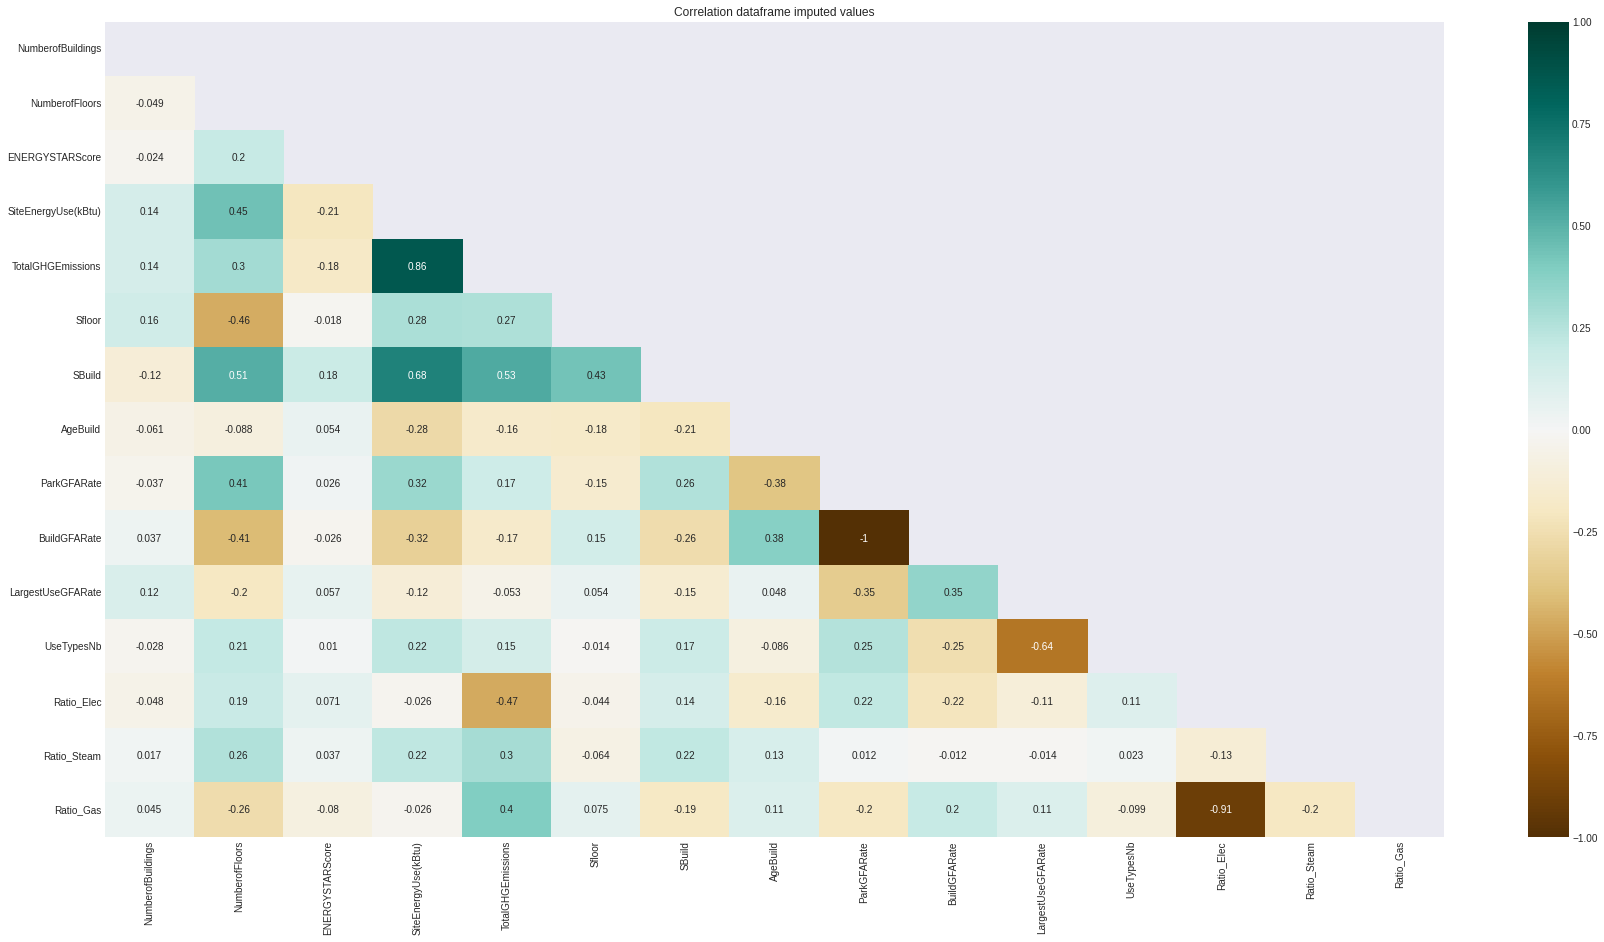

In [61]:
mask_2 = np.triu(np.ones_like(df_ml_pred.corr(), dtype=np.bool))

plt.figure(figsize=(30,15))
sns.heatmap(df_ml_pred.corr(method="spearman"), annot=True, vmin=-1, vmax=1, mask=mask_2,cmap='BrBG')
plt.title("Correlation dataframe imputed values")
plt.show()

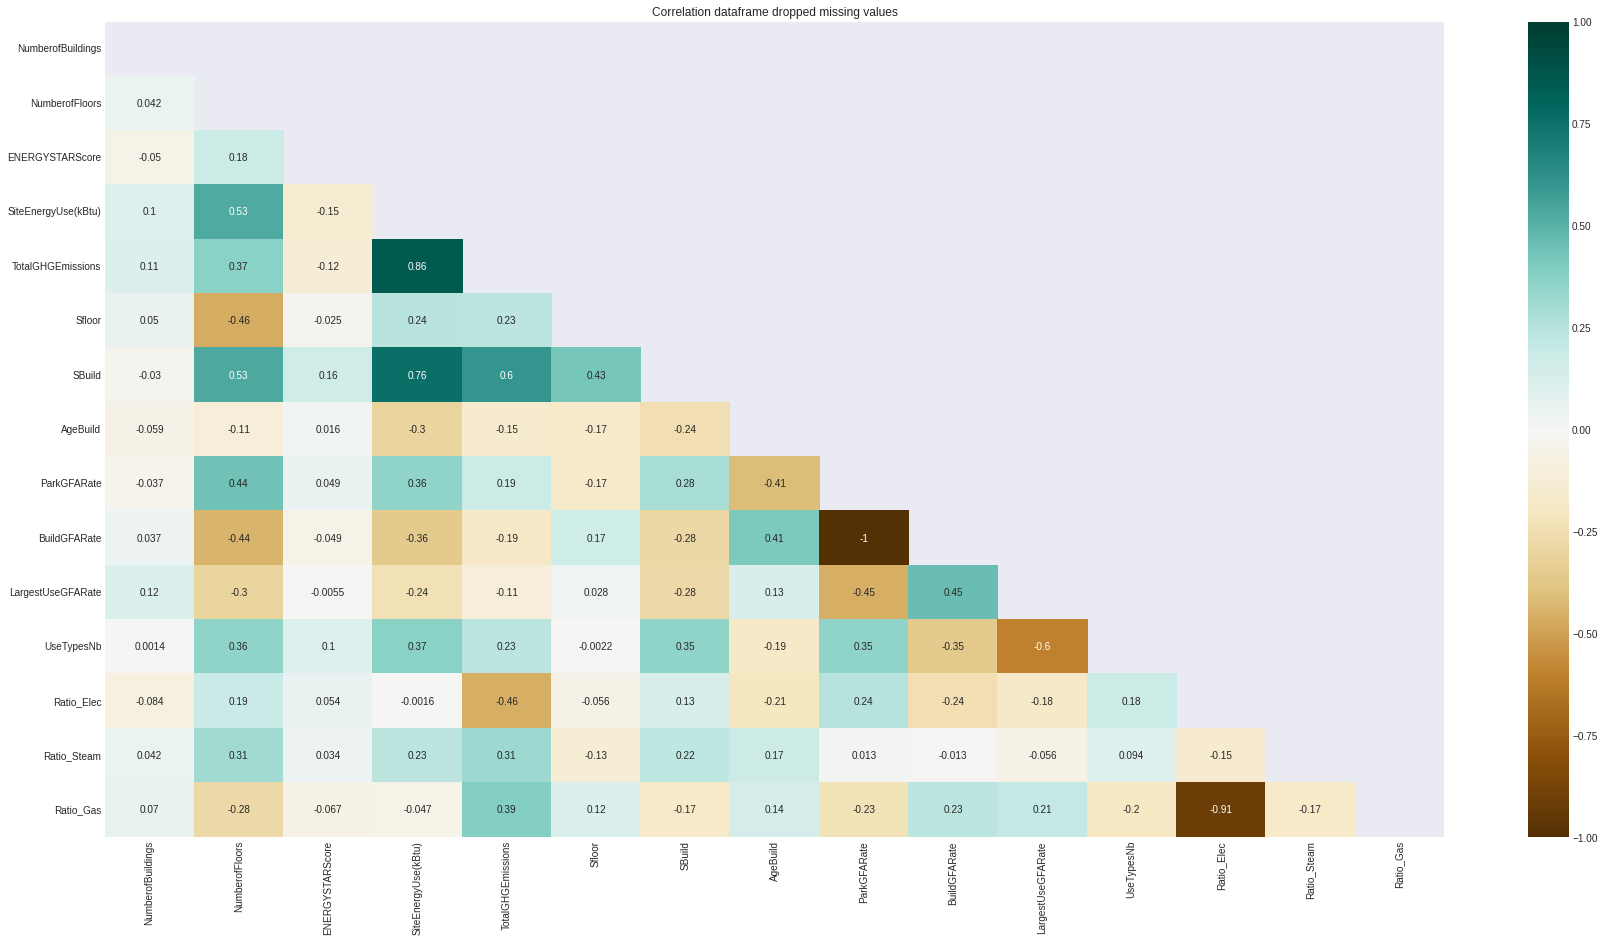

In [62]:
mask_2 = np.triu(np.ones_like(df_wo.corr(), dtype=np.bool))

plt.figure(figsize=(30,15))
sns.heatmap(df_wo.corr(method="spearman"), annot=True, vmin=-1, vmax=1, mask=mask_2,cmap='BrBG')
plt.title("Correlation dataframe dropped missing values")
plt.show()

We have lot of feature with high correlation we need to clear these

In [63]:
###Imputed values

threshold = 0.7
corr_pairs = df_ml_pred.corr().unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

level_0              level_1  corr_coeff
10               Sfloor    NumberofBuildings    0.915827
8   SiteEnergyUse(kBtu)    TotalGHGEmissions    0.860017
6                Sfloor  SiteEnergyUse(kBtu)    0.731654
4     NumberofBuildings  SiteEnergyUse(kBtu)    0.716119
2            Ratio_Elec            Ratio_Gas   -0.921565
0          BuildGFARate          ParkGFARate   -1.000000

In [64]:
###Imputed values

from statsmodels.stats.outliers_influence import variance_inflation_factor

strong_corr_features = list(set(list(strong_corr['level_0'].values) + list(strong_corr['level_1'].values)))
X = df_ml_pred[strong_corr_features].replace([np.inf, -np.inf], np.nan)
X = X.dropna()

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                   for i in range(len(X.columns))]
vif_data[vif_data['VIF'] > 5]

feature        VIF
0               Sfloor   8.284609
2            Ratio_Gas   6.857717
3    NumberofBuildings   6.395554
4           Ratio_Elec   7.108069
5  SiteEnergyUse(kBtu)  13.333729
6         BuildGFARate  84.645460
7    TotalGHGEmissions   7.447103

These 4 features have high correlation which is nice because 2 of them are our future targets

In [65]:
###Dropped values
threshold = 0.7
corr_pairs = df_wo.corr().unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

level_0              level_1  corr_coeff
6  TotalGHGEmissions  SiteEnergyUse(kBtu)    0.920741
4     NumberofFloors               SBuild    0.735708
2         Ratio_Elec            Ratio_Gas   -0.921317
0       BuildGFARate          ParkGFARate   -1.000000

We see here that there is less high correlated features than in the imputed dataset

In [66]:
###Dropped missing values

from statsmodels.stats.outliers_influence import variance_inflation_factor

strong_corr_features = list(set(list(strong_corr['level_0'].values) + list(strong_corr['level_1'].values)))
X = df_wo[strong_corr_features].replace([np.inf, -np.inf], np.nan)
X = X.dropna()

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                   for i in range(len(X.columns))]
vif_data[vif_data['VIF'] > 5]

feature        VIF
2            Ratio_Gas   7.148466
4           Ratio_Elec   7.353389
5         BuildGFARate  86.908470
6  SiteEnergyUse(kBtu)  10.673588
7    TotalGHGEmissions   9.523178

It's the same here, only our future targets have a VIF higher than 5

Applying a log Transformation

In [68]:
skewness_check=['NumberofBuildings', 'NumberofFloors',
       'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'Sfloor',
       'SBuild', 'AgeBuild', 'ParkGFARate', 'BuildGFARate',
       'LargestUseGFARate', 'UseTypesNb', 'Ratio_Elec', 'Ratio_Steam',
       'Ratio_Gas']

In [69]:
for col in df_ml_pred.columns :
  if col in skewness_check :
    df_ml_pred[col]=np.log(df_ml_pred[col]+1)

np.isfinite(df_ml_pred[skewness_check]).sum()

NumberofBuildings      1547
NumberofFloors         1547
ENERGYSTARScore        1547
SiteEnergyUse(kBtu)    1547
TotalGHGEmissions      1547
Sfloor                 1547
SBuild                 1547
AgeBuild               1547
ParkGFARate            1547
BuildGFARate           1547
LargestUseGFARate      1547
UseTypesNb             1547
Ratio_Elec             1547
Ratio_Steam            1547
Ratio_Gas              1547
dtype: int64

In [70]:
for col in df_ml_pred.columns :
  if col in skewness_check :
    df_wo[col]=np.log(df_wo[col]+1)

np.isfinite(df_wo[skewness_check]).sum()

NumberofBuildings      996
NumberofFloors         996
ENERGYSTARScore        996
SiteEnergyUse(kBtu)    996
TotalGHGEmissions      996
Sfloor                 996
SBuild                 996
AgeBuild               996
ParkGFARate            996
BuildGFARate           996
LargestUseGFARate      996
UseTypesNb             996
Ratio_Elec             996
Ratio_Steam            996
Ratio_Gas              996
dtype: int64

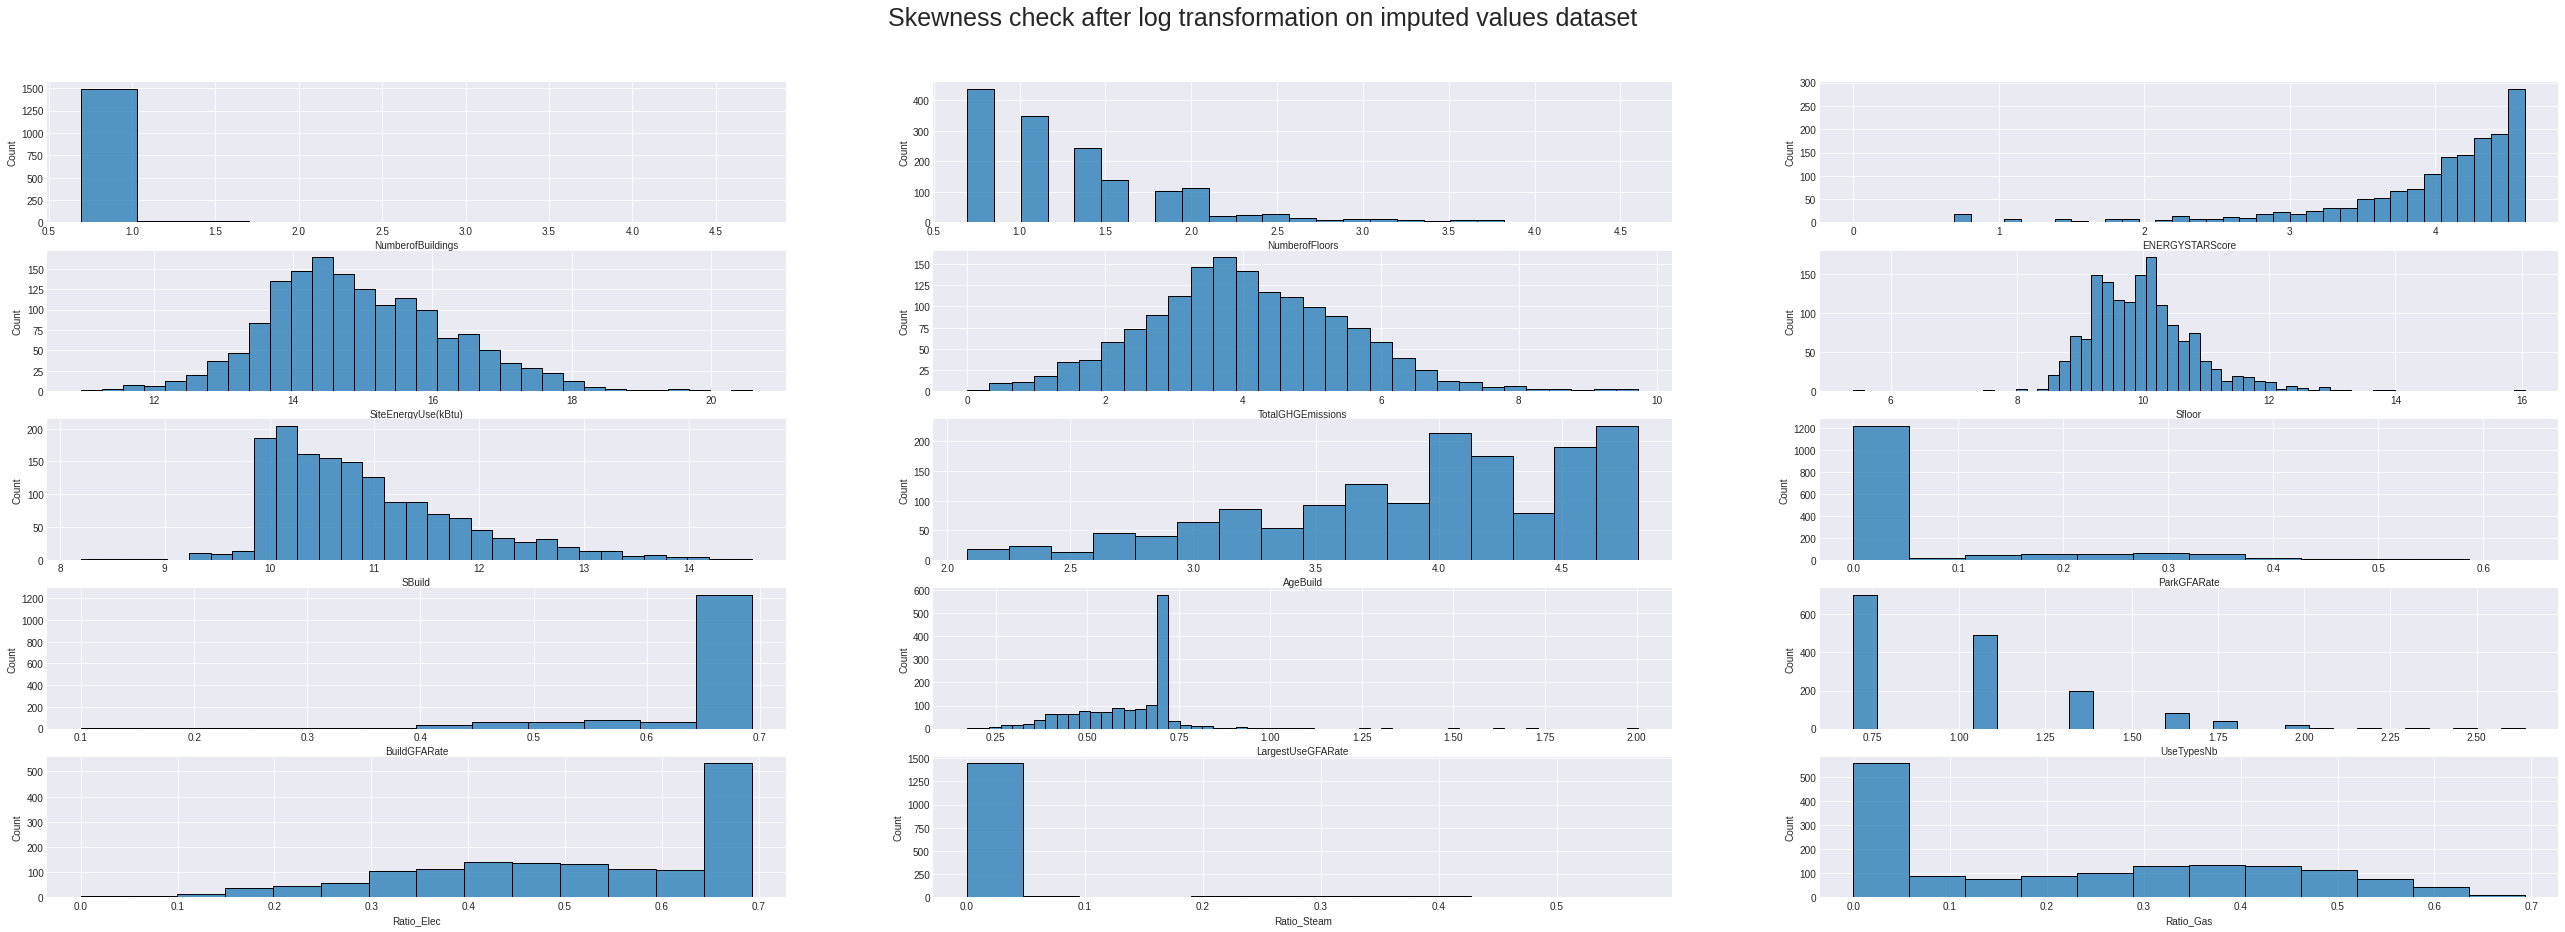

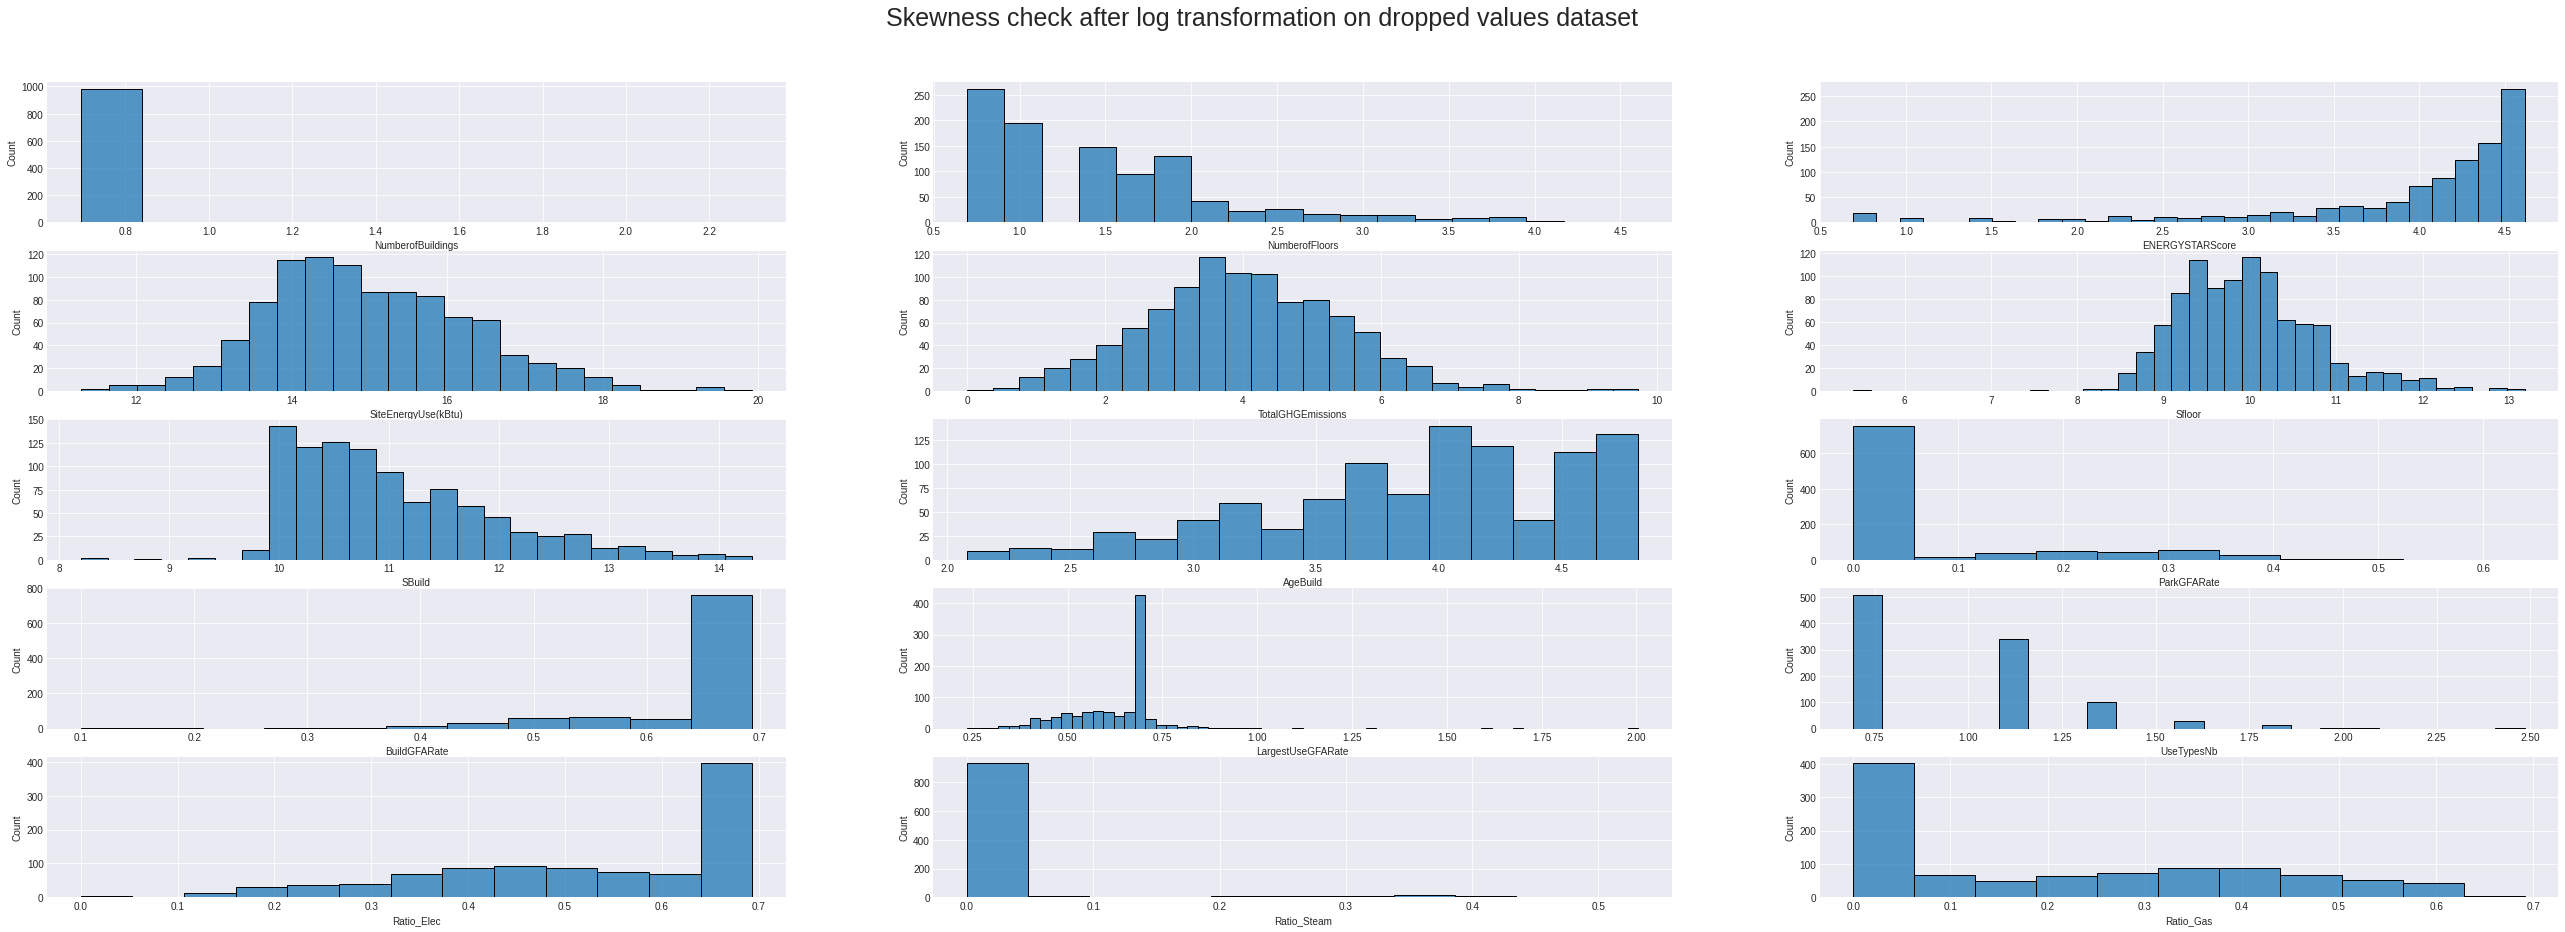

In [71]:
fig, ax = plt.subplots(5,3, figsize=(45,15))
ax = ax.ravel()
fig.suptitle("Skewness check after log transformation on imputed values dataset", fontsize=25, y=0.95)
counter=0
for col in skewness_check :
    sns.histplot(x=col, data=df_ml_pred, ax=ax[counter])
    counter=counter+1
plt.show()

fig, ax = plt.subplots(5,3, figsize=(45,15))
ax = ax.ravel()
fig.suptitle("Skewness check after log transformation on dropped values dataset", fontsize=25, y=0.95)
counter=0
for col in skewness_check :
    sns.histplot(x=col, data=df_wo, ax=ax[counter])
    counter=counter+1
plt.show()

We've have almost identical distribution on both dataset after log transformation

In [72]:
df_ml_pred.to_csv("/content/gdrive/MyDrive/Prep_data_ml_imputed.csv", sep=",")
df_wo.to_csv("/content/gdrive/MyDrive/Prep_data_ml_dropped.csv", sep=",")

#PREDICTION OF TotalGHGEmissions with Imputed values in ENERGYSTARScore

Firstly we will try to predict GHGEmission.

After setting up our X and y , we will perform a nested cross validation to try out different models and we will compare their R2 and RMSE metrics to a baseline error. 

We will use sklearn's DummyRegressor to get this baseline error. 

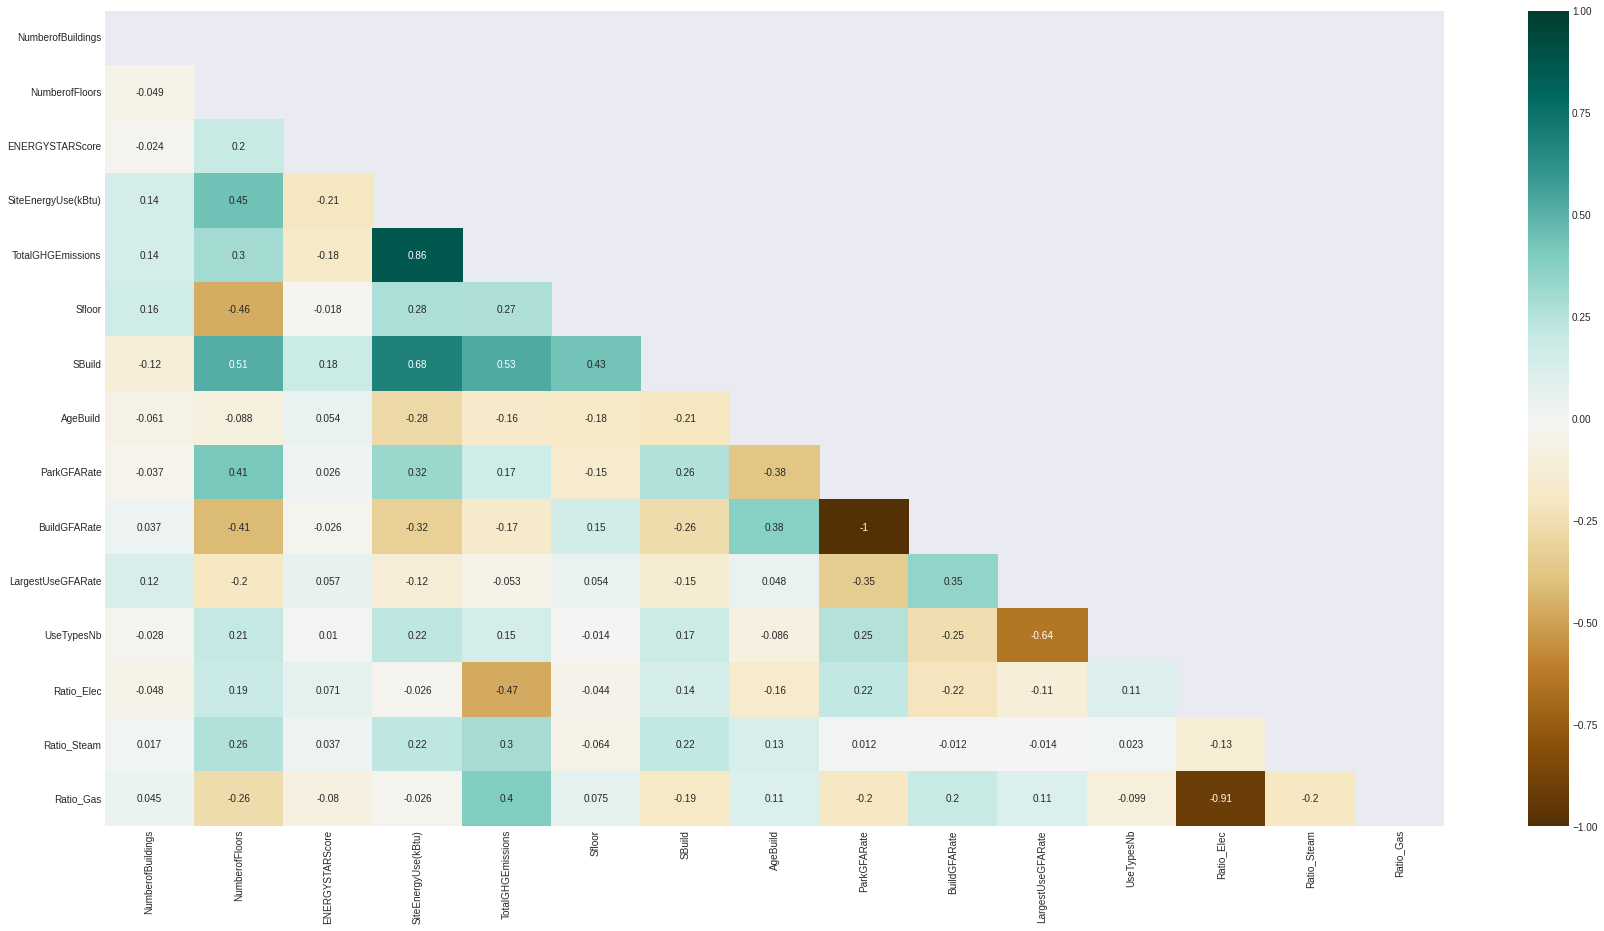

In [73]:
mask_2 = np.triu(np.ones_like(df_ml_pred.corr(), dtype=np.bool))

plt.figure(figsize=(30,15))
sns.heatmap(df_ml_pred.corr(method="spearman"), annot=True, vmin=-1, vmax=1, mask=mask_2,cmap='BrBG')
plt.show()

We create a new df

In [80]:
X = df_ml_pred.drop(columns=['SiteEnergyUse(kBtu)'])


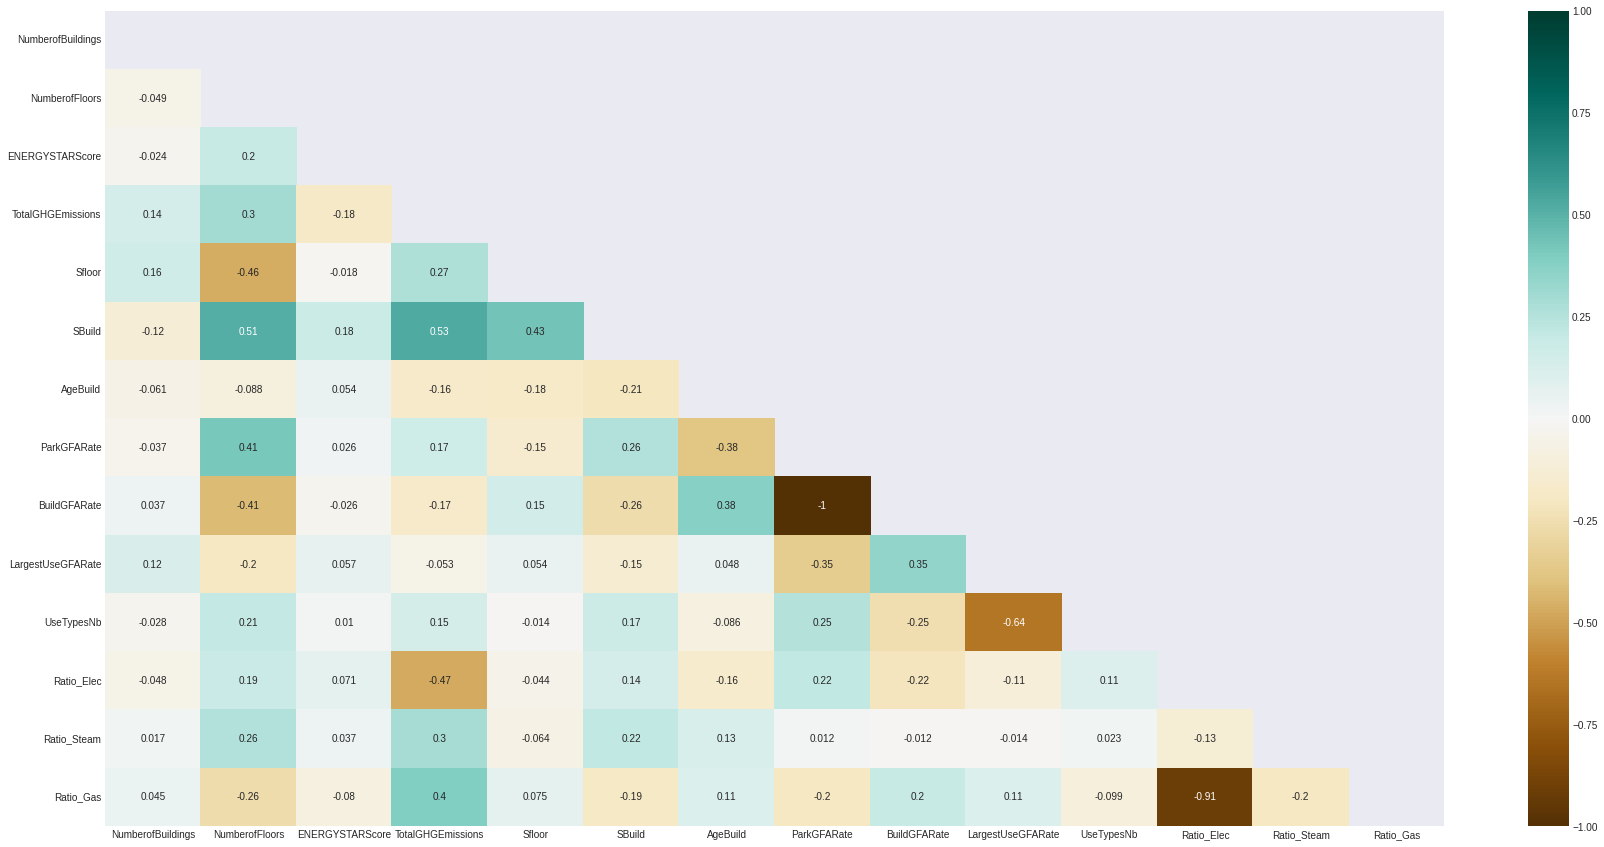

In [75]:
mask_2 = np.triu(np.ones_like(X.corr(), dtype=np.bool))

plt.figure(figsize=(30,15))
sns.heatmap(X.corr(method="spearman"), annot=True, vmin=-1, vmax=1, mask=mask_2,cmap='BrBG')
plt.show()

Encoding categorical features with OneHotEncoder and Normalizing numericals one

In [81]:
enc = OneHotEncoder(handle_unknown='ignore')
cat_X = pd.DataFrame(enc.fit_transform(X[['ESS_miss', 'BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'LargestPropertyUseType']]).toarray(), columns=enc.get_feature_names_out())
X=pd.concat([cat_X, X.iloc[:,5:19]], axis=1)
X.iloc[:, 89:103]=StandardScaler().fit_transform(X.iloc[:, 89:103])
X.head(5)

ESS_miss_n  ESS_miss_y  BuildingType_Campus  BuildingType_NonResidential  \
0         1.0         0.0                  0.0                          1.0   
1         1.0         0.0                  0.0                          1.0   
2         1.0         0.0                  0.0                          1.0   
3         1.0         0.0                  0.0                          1.0   
4         1.0         0.0                  0.0                          1.0   
5         0.0         1.0                  0.0                          1.0   
6         1.0         0.0                  0.0                          1.0   
7         0.0         1.0                  0.0                          1.0   
8         1.0         0.0                  0.0                          1.0   
9         1.0         0.0                  0.0                          1.0   

   BuildingType_SPS-District K-12  PrimaryPropertyType_Distribution Center  \
0                             0.0                                      0.0   
1                             0.0                                      0.0   
2                             0.0                                      0.0   
3                             0.0                                      0.0   
4                             0.0                                      0.0   
5                             0.0                                      0.0   
6                             0.0                                      0.0   
7                             0.0                                      0.0   
8                             0.0                                      0.0   
9                             0.0                                      0.0   

   PrimaryPropertyType_Hospital  PrimaryPropertyType_Hotel  \
0                           0.0                        1.0   
1                           0.0                        1.0   
2                           0.0                        1.0   
3                           0.0                        1.0   
4                           0.0                        1.0   
5                           0.0                        0.0   
6                           0.0                        1.0   
7                           0.0                        0.0   
8                           0.0                        1.0   
9                           0.0                        1.0   

   PrimaryPropertyType_K-12 School  PrimaryPropertyType_Laboratory  \
0                              0.0                             0.0   
1                              0.0                             0.0   
2                              0.0                             0.0   
3                              0.0                             0.0   
4                              0.0                             0.0   
5                              0.0                             0.0   
6                              0.0                             0.0   
7                              0.0                             0.0   
8                              0.0                             0.0   
9                              0.0                             0.0   

   PrimaryPropertyType_Large Office  PrimaryPropertyType_Low-Rise Multifamily  \
0                               0.0                                       0.0   
1                               0.0                                       0.0   
2                               0.0                                       0.0   
3                               0.0                                       0.0   
4                               0.0                                       0.0   
5                               0.0                                       0.0   
6                               0.0                                       0.0   
7                               0.0                                       0.0   
8                               0.0                                       0.0   
9         

Create Target

In [82]:
print(X.shape)
y=X['TotalGHGEmissions']
X=X.drop(columns=['TotalGHGEmissions'])
print(y.shape, X.shape)

(1547, 103)
(1547,) (1547, 102)


Splitting our dataset into train set and test set

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Setting up our Baseline error using DummyRegressor from sklearn

In [84]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_regr.predict(X_test)
baseline_error = dummy_regr.score(X_test, y_test)
print(baseline_error)

-0.0025977788600231033


Nested cross validation

In [85]:
# Initializing 
reg1 = LinearRegression()
reg2 = DecisionTreeRegressor()
reg3 = RandomForestRegressor()
reg4 = SVR()
reg5 = SGDRegressor()


# Setting up the parameter grids
param_grid1 = [{'fit_intercept' : [True, False]}]

param_grid2 = [{'max_depth': list(range(1, 10))}]

param_grid3 = [{'n_estimators': [10, 100, 500],
                'max_features' : ['auto', 'sqrt'],
                'max_depth': [10,50,100],
                'min_samples_leaf': [1,3,5],
                'min_samples_split': [2,3,5]}]

param_grid4 = [{'kernel': ['rbf'],
                'C': np.power(10., np.arange(-4, 4)),
                'gamma': np.power(10., np.arange(-5, 0))},
               {'kernel': ['linear'],
                'C': np.power(10., np.arange(-4, 4))}]

param_grid5 = [{'loss': ['squared_error', 'huber', 'epsilon_insensitive'],
                'penalty': ['l2', 'l1', 'elasticnet'],
                'learning_rate': ['constant', 'optimal', 'invscaling']}]

In [86]:
gridcvs = {}
inner_cv = KFold(n_splits=2, shuffle=True, random_state=42)

for pgrid, est, name in zip((param_grid1, param_grid2, param_grid3, param_grid4, param_grid5), 
                            (reg1, reg2, reg3, reg4, reg5), 
                            ('LinearR','DTree', 'RForest', 'SVR', 'SGDReg')): 
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0,
                       scoring='r2',
                       refit=True)
    gridcvs[name] = gcv

In [88]:
### High run time (30 minutes)
outer_cv = KFold(n_splits=5, shuffle=True)


for name, gs_est in sorted(gridcvs.items()):
    scores_dict = cross_validate(gs_est, 
                                 X=X_train, 
                                 y=y_train, 
                                 cv=outer_cv,
                                 return_estimator=True,
                                 n_jobs=-1)

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    
    for i in range(scores_dict['test_score'].shape[0]):

        print('\n        Best R2 (avg. of inner test folds) %.2f%%' % (scores_dict['estimator'][i].best_score_ * 100))
        print('        Best parameters:', scores_dict['estimator'][i].best_estimator_)
        print('        R2 (on outer test fold) %.2f%%' % (scores_dict['test_score'][i]*100))

    print('\n%s | outer R2 %.2f%% +/- %.2f' % 
          (name, scores_dict['test_score'].mean() * 100, 
           scores_dict['test_score'].std() * 100))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        Best R2 (avg. of inner test folds) 59.98%
        Best parameters: DecisionTreeRegressor(max_depth=5)
        R2 (on outer test fold) 59.36%

        Best R2 (avg. of inner test folds) 57.60%
        Best parameters: DecisionTreeRegressor(max_depth=5)
        R2 (on outer test fold) 66.82%

        Best R2 (avg. of inner test folds) 60.70%
        Best parameters: DecisionTreeRegressor(max_depth=5)
        R2 (on outer test fold) 57.50%

        Best R2 (avg. of inner test folds) 62.92%
        Best parameters: DecisionTreeRegressor(max_depth=7)
        R2 (on outer test fold) 63.03%

        Best R2 (avg. of inner test folds) 60.77%
        Best parameters: DecisionTreeRegressor(max_depth=8)
        R2 (on outer test fold) 70.47%

DTree | outer R2 63.44% +/- 4.75
-------------------------------------------------- 

Algorithm: LinearR
    Inner loop:

        Best R2 (avg. of inner test folds

We will choose SVR as the model to predict GHGEmission but we need now to get best parameters for the whole training set

In [89]:
gcv_model_select = GridSearchCV(estimator=reg4,
                                param_grid=param_grid4,
                                scoring='r2',
                                n_jobs=-1,
                                cv=KFold(n_splits=5, shuffle=True),
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'gamma': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]),
                          'kernel': ['rbf']},
                         {'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'kernel': ['linear']}],
             scoring='r2', verbose=1)

In [90]:
print(gcv_model_select.best_score_)
print(gcv_model_select.best_estimator_)

0.8965379773984227
SVR(C=1000.0, gamma=0.001)


In [91]:
best_model = SVR(C=1000.0, gamma=0.001)
best_model.fit(X_train,y_train)

train_acc = r2_score(y_true=y_train, y_pred=best_model.predict(X_train))
test_acc = r2_score(y_true=y_test, y_pred=best_model.predict(X_test))

print('R2_score %.2f%% (average over k-fold CV test folds)' %
      (100 * gcv_model_select.best_score_))
print('Best Parameters: %s' % gcv_model_select.best_params_)

print('Training R2_score: %.2f%%' % (100 * train_acc))
print('Test R2_score: %.2f%%' % (100 * test_acc))

train_acc = mean_squared_error(y_true=y_train, y_pred=best_model.predict(X_train), squared=False)
test_acc = mean_squared_error(y_true=y_test, y_pred=best_model.predict(X_test), squared=False)

print('RMSE (average over k-fold CV test folds)',
      (gcv_model_select.best_score_))


print('Training RMSE: ',(train_acc))
print('Test RMSE: ', (test_acc))

R2_score 89.65% (average over k-fold CV test folds)
Best Parameters: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Training R2_score: 93.94%
Test R2_score: 89.31%
RMSE (average over k-fold CV test folds) 0.8965379773984227
Training RMSE:  0.24545793316116096
Test RMSE:  0.33008424967159417


### Feature Selection

In [92]:
svr_explainer = shap.KernelExplainer(best_model.predict,X_test)
sample=X_test.sample(50)

  0%|          | 0/50 [00:00<?, ?it/s]

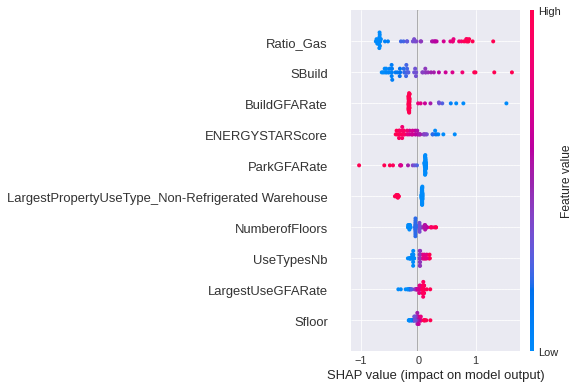

In [93]:
svr_shap_values = svr_explainer.shap_values(sample)
f=plt.figure(figsize=(38,18))
shap.summary_plot(svr_shap_values, sample, max_display=10)

Here we can see that ENERGYSTARScore feature isn't important for our model

#Prediction of SiteEnergyUse(kBtu) with Imputed values in ENERGYSTARScore

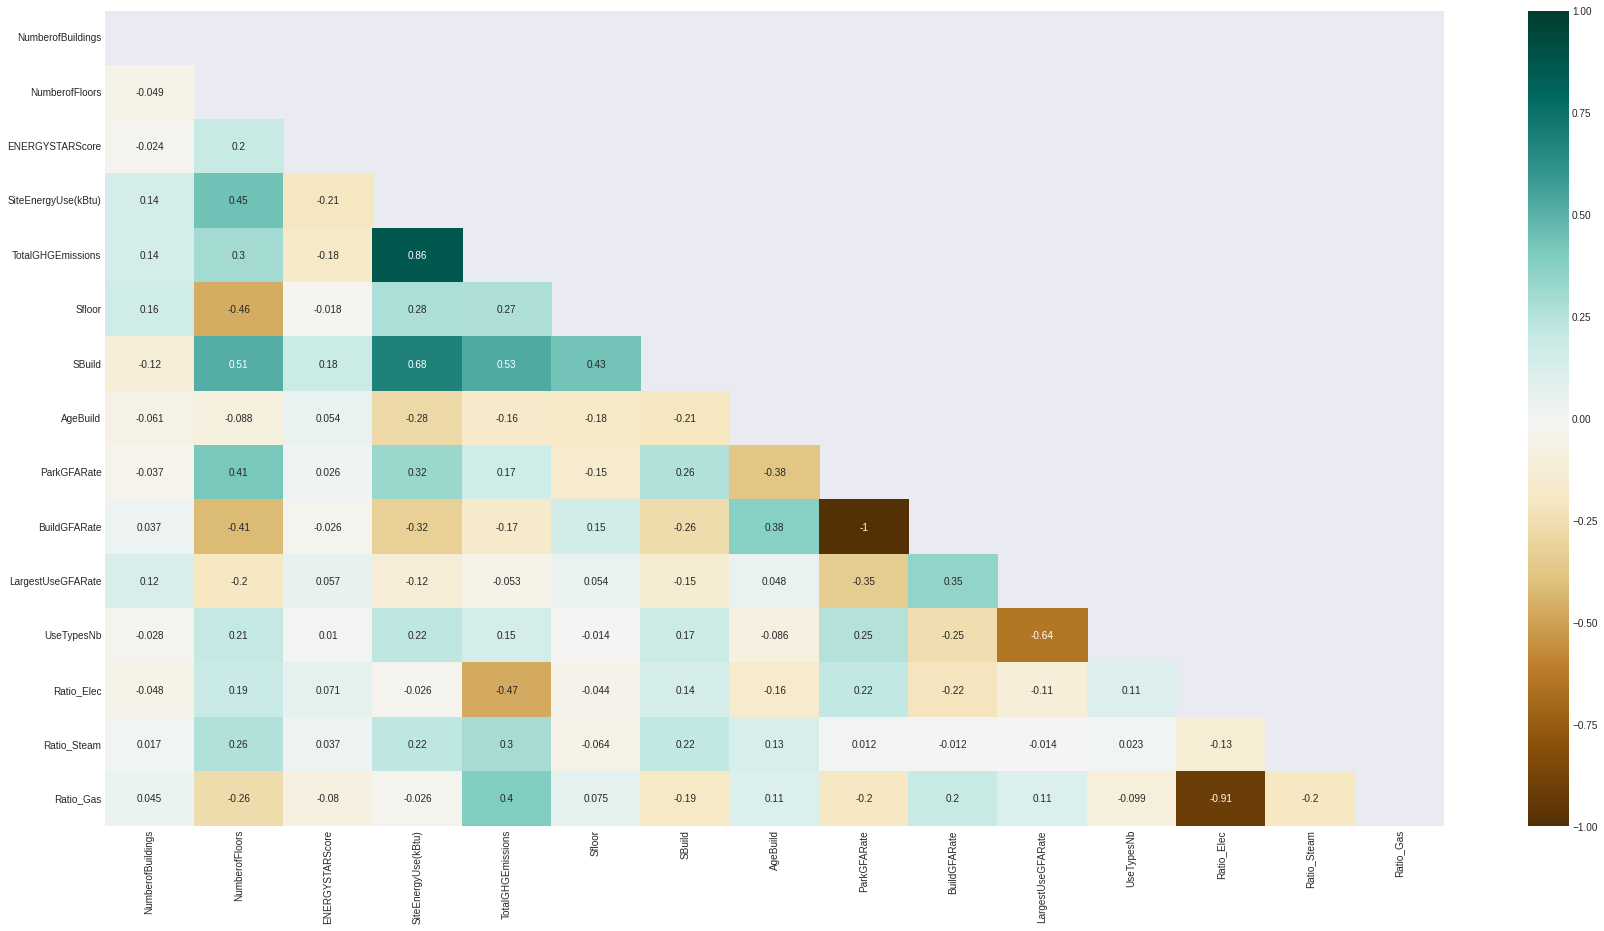

In [94]:
mask_2 = np.triu(np.ones_like(df_ml_pred.corr(), dtype=np.bool))

plt.figure(figsize=(30,15))
sns.heatmap(df_ml_pred.corr(method="spearman"), annot=True, vmin=-1, vmax=1, mask=mask_2,cmap='BrBG')
plt.show()

In [98]:
X = df_ml_pred.drop(columns=['TotalGHGEmissions'])


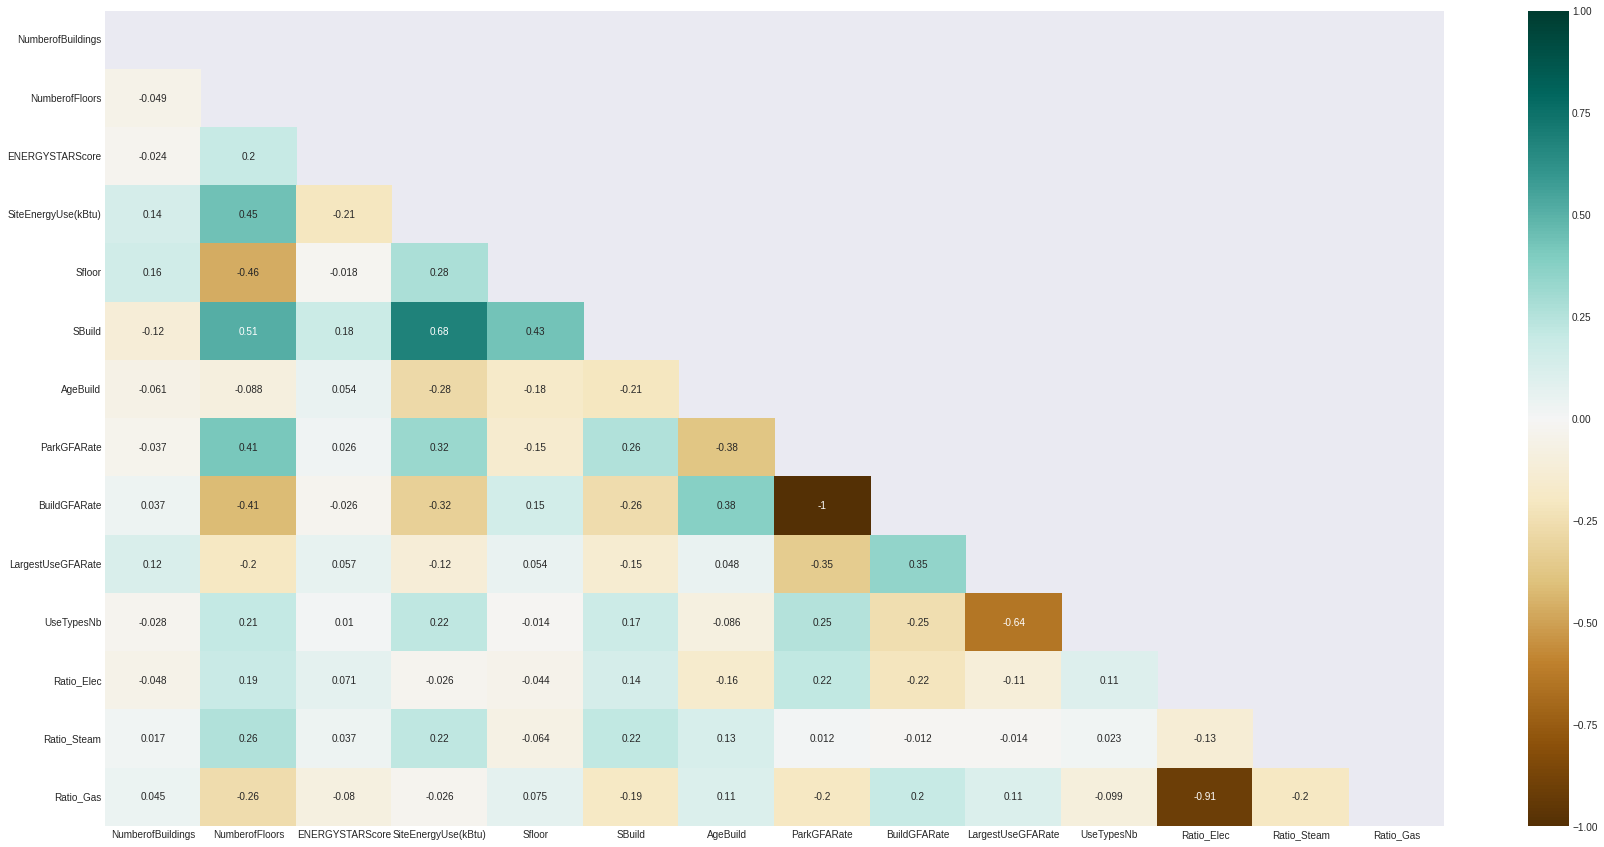

In [96]:
mask_2 = np.triu(np.ones_like(X.corr(), dtype=np.bool))

plt.figure(figsize=(30,15))
sns.heatmap(X.corr(method="spearman"), annot=True, vmin=-1, vmax=1, mask=mask_2,cmap='BrBG')
plt.show()

Encoding categorical features with OneHotEncoder and Normalizing numericals one

In [99]:
enc = OneHotEncoder(handle_unknown='ignore')
cat_X = pd.DataFrame(enc.fit_transform(X[['ESS_miss', 'BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'LargestPropertyUseType']]).toarray(), columns=enc.get_feature_names_out())
X=pd.concat([cat_X, X.iloc[:,5:19]], axis=1)
X.iloc[:, 89:104]=StandardScaler().fit_transform(X.iloc[:, 89:104])
X.head(5)

ESS_miss_n  ESS_miss_y  BuildingType_Campus  BuildingType_NonResidential  \
0         1.0         0.0                  0.0                          1.0   
1         1.0         0.0                  0.0                          1.0   
2         1.0         0.0                  0.0                          1.0   
3         1.0         0.0                  0.0                          1.0   
4         1.0         0.0                  0.0                          1.0   

   BuildingType_SPS-District K-12  PrimaryPropertyType_Distribution Center  \
0                             0.0                                      0.0   
1                             0.0                                      0.0   
2                             0.0                                      0.0   
3                             0.0                                      0.0   
4                             0.0                                      0.0   

   PrimaryPropertyType_Hospital  PrimaryPropertyType_Hotel  \
0                           0.0                        1.0   
1                           0.0                        1.0   
2                           0.0                        1.0   
3                           0.0                        1.0   
4                           0.0                        1.0   

   PrimaryPropertyType_K-12 School  PrimaryPropertyType_Laboratory  \
0                              0.0                             0.0   
1                              0.0                             0.0   
2                              0.0                             0.0   
3                              0.0                             0.0   
4                              0.0                             0.0   

   PrimaryPropertyType_Large Office  PrimaryPropertyType_Low-Rise Multifamily  \
0                               0.0                                       0.0   
1                               0.0                                       0.0   
2                               0.0                                       0.0   
3                               0.0                                       0.0   
4                               0.0                                       0.0   

   PrimaryPropertyType_Medical Office  PrimaryPropertyType_Mixed Use Property  \
0                                 0.0                                     0.0   
1                                 0.0                                     0.0   
2                                 0.0                                     0.0   
3                                 0.0                                     0.0   
4                                 0.0                                     0.0   

   PrimaryPropertyType_Other  PrimaryPropertyType_Refrigerated Warehouse  \
0                        0.0                                         0.0   
1                        0.0                                         0.0   
2                        0.0                                         0.0   
3                        0.0                                         0.0   
4                        0.0                                         0.0   

   PrimaryPropertyType_Residence Hall  PrimaryPropertyType_Restaurant  \
0                                 0.0                             0.0   
1                                 0.0                             0.0   
2                                 0.0                             0.0   
3                                 0.0                             0.0   
4                                 0.0                             0.0   

   PrimaryPropertyType_Retail Store  \
0                               0.0   
1                               0.0   
2                               0.0   
3                               0.0   
4                               0.0   

   PrimaryPropertyType_Self-Storage Facility  \
0                                        0.0   
1                                        0.0   
2               

Create Target

In [100]:
print(X.shape)
y=X['SiteEnergyUse(kBtu)']
X=X.drop(columns=['SiteEnergyUse(kBtu)'])
print(y.shape, X.shape)

(1547, 103)
(1547,) (1547, 102)


Create train and test set

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2)

Getting baseline error

In [102]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_regr.predict(X_test)
baseline_error = dummy_regr.score(X_test, y_test)
print(baseline_error)

-0.000133345861570211


Nested Cross Validation initialisation

In [103]:
# Initializing 
reg1 = LinearRegression()
reg2 = DecisionTreeRegressor()
reg3 = RandomForestRegressor()
reg4 = SVR()
reg5 = SGDRegressor()



# Setting up the parameter grids
param_grid1 = [{'fit_intercept' : [True, False]}]

param_grid2 = [{'max_depth': list(range(1, 10))}]

param_grid3 = [{'n_estimators': [10, 100, 500], 
                'max_features' : ['auto', 'sqrt'],
                'max_depth': [10,50,100],
                'min_samples_leaf': [1,3,5],
                'min_samples_split': [2,3,5]}
               ]

param_grid4 = [{'kernel': ['rbf'],
                'C': np.power(10., np.arange(-4, 4)),
                'gamma': np.power(10., np.arange(-5, 0))},
               {'kernel': ['linear'],
                'C': np.power(10., np.arange(-4, 4))}]

param_grid5 = [{'loss': ['squared_error', 'huber', 'epsilon_insensitive'],
                'penalty': ['l2', 'l1', 'elasticnet'],
                'learning_rate': ['constant', 'optimal', 'invscaling']}]


gridcvs = {}
inner_cv = KFold(n_splits=2, shuffle=True)

for pgrid, est, name in zip((param_grid1, param_grid2, param_grid3, param_grid4, param_grid5), 
                            (reg1, reg2, reg3, reg4, reg5), 
                            ('LinearR','DTree', 'RForest', 'SVR', 'SGDReg')): 
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0,
                       scoring='r2',
                       refit=True)
    gridcvs[name] = gcv

In [104]:
outer_cv = KFold(n_splits=5, shuffle=True)


for name, gs_est in sorted(gridcvs.items()):
    scores_dict = cross_validate(gs_est, 
                                 X=X_train, 
                                 y=y_train, 
                                 cv=outer_cv,
                                 return_estimator=True,
                                 n_jobs=-1)

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    
    for i in range(scores_dict['test_score'].shape[0]):

        print('\n        Best R2 (avg. of inner test folds) %.2f%%' % (scores_dict['estimator'][i].best_score_ * 100))
        print('        Best parameters:', scores_dict['estimator'][i].best_estimator_)
        print('        R2 (on outer test fold) %.2f%%' % (scores_dict['test_score'][i]*100))

    print('\n%s | outer R2 %.2f%% +/- %.2f' % 
          (name, scores_dict['test_score'].mean() * 100, 
           scores_dict['test_score'].std() * 100))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        Best R2 (avg. of inner test folds) 55.24%
        Best parameters: DecisionTreeRegressor(max_depth=9)
        R2 (on outer test fold) 65.68%

        Best R2 (avg. of inner test folds) 63.20%
        Best parameters: DecisionTreeRegressor(max_depth=5)
        R2 (on outer test fold) 60.16%

        Best R2 (avg. of inner test folds) 66.90%
        Best parameters: DecisionTreeRegressor(max_depth=8)
        R2 (on outer test fold) 60.22%

        Best R2 (avg. of inner test folds) 56.82%
        Best parameters: DecisionTreeRegressor(max_depth=4)
        R2 (on outer test fold) 63.89%

        Best R2 (avg. of inner test folds) 59.61%
        Best parameters: DecisionTreeRegressor(max_depth=8)
        R2 (on outer test fold) 65.68%

DTree | outer R2 63.13% +/- 2.49
-------------------------------------------------- 

Algorithm: LinearR
    Inner loop:

        Best R2 (avg. of inner test folds

We will choose SVR to predict Energy consumption

In [105]:
gcv_model_select = GridSearchCV(estimator=reg4,
                                param_grid=param_grid4,
                                scoring='r2',
                                n_jobs=-1,
                                cv=5,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'gamma': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]),
                          'kernel': ['rbf']},
                         {'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'kernel': ['linear']}],
             scoring='r2', verbose=1)

In [106]:
print(gcv_model_select.best_score_)
print(gcv_model_select.best_estimator_)

0.8596935273118443
SVR(C=1000.0, gamma=0.001)


In [107]:
best_model = SVR(C=1000.0, gamma=0.001)
best_model.fit(X_train, y_train)

train_acc = r2_score(y_true=y_train, y_pred=best_model.predict(X_train))
test_acc = r2_score(y_true=y_test, y_pred=best_model.predict(X_test))

print('R2_score %.2f%% (average over k-fold CV test folds)' %
      (100 * gcv_model_select.best_score_))
print('Best Parameters: %s' % gcv_model_select.best_params_)

print('Training R2_score: %.2f%%' % (100 * train_acc))
print('Test R2_score: %.2f%%' % (100 * test_acc))

train_acc = mean_squared_error(y_true=y_train, y_pred=best_model.predict(X_train), squared=False)
test_acc = mean_squared_error(y_true=y_test, y_pred=best_model.predict(X_test), squared=False)

print('RMSE (average over k-fold CV test folds)',
      (gcv_model_select.best_score_))


print('Training RMSE: ',(train_acc))
print('Test RMSE: ', (test_acc))

R2_score 85.97% (average over k-fold CV test folds)
Best Parameters: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Training R2_score: 91.97%
Test R2_score: 85.14%
RMSE (average over k-fold CV test folds) 0.8596935273118443
Training RMSE:  0.285565519161604
Test RMSE:  0.373784510344426


  0%|          | 0/50 [00:00<?, ?it/s]

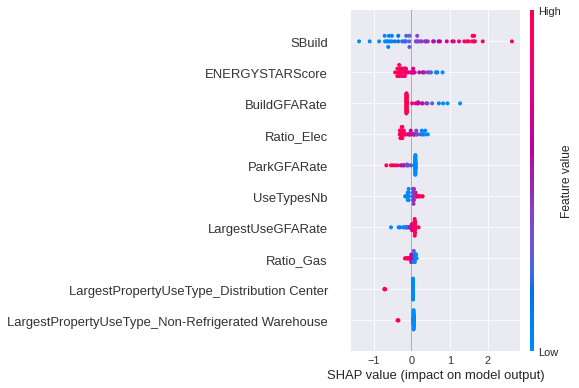

In [108]:
sample=X_test.sample(50)

svc_explainer = shap.KernelExplainer(best_model.predict,X_test)

svc_shap_values = svc_explainer.shap_values(sample)
f=plt.figure(figsize=(38,18))
shap.summary_plot(svc_shap_values, sample, max_display=10)

#Prediction of TotalGHGEmissions without Imputed values in ENERGYSTARScore (dropping 572 rows)


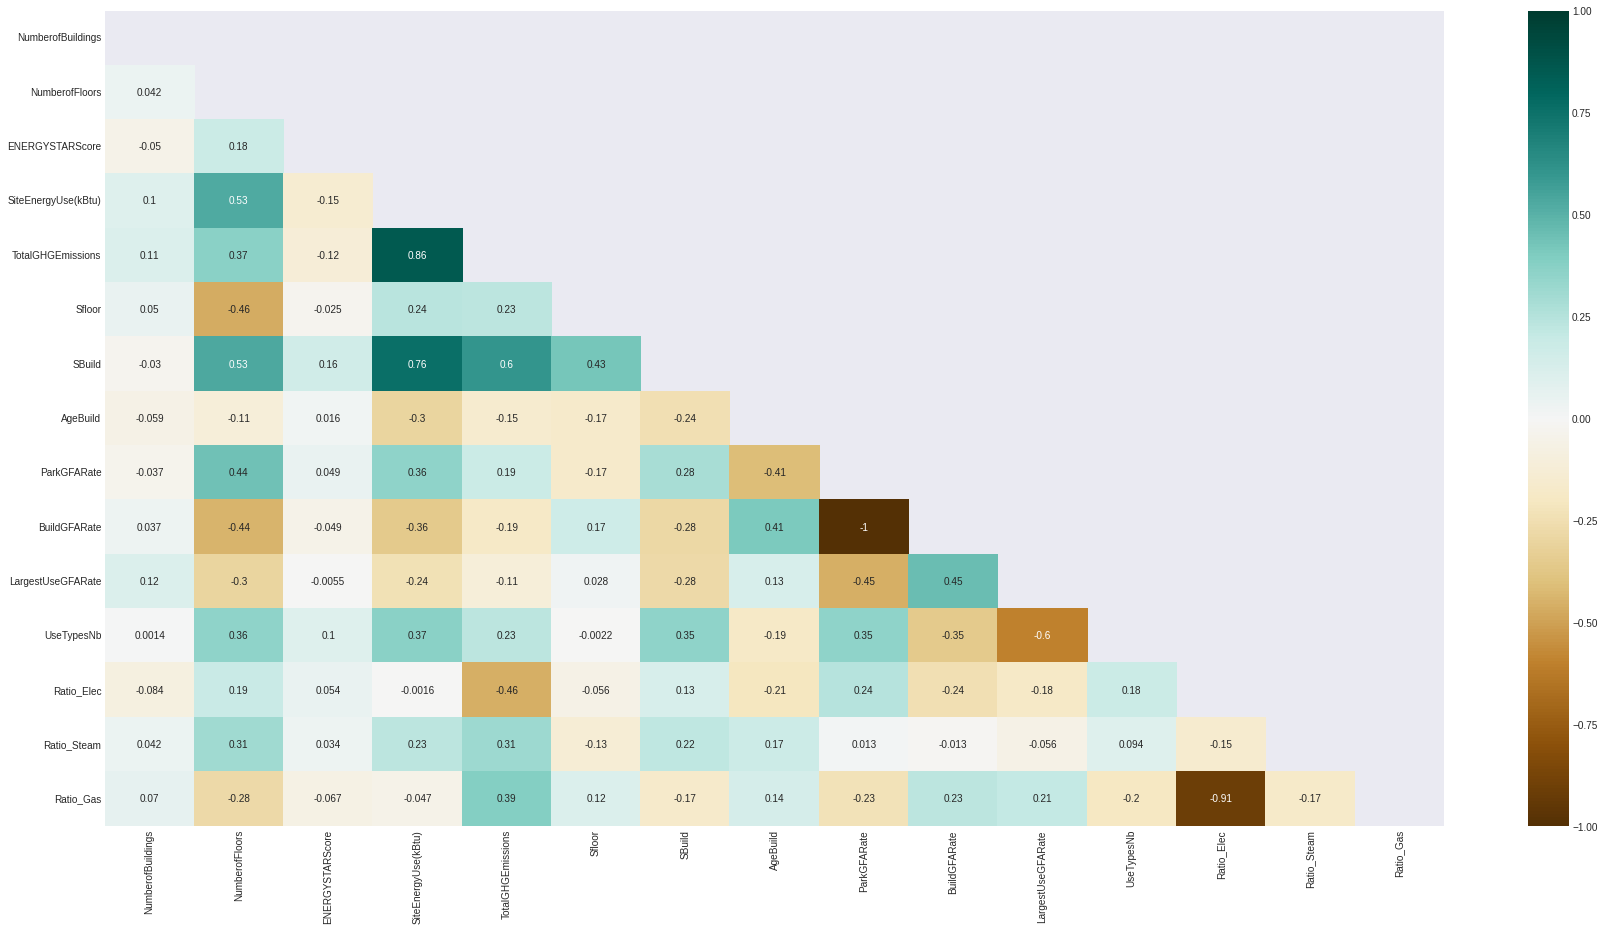

In [109]:
mask_2 = np.triu(np.ones_like(df_wo.corr(), dtype=np.bool))

plt.figure(figsize=(30,15))
sns.heatmap(df_wo.corr(method="spearman"), annot=True, vmin=-1, vmax=1, mask=mask_2,cmap='BrBG')
plt.show()

We create a new df

In [113]:
X = df_wo.drop(columns=['SiteEnergyUse(kBtu)', 'ESS_miss'])

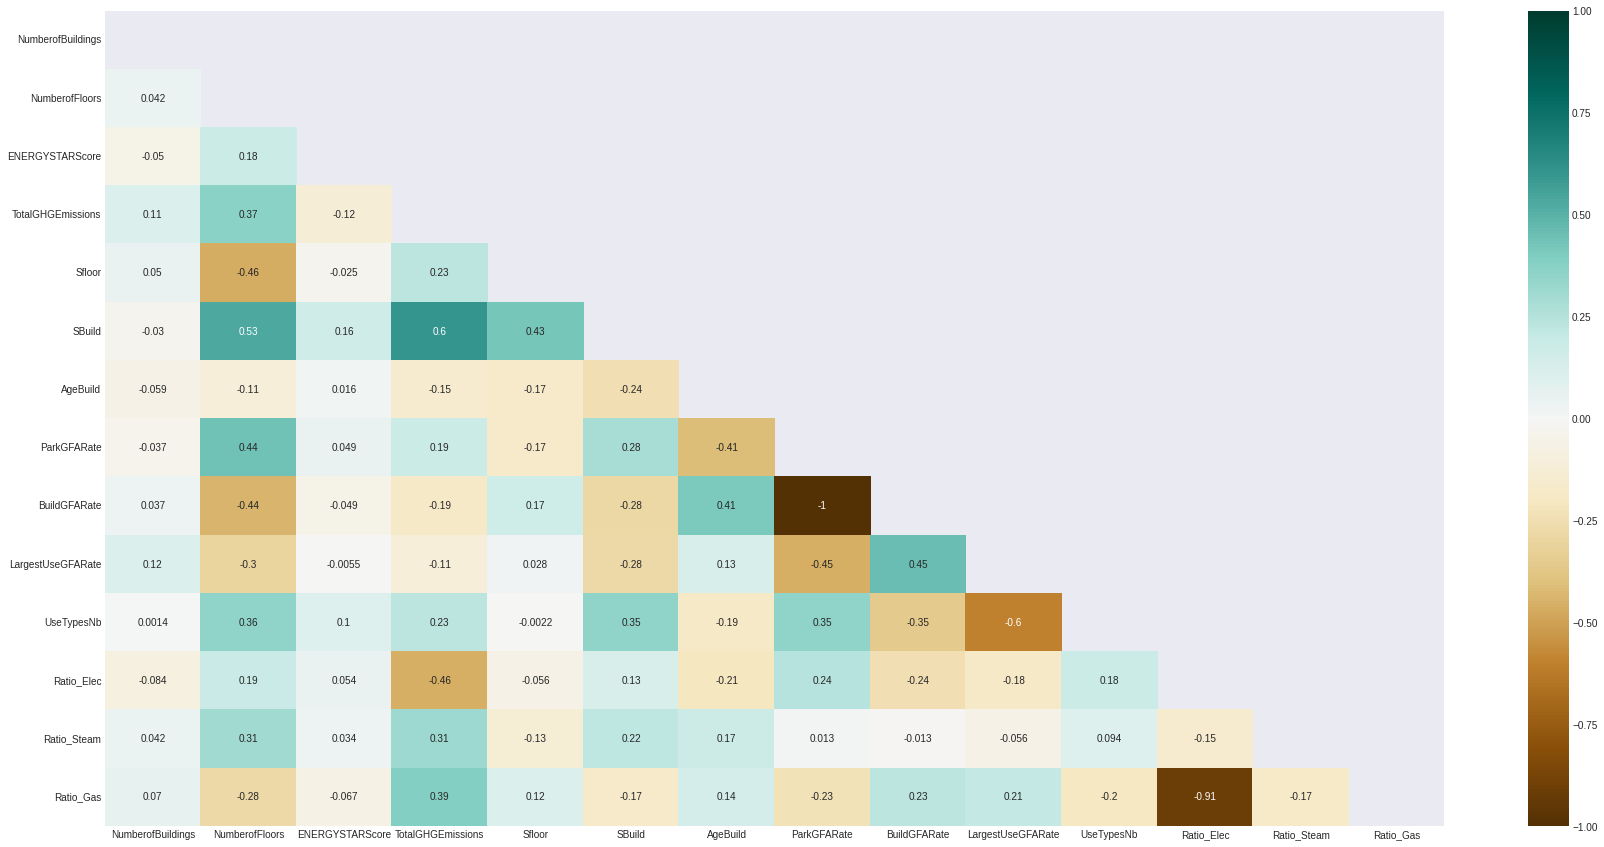

In [111]:
mask_2 = np.triu(np.ones_like(X.corr(), dtype=np.bool))

plt.figure(figsize=(30,15))
sns.heatmap(X.corr(method="spearman"), annot=True, vmin=-1, vmax=1, mask=mask_2,cmap='BrBG')
plt.show()

Encoding categorical features with OneHotEncoder and Normalizing numericals one

In [114]:
enc = OneHotEncoder(handle_unknown='ignore')
cat_X = pd.DataFrame(enc.fit_transform(X[['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'LargestPropertyUseType']]).toarray(), columns=enc.get_feature_names_out())
X=pd.concat([cat_X, X.iloc[:,4:18]], axis=1)
X.iloc[:, 59:73]=StandardScaler().fit_transform(X.iloc[:, 59:73])
X.head(5)

BuildingType_Campus  BuildingType_NonResidential  \
0                  0.0                          1.0   
1                  0.0                          1.0   
2                  0.0                          1.0   
3                  0.0                          1.0   
4                  0.0                          1.0   

   BuildingType_SPS-District K-12  PrimaryPropertyType_Distribution Center  \
0                             0.0                                      0.0   
1                             0.0                                      0.0   
2                             0.0                                      0.0   
3                             0.0                                      0.0   
4                             0.0                                      0.0   

   PrimaryPropertyType_Hospital  PrimaryPropertyType_Hotel  \
0                           0.0                        1.0   
1                           0.0                        1.0   
2                           0.0                        1.0   
3                           0.0                        1.0   
4                           0.0                        1.0   

   PrimaryPropertyType_K-12 School  PrimaryPropertyType_Large Office  \
0                              0.0                               0.0   
1                              0.0                               0.0   
2                              0.0                               0.0   
3                              0.0                               0.0   
4                              0.0                               0.0   

   PrimaryPropertyType_Low-Rise Multifamily  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   PrimaryPropertyType_Medical Office  PrimaryPropertyType_Mixed Use Property  \
0                                 0.0                                     0.0   
1                                 0.0                                     0.0   
2                                 0.0                                     0.0   
3                                 0.0                                     0.0   
4                                 0.0                                     0.0   

   PrimaryPropertyType_Other  PrimaryPropertyType_Refrigerated Warehouse  \
0                        0.0                                         0.0   
1                        0.0                                         0.0   
2                        0.0                                         0.0   
3                        0.0                                         0.0   
4                        0.0                                         0.0   

   PrimaryPropertyType_Residence Hall  PrimaryPropertyType_Retail Store  \
0                                 0.0                               0.0   
1                                 0.0                               0.0   
2                                 0.0                               0.0   
3                                 0.0                               0.0   
4                                 0.0                               0.0   

   PrimaryPropertyType_Senior Care Community  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

   PrimaryPropertyType_Small- and Mid-Sized Office  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   

   PrimaryPropertyType_Supermarket / Grocery Store  \
0                                              0.0 

Create Target

In [115]:
print(X.shape)
y=X['TotalGHGEmissions']
X=X.drop(columns=['TotalGHGEmissions'])
print(y.shape, X.shape)

(996, 73)
(996,) (996, 72)


Splitting our dataset into train set and test set

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Setting up our Baseline error using DummyRegressor from sklearn

In [117]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_regr.predict(X_test)
baseline_error = dummy_regr.score(X_test, y_test)
print(baseline_error)

-0.0001156627349454542


Nested cross validation

In [118]:
# Initializing 
reg1 = LinearRegression()
reg2 = DecisionTreeRegressor()
reg3 = RandomForestRegressor()
reg4 = SVR()
reg5 = SGDRegressor()


# Setting up the parameter grids
param_grid1 = [{'fit_intercept' : [True, False]}]

param_grid2 = [{'max_depth': list(range(1, 10))}]

param_grid3 = [{'n_estimators': [10, 100, 500],
                'max_features' : ['auto', 'sqrt'],
                'max_depth': [10,50,100],
                'min_samples_leaf': [1,3,5],
                'min_samples_split': [2,3,5]}]

param_grid4 = [{'kernel': ['rbf'],
                'C': np.power(10., np.arange(-4, 4)),
                'gamma': np.power(10., np.arange(-5, 0))},
               {'kernel': ['linear'],
                'C': np.power(10., np.arange(-4, 4))}]

param_grid5 = [{'loss': ['squared_error', 'huber', 'epsilon_insensitive'],
                'penalty': ['l2', 'l1', 'elasticnet'],
                'learning_rate': ['constant', 'optimal', 'invscaling']}]

In [119]:
gridcvs = {}
inner_cv = KFold(n_splits=2, shuffle=True, random_state=42)

for pgrid, est, name in zip((param_grid1, param_grid2, param_grid3, param_grid4, param_grid5), 
                            (reg1, reg2, reg3, reg4, reg5), 
                            ('LinearR','DTree', 'RForest', 'SVR', 'SGDReg')): 
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0,
                       scoring='r2',
                       refit=True)
    gridcvs[name] = gcv

In [120]:
### High run time (30 minutes)
outer_cv = KFold(n_splits=5, shuffle=True)


for name, gs_est in sorted(gridcvs.items()):
    scores_dict = cross_validate(gs_est, 
                                 X=X_train, 
                                 y=y_train, 
                                 cv=outer_cv,
                                 return_estimator=True,
                                 n_jobs=-1)

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    
    for i in range(scores_dict['test_score'].shape[0]):

        print('\n        Best R2 (avg. of inner test folds) %.2f%%' % (scores_dict['estimator'][i].best_score_ * 100))
        print('        Best parameters:', scores_dict['estimator'][i].best_estimator_)
        print('        R2 (on outer test fold) %.2f%%' % (scores_dict['test_score'][i]*100))

    print('\n%s | outer R2 %.2f%% +/- %.2f' % 
          (name, scores_dict['test_score'].mean() * 100, 
           scores_dict['test_score'].std() * 100))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        Best R2 (avg. of inner test folds) 58.76%
        Best parameters: DecisionTreeRegressor(max_depth=8)
        R2 (on outer test fold) 59.73%

        Best R2 (avg. of inner test folds) 63.62%
        Best parameters: DecisionTreeRegressor(max_depth=7)
        R2 (on outer test fold) 57.83%

        Best R2 (avg. of inner test folds) 67.86%
        Best parameters: DecisionTreeRegressor(max_depth=6)
        R2 (on outer test fold) 66.14%

        Best R2 (avg. of inner test folds) 61.00%
        Best parameters: DecisionTreeRegressor(max_depth=7)
        R2 (on outer test fold) 70.78%

        Best R2 (avg. of inner test folds) 62.80%
        Best parameters: DecisionTreeRegressor(max_depth=7)
        R2 (on outer test fold) 67.14%

DTree | outer R2 64.32% +/- 4.82
-------------------------------------------------- 

Algorithm: LinearR
    Inner loop:

        Best R2 (avg. of inner test folds

We will choose SGDReg as the model to predict GHGEmission but we need now to get best parameters for the whole training set

In [121]:
gcv_model_select = GridSearchCV(estimator=reg5,
                                param_grid=param_grid5,
                                scoring='r2',
                                n_jobs=-1,
                                cv=KFold(n_splits=5, shuffle=True),
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SGDRegressor(), n_jobs=-1,
             param_grid=[{'learning_rate': ['constant', 'optimal',
                                            'invscaling'],
                          'loss': ['squared_error', 'huber',
                                   'epsilon_insensitive'],
                          'penalty': ['l2', 'l1', 'elasticnet']}],
             scoring='r2', verbose=1)

In [122]:
print(gcv_model_select.best_score_)
print(gcv_model_select.best_estimator_)

0.8994876347360096
SGDRegressor(learning_rate='constant')


In [124]:
best_model = SGDRegressor(learning_rate='constant')
best_model.fit(X_train,y_train)

train_acc = r2_score(y_true=y_train, y_pred=best_model.predict(X_train))
test_acc = r2_score(y_true=y_test, y_pred=best_model.predict(X_test))

print('R2_score %.2f%% (average over k-fold CV test folds)' %
      (100 * gcv_model_select.best_score_))
print('Best Parameters: %s' % gcv_model_select.best_params_)

print('Training R2_score: %.2f%%' % (100 * train_acc))
print('Test R2_score: %.2f%%' % (100 * test_acc))

train_acc = mean_squared_error(y_true=y_train, y_pred=best_model.predict(X_train), squared=False)
test_acc = mean_squared_error(y_true=y_test, y_pred=best_model.predict(X_test), squared=False)

print('RMSE (average over k-fold CV test folds)',
      (gcv_model_select.best_score_))


print('Training RMSE: ',(train_acc))
print('Test RMSE: ', (test_acc))

R2_score 89.95% (average over k-fold CV test folds)
Best Parameters: {'learning_rate': 'constant', 'loss': 'squared_error', 'penalty': 'l2'}
Training R2_score: 91.79%
Test R2_score: 90.30%
RMSE (average over k-fold CV test folds) 0.8994876347360096
Training RMSE:  0.28429929802438203
Test RMSE:  0.32099875558162655


### Feature Selection

In [125]:
sgd_explainer = shap.KernelExplainer(best_model.predict,X_test)
sample=X_test.sample(50)

  0%|          | 0/50 [00:00<?, ?it/s]

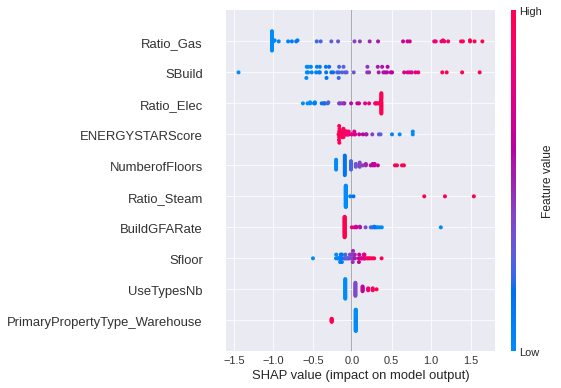

In [126]:
sgd_shap_values = sgd_explainer.shap_values(sample)
f=plt.figure(figsize=(38,18))
shap.summary_plot(sgd_shap_values, sample, max_display=10)

Here again, ENERGYSTARScore isn't mandatory to the model

#Prediction of SiteEnergyUse(kBtu) without Imputed values in ENERGYSTARScore (dropping 572 rows)

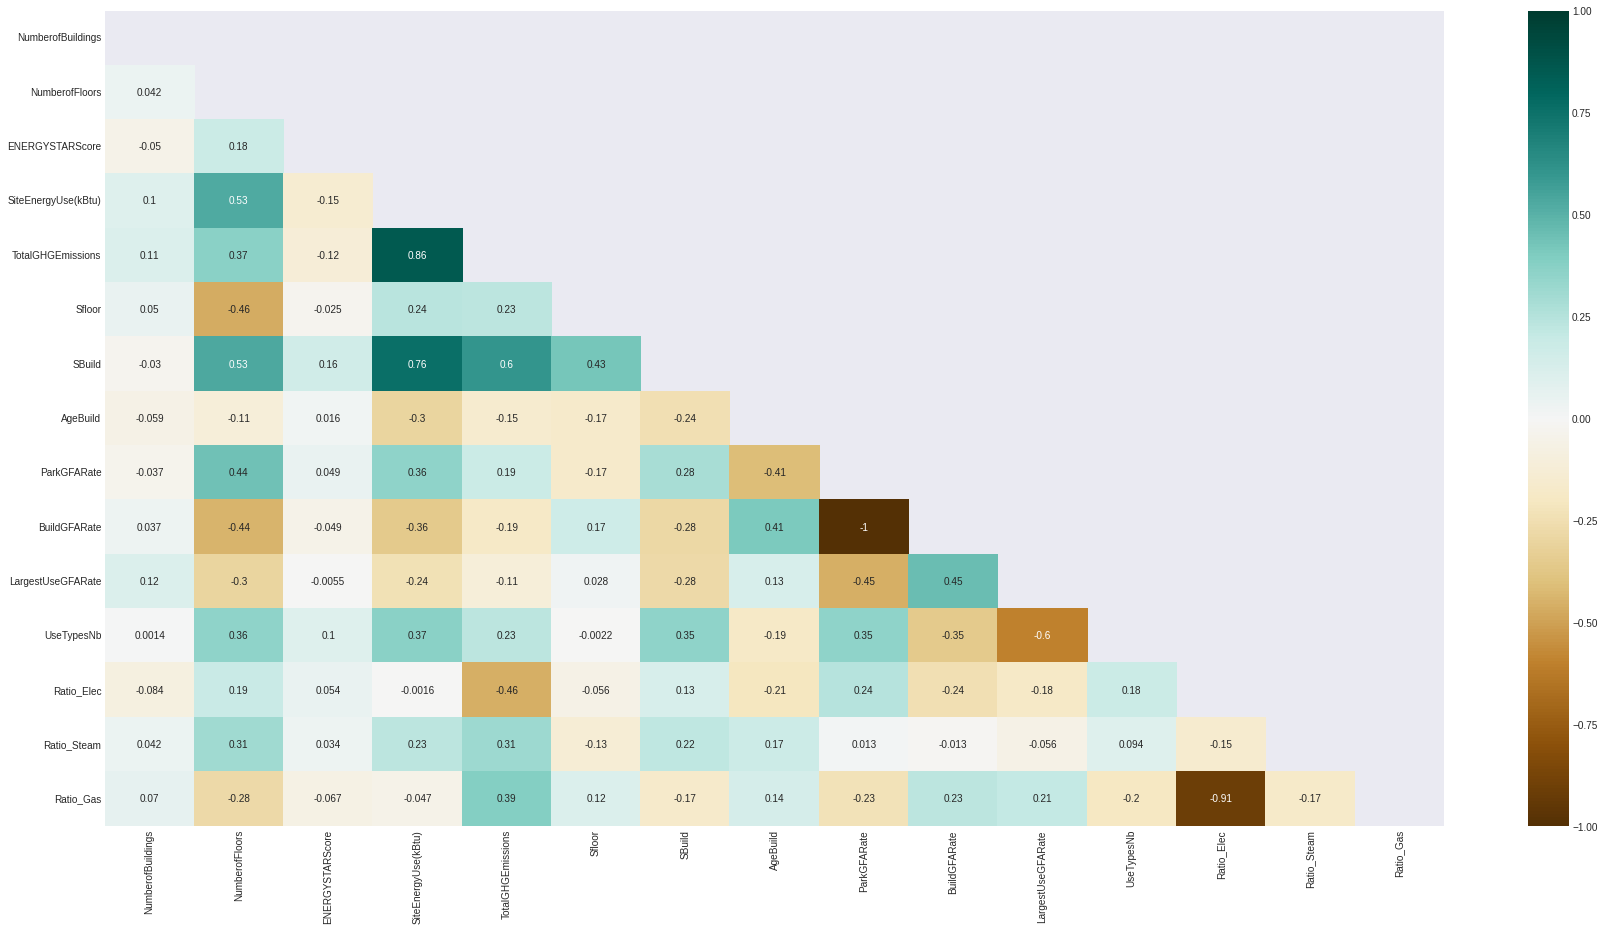

In [127]:
mask_2 = np.triu(np.ones_like(df_wo.corr(), dtype=np.bool))

plt.figure(figsize=(30,15))
sns.heatmap(df_wo.corr(method="spearman"), annot=True, vmin=-1, vmax=1, mask=mask_2,cmap='BrBG')
plt.show()

In [128]:
X = df_wo.drop(columns=['TotalGHGEmissions', 'ESS_miss'])

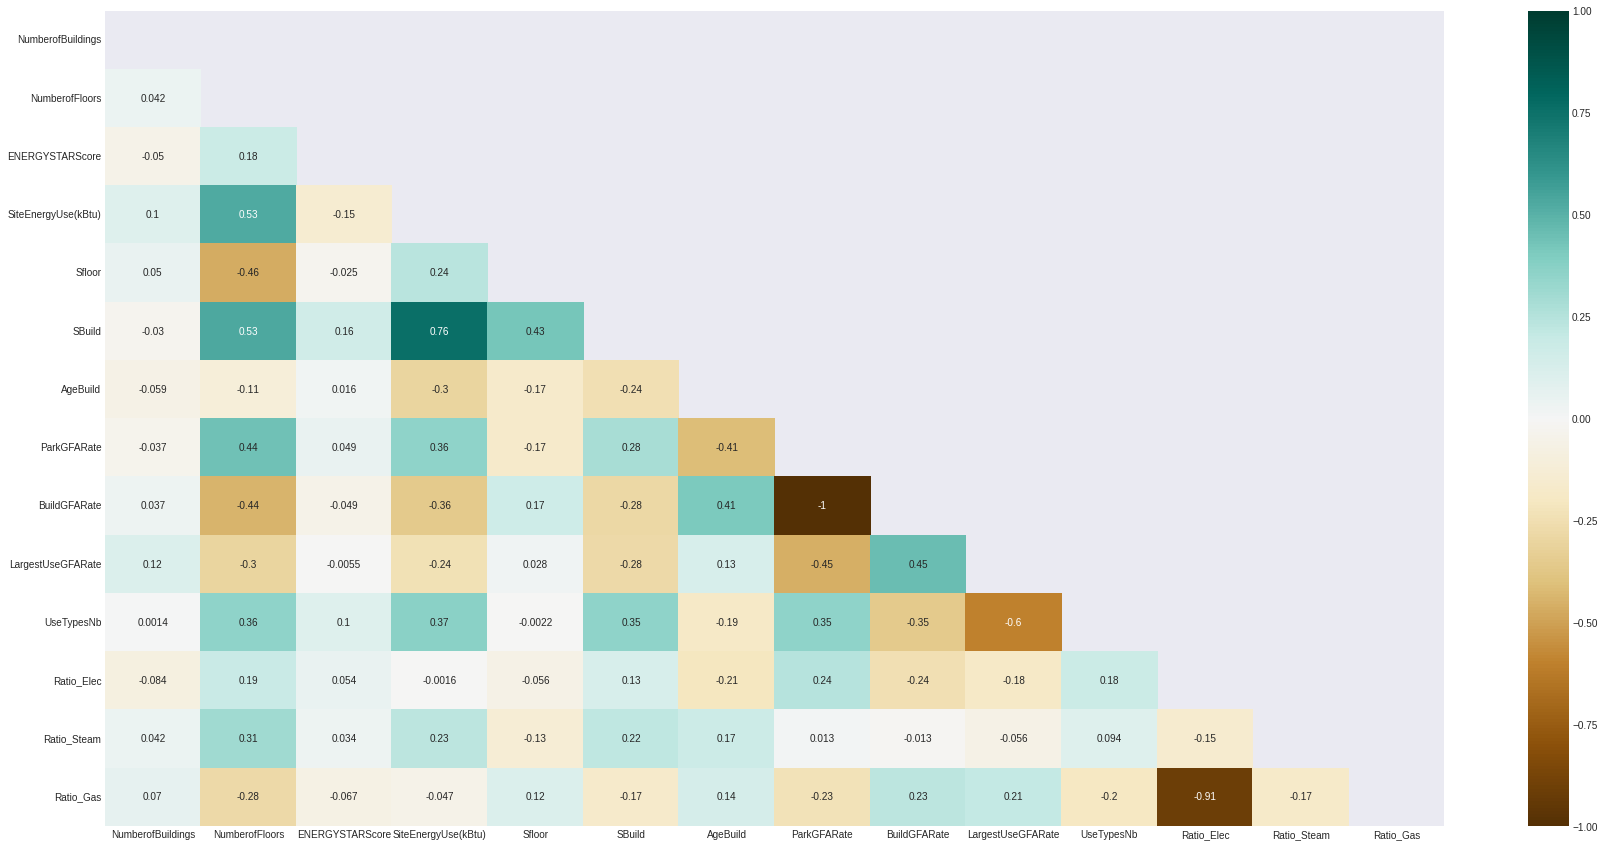

In [129]:
mask_2 = np.triu(np.ones_like(X.corr(), dtype=np.bool))

plt.figure(figsize=(30,15))
sns.heatmap(X.corr(method="spearman"), annot=True, vmin=-1, vmax=1, mask=mask_2,cmap='BrBG')
plt.show()

Encoding categorical features with OneHotEncoder and Normalizing numericals one

In [130]:
enc = OneHotEncoder(handle_unknown='ignore')
cat_X = pd.DataFrame(enc.fit_transform(X[['BuildingType', 'PrimaryPropertyType', 'Neighborhood',
       'LargestPropertyUseType']]).toarray(), columns=enc.get_feature_names_out())
X=pd.concat([cat_X, X.iloc[:,4:18]], axis=1)
X.iloc[:, 59:73]=StandardScaler().fit_transform(X.iloc[:, 59:73])
X.head(5)

BuildingType_Campus  BuildingType_NonResidential  \
0                  0.0                          1.0   
1                  0.0                          1.0   
2                  0.0                          1.0   
3                  0.0                          1.0   
4                  0.0                          1.0   

   BuildingType_SPS-District K-12  PrimaryPropertyType_Distribution Center  \
0                             0.0                                      0.0   
1                             0.0                                      0.0   
2                             0.0                                      0.0   
3                             0.0                                      0.0   
4                             0.0                                      0.0   

   PrimaryPropertyType_Hospital  PrimaryPropertyType_Hotel  \
0                           0.0                        1.0   
1                           0.0                        1.0   
2                           0.0                        1.0   
3                           0.0                        1.0   
4                           0.0                        1.0   

   PrimaryPropertyType_K-12 School  PrimaryPropertyType_Large Office  \
0                              0.0                               0.0   
1                              0.0                               0.0   
2                              0.0                               0.0   
3                              0.0                               0.0   
4                              0.0                               0.0   

   PrimaryPropertyType_Low-Rise Multifamily  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   PrimaryPropertyType_Medical Office  PrimaryPropertyType_Mixed Use Property  \
0                                 0.0                                     0.0   
1                                 0.0                                     0.0   
2                                 0.0                                     0.0   
3                                 0.0                                     0.0   
4                                 0.0                                     0.0   

   PrimaryPropertyType_Other  PrimaryPropertyType_Refrigerated Warehouse  \
0                        0.0                                         0.0   
1                        0.0                                         0.0   
2                        0.0                                         0.0   
3                        0.0                                         0.0   
4                        0.0                                         0.0   

   PrimaryPropertyType_Residence Hall  PrimaryPropertyType_Retail Store  \
0                                 0.0                               0.0   
1                                 0.0                               0.0   
2                                 0.0                               0.0   
3                                 0.0                               0.0   
4                                 0.0                               0.0   

   PrimaryPropertyType_Senior Care Community  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

   PrimaryPropertyType_Small- and Mid-Sized Office  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   

   PrimaryPropertyType_Supermarket / Grocery Store  \
0                                              0.0 

Create Target

In [131]:
print(X.shape)
y=X['SiteEnergyUse(kBtu)']
X=X.drop(columns=['SiteEnergyUse(kBtu)'])
print(y.shape, X.shape)

(996, 73)
(996,) (996, 72)


Create train and test set

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2)

Getting baseline error

In [133]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_regr.predict(X_test)
baseline_error = dummy_regr.score(X_test, y_test)
print(baseline_error)

-0.00024437776130392663


Nested Cross Validation initialisation

In [134]:
# Initializing 
reg1 = LinearRegression()
reg2 = DecisionTreeRegressor()
reg3 = RandomForestRegressor()
reg4 = SVR()
reg5 = SGDRegressor()



# Setting up the parameter grids
param_grid1 = [{'fit_intercept' : [True, False]}]

param_grid2 = [{'max_depth': list(range(1, 10))}]

param_grid3 = [{'n_estimators': [10, 100, 500], 
                'max_features' : ['auto', 'sqrt'],
                'max_depth': [10,50,100],
                'min_samples_leaf': [1,3,5],
                'min_samples_split': [2,3,5]}
               ]

param_grid4 = [{'kernel': ['rbf'],
                'C': np.power(10., np.arange(-4, 4)),
                'gamma': np.power(10., np.arange(-5, 0))},
               {'kernel': ['linear'],
                'C': np.power(10., np.arange(-4, 4))}]

param_grid5 = [{'loss': ['squared_error', 'huber', 'epsilon_insensitive'],
                'penalty': ['l2', 'l1', 'elasticnet'],
                'learning_rate': ['constant', 'optimal', 'invscaling']}]


gridcvs = {}
inner_cv = KFold(n_splits=2, shuffle=True)

for pgrid, est, name in zip((param_grid1, param_grid2, param_grid3, param_grid4, param_grid5), 
                            (reg1, reg2, reg3, reg4, reg5), 
                            ('LinearR','DTree', 'RForest', 'SVR', 'SGDReg')): 
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0,
                       scoring='r2',
                       refit=True)
    gridcvs[name] = gcv

In [135]:
outer_cv = KFold(n_splits=5, shuffle=True)


for name, gs_est in sorted(gridcvs.items()):
    scores_dict = cross_validate(gs_est, 
                                 X=X_train, 
                                 y=y_train, 
                                 cv=outer_cv,
                                 return_estimator=True,
                                 n_jobs=-1)

    print(50 * '-', '\n')
    print('Algorithm:', name)
    print('    Inner loop:')
    
    
    for i in range(scores_dict['test_score'].shape[0]):

        print('\n        Best R2 (avg. of inner test folds) %.2f%%' % (scores_dict['estimator'][i].best_score_ * 100))
        print('        Best parameters:', scores_dict['estimator'][i].best_estimator_)
        print('        R2 (on outer test fold) %.2f%%' % (scores_dict['test_score'][i]*100))

    print('\n%s | outer R2 %.2f%% +/- %.2f' % 
          (name, scores_dict['test_score'].mean() * 100, 
           scores_dict['test_score'].std() * 100))

-------------------------------------------------- 

Algorithm: DTree
    Inner loop:

        Best R2 (avg. of inner test folds) 63.59%
        Best parameters: DecisionTreeRegressor(max_depth=7)
        R2 (on outer test fold) 69.33%

        Best R2 (avg. of inner test folds) 62.99%
        Best parameters: DecisionTreeRegressor(max_depth=6)
        R2 (on outer test fold) 73.96%

        Best R2 (avg. of inner test folds) 64.72%
        Best parameters: DecisionTreeRegressor(max_depth=6)
        R2 (on outer test fold) 59.62%

        Best R2 (avg. of inner test folds) 63.66%
        Best parameters: DecisionTreeRegressor(max_depth=6)
        R2 (on outer test fold) 63.09%

        Best R2 (avg. of inner test folds) 70.93%
        Best parameters: DecisionTreeRegressor(max_depth=6)
        R2 (on outer test fold) 60.71%

DTree | outer R2 65.34% +/- 5.47
-------------------------------------------------- 

Algorithm: LinearR
    Inner loop:

        Best R2 (avg. of inner test folds

We will choose SVR to predict Energy consumption

In [136]:
gcv_model_select = GridSearchCV(estimator=reg4,
                                param_grid=param_grid4,
                                scoring='r2',
                                n_jobs=-1,
                                cv=5,
                                verbose=1,
                                refit=True)

gcv_model_select.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'gamma': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]),
                          'kernel': ['rbf']},
                         {'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'kernel': ['linear']}],
             scoring='r2', verbose=1)

In [137]:
print(gcv_model_select.best_score_)
print(gcv_model_select.best_estimator_)

0.9049329520234494
SVR(C=1000.0, gamma=0.001)


In [138]:
best_model = SVR(C=1000.0, gamma=0.001)
best_model.fit(X_train, y_train)

train_acc = r2_score(y_true=y_train, y_pred=best_model.predict(X_train))
test_acc = r2_score(y_true=y_test, y_pred=best_model.predict(X_test))

print('R2_score %.2f%% (average over k-fold CV test folds)' %
      (100 * gcv_model_select.best_score_))
print('Best Parameters: %s' % gcv_model_select.best_params_)

print('Training R2_score: %.2f%%' % (100 * train_acc))
print('Test R2_score: %.2f%%' % (100 * test_acc))

train_acc = mean_squared_error(y_true=y_train, y_pred=best_model.predict(X_train), squared=False)
test_acc = mean_squared_error(y_true=y_test, y_pred=best_model.predict(X_test), squared=False)

print('RMSE (average over k-fold CV test folds)',
      (gcv_model_select.best_score_))


print('Training RMSE: ',(train_acc))
print('Test RMSE: ', (test_acc))

R2_score 90.49% (average over k-fold CV test folds)
Best Parameters: {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
Training R2_score: 94.17%
Test R2_score: 91.00%
RMSE (average over k-fold CV test folds) 0.9049329520234494
Training RMSE:  0.2404179940894785
Test RMSE:  0.30511814997450215


  0%|          | 0/50 [00:00<?, ?it/s]

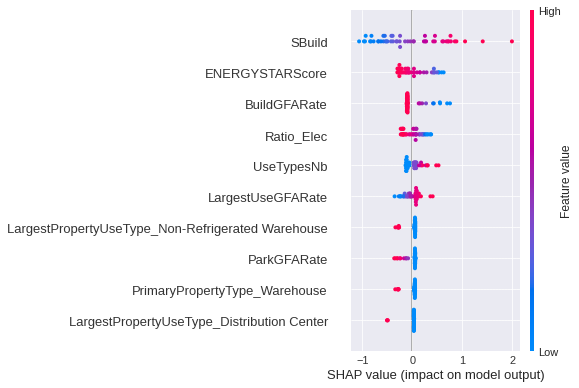

In [139]:
sample=X_test.sample(50)

svc_explainer = shap.KernelExplainer(best_model.predict,X_test)

svc_shap_values = svc_explainer.shap_values(sample)
f=plt.figure(figsize=(38,18))
shap.summary_plot(svc_shap_values, sample, max_display=10)